# Solar dynamo project

The aim of this project is to make Bayesian inference on the physical process called Solar Dynamo, and therefore to determine the parameters associated with the chosen model that have the greatest agreement with the data.
The goal will then be to make predictions using the estimated parameters.

Before carrying out an analysis on real data, to test the theory, artificially data were used (with parameters close to those associated with the real data estimated in [Carl Albert (2021)](https://iopscience.iop.org/article/10.3847/2041-8213/ac0fd6)).

To achieve the objectives, an appropriate model, a prior function and likelihood function were chosen in order to find the posterior function.
Once this expression was obtained, the optimal parameters that can describe the data were estimated by means of  the maximum a posteriori probability (MAP) estimate. The credibility intervals was then identified using the Monte Carlo Markov Chain method.

Once the consistency and correctness of the procedure on the test dataset was observed, we moved on to real data.
The process in this case was the same.
In the case of real data, an attempt was also made to estimate the influence of the planets by slightly changing the model, and then repeating the processes of MAP and estimation of the credibility intervals.

Finally, data predictions were made using the previously estimated parameters.

## Bayesian Inference

Given the observed data $\bar{y}$ and the model used to describe the phenomenon $\bar{\theta}$, the objective of Bayesian inference is to determine the model’s parameters in order to have the best agreement with the observations.

The pdf associated to the parameters of the model, which is the posterior probability distribution, is

$$
p(\bar{\theta}|\bar{y}) = \frac{p(\bar{y}|\bar{\theta})p(\bar{\theta})}{p(\bar{y})}
$$

$p(\bar{\theta})$ describes the prior knowledge about the model's parameters, and is called prior pdf. It can come from previous measurements or from assumptions.
$p(\bar{y}|\bar{\theta})$ is called likelihood and represents the joint probability of observing the data $\bar{y}$ given the model's paramethers $\bar{\theta}$. The denominator is called evidence and represents just a normalization constant.

The goal now is to estimate the most probable parameters of the posterior probability distribution, given the observed data: to do this a maximization is performed, so that the maximum value of the joint probability of the likelihood and the prior is found. The value obtained is called maximum a posteriori probability (MAP) estimate.

## Zero-dimensional dynamo model

Solar dynamo is a physical process that generates Sun's magnetic field. Inner motion of plasma fluid can develop electric currents and consequently an external magnetic field. Its two components are written in toroidal coordinates as $B_{\phi}(t)$ and $A(t)$, called toroidal and poloidal field respectively. Zero-dimensional dynamo model, as stated in [Wilmot-Smith et al. (2006)](https://iopscience.iop.org/article/10.1086/508013), is described in terms of two coupled ODE's that reflect the two different components interaction:

\begin{equation}
    \frac{d}{dt}B_{\phi}(t) = \frac{\Omega_0}{L} A(t-T_0) - \frac{B_{\phi}(t)}{\tau} \\
    \frac{d}{dt}A(t) = \alpha_0 f(B_{\phi}(t-T_1))B_{\phi}(t-T_1) - \frac{A(t)}{\tau}
\end{equation}

The model parameters $\Omega_0$, $L$, $\alpha_0$ rule the strength of the interaction between the two components, while $\tau$, $T_0$, $T_1$ represent typical time scales of the diffusion and delay process. The function $f$, in the most simple case, is defined in terms of an upper limit to the toroidal magnetic field $B_{max}$ as

\begin{equation}
f(x) =
\begin{cases}
    1\ \ \ \ \ \ \ \mbox{if}\ |x| \leq B_{max} \\
    0\ \ \ \ \ \ \ \mbox{if}\ |x| > B_{max} \\
\end{cases}
\end{equation}

After some mathematical steps the two first order ODE's can be combined together to form a second order delay ODE in terms of $B_{\phi}(t)$ (from now on called simply $B(t))$:

\begin{equation}
    \tau^2 \frac{d^2}{dt^2}B(t) + 2\tau\frac{d}{dt}B(t)+
    B(t) =  -\mathcal{N}\cdot B(t-T_{delay}) \cdot f(B(t-T_{delay}))
\end{equation}

where we have introduced $T_{delay} = T_0 + T_1$ as total delay time and $\mathcal{N} = (\alpha_0 \Omega_0 \tau^2)/L$ as dynamo number.

If we consider the latter from the point of view of stochastic processes, a white noise term $\xi(t)$ can be added. Its variance is fully contained in $\sigma$.

\begin{equation}
    \tau^2 \frac{d^2}{dt^2}B(t) + 2\tau\frac{d}{dt}B(t)+
    B(t) =  -\mathcal{N}\cdot B(t-T_{delay}) \cdot f(B(t-T_{delay})) + \sqrt{\tau}B_{max}\sigma\xi(t)
\end{equation}

In order to integrate this stochastic delayed differential equation (SDDE), we discretized it with a time-spacing $\Delta t$ and fixed the initial conditions $B_0, ..., B_{T+1}$, so for $i \geq T+2$ one has

\begin{equation}
   \tau^2 \cdot \frac{B_i - 2B_{i-1}+B_{i-2}}{(\Delta t)^2}+
   2\tau \cdot \frac{B_{i-1} - B_{i-2}}{\Delta t} + B_{i-2} = 
   - \mathcal{N} \cdot B_{i-T-2}\cdot f(B_{i-T-2}) +
   \frac{\sqrt{\tau}}{\sqrt{\Delta t}}B_{max}\sigma\epsilon_i
\end{equation}

where $\epsilon_i$ is random gaussian value of mean $\langle \epsilon_i \rangle = 0$ and variance $var(\epsilon_i) = 1$. $T$ express the delay time in units of $\Delta t$. Reversing the latter to compute $B_i$ in terms of previous values, one obtains:

\begin{equation} \label{Bi}
    B_i = 2\cdot\left(1- \frac{\Delta t}{\tau}\right)\cdot B_{i-1} - \left(1-\left(\frac{\Delta t}{\tau}\right)\right)^2 \cdot B_{i-2}  - \mathcal{N}\left(\frac{\Delta t}{\tau}\right)^2 \cdot B_{i-T-2} \cdot f(B_{i-T-2}) + \left(\frac{\Delta t}{\tau}\right)^{\frac{3}{2}}\sigma B_{max}\epsilon_i
\end{equation}

This relation is used in the `integrator` function to get the trajectory in function of time and of the model parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator
plt.rcParams["figure.figsize"] = (14,8)

In [2]:
def f(x, threshold): # function that returns 1 if B < B_max, 0 if B > B_max
    if abs(x) < threshold:
        return 1
    else:
        return 0

In [3]:
def integrator(B, dt, tau, Nd, T, T_sim = 100, sigma = 0, B_max = 10):
    # function that computes B(t) in its discretized form
    
    for i in range(T+2, len(B)):
        B[i] = 2 * (1-(dt/tau)) * B[i-1] - (1-(dt/tau))**2 * B[i-2]\
               - (dt/tau)**2 * Nd * B[i-(T+2)] * f(B[i-(T+2)],B_max)\
               + (dt/tau)**(3/2) * sigma * B_max * np.random.randn()
    
    return B

In [4]:
def SDDE_simulate(dt, tau, Nd, T_delay, T_sim = 100, sigma = 0, B_max = 10, B_i = 9.9, rs = 463617, flag = True, title = "Solar magnetic field"): 
    # function that creates the arrays and plot the integrated B(t)
    
    np.random.seed(rs) # set random seed for reproducible results
    t = np.arange(0, T_sim, dt)
    N = len(t)
    B = np.zeros(N)
    T = int(T_delay/dt)
    
    B[:T+2] = B_i*np.ones(T+2) # initial conditions
    
    B = integrator(B, dt, tau, Nd, T, T_sim, sigma, B_max) # integrating the differential equation
    
    if flag:
        fig, ax = plt.subplots()
        ax.plot(t, B, color = "lightskyblue", linewidth=3)
        ax.hlines(B_max, 0, T_sim, colors = 'blue', linestyles = 'dashed', label="+/- $B_{max}$",linewidth=3) # thresholds at B_max and -B_max
        ax.hlines(-B_max, 0, T_sim, colors = 'blue', linestyles = 'dashed',linewidth=3)
    
        ax.set_title(title, fontsize=25)
        ax.set_xlabel('time (year)', fontsize = 20)
        ax.set_ylabel('Magnetic field', fontsize = 20)
    
        ax.legend(loc="lower right",fontsize=20)
    
        ax.xaxis.set_major_locator(MultipleLocator(50))
        ax.xaxis.set_minor_locator(MultipleLocator(25))
    
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.yaxis.set_minor_locator(MultipleLocator(5))
    
        ax.tick_params(which='major',labelsize=14, length=4, width=2, color='black')
        ax.tick_params(which='minor',labelsize=14, length=4, width=1, color='black')
        
    return t, B

In [5]:
from ipywidgets import interact, interact_manual
import ipywidgets

interact(SDDE_simulate, 
         dt = ipywidgets.FloatSlider(min=0.01, max=0.1, step=0.01, value=0.1, description=r"$dt$"),
         tau = ipywidgets.FloatSlider(min=0, max=30, step=1, value=4, description=r"$\tau$"), 
         Nd = ipywidgets.FloatSlider(min=3, max=15, step=0.2, value=9, description=r"$\mathcal{N}$"), 
         T_delay = ipywidgets.FloatSlider(min=2, max=4.4, step=0.1, value=3.2, description=r"$T_{delay}$"),
         sigma = ipywidgets.FloatSlider(min=0, max=5, step=0.1, value=0, description=r"$\sigma$"),
         T_sim = ipywidgets.FloatSlider(min=700, max=1000, step=100, value=700, description=r"$T_{sim}$"),
         B_max = ipywidgets.FloatSlider(min=-10, max=30, step=1, value=10, description=r"$B_{max}$"),
         B_i = ipywidgets.FloatSlider(min=-10, max=30, step=1, value=9, description=r"$B_i$"),
         __output_result=False
         )

interactive(children=(FloatSlider(value=0.1, description='$dt$', max=0.1, min=0.01, step=0.01), FloatSlider(va…

<function __main__.SDDE_simulate(dt, tau, Nd, T_delay, T_sim=100, sigma=0, B_max=10, B_i=9.9, rs=463617, flag=True, title='Solar magnetic field')>

## Likelihood evaluation

The goal is now to extrapolate a probability function to see a certain trajectory $B_{T+2}, ..., B_{N}$ from the stochastic process, given the initial condition $B_{0}, ..., B_{T+1}$ and set of parameters which describes the model $\bar{\theta} = (\tau, \mathcal{N}, T_{delay}, \sigma, B_{max})$. This can be done noticing that 

\begin{equation}
P(\epsilon_{T+2}, ..., \epsilon_{N}) = \frac{1}{(2 \pi)^{(N - (T+2))/2}} \exp{\left[-\frac{1}{2} \sum_{i=T+2}^{N} \epsilon_i^2 \right]}
\end{equation}

and so we can make a change of variable from $\epsilon_i$ to $B_i$ using the following relations

\begin{equation}
P(\epsilon_{T+2}, ..., \epsilon_{N}) \cdot d\epsilon_{T+2}, ..., d\epsilon_{N} = P(B_{T+2}, ..., B_{N}) \cdot dB_{T+2}, ..., dB_{N}
\end{equation}

\begin{equation}
\epsilon_i = \biggl[\left(\frac{\Delta t}{\tau}\right)^{\frac{3}{2}}\sigma B_{max}\biggr]^{-1} \cdot
\biggl( B_i - 2\left(1- \frac{\Delta t}{\tau}\right)B_{i-1}  + \left(1-\frac{\Delta t}{\tau}\right)^2 B_{i-2} + \mathcal{N}\frac{(\Delta t)^2}{\tau^2} B_{i-T-2}  \cdot f(B_{i-T-2}) \biggr)
\end{equation}

The jacobian $J$ of this transformation is a lower diagonal matrix, so its determinant is just the product of the diagonal terms:

\begin{equation}
\det(J) = 
\biggl[ \left(\frac{\Delta t}{\tau}\right)^{\frac{3}{2}}\sigma B_{max}\biggr]^{-(N - (T+2))}
\end{equation}

Finally we obtain the likelihood distribution for $B_{T+2},...,B_N$, given $B_{0},...,B_{T+1}$ and all the others parameters $\bar{\theta} = (\tau, \mathcal{N}, T_{delay}, \sigma, B_{max})$:

\begin{align} \nonumber
    P(B_{T+2},..,B_N|\bar{\theta}) & = \frac{1}{(2\pi)^{(N - (T+2))/2}}\cdot \biggl[ \left(\frac{\Delta t}{\tau}\right)^{\frac{3}{2}}\sigma B_{max}\biggr]^{-(N - (T+2))} \cdot \\ &
    \exp\biggl[ - \sum_{i=T+2}^{N} \frac{\biggl( B_i - 2(1- \frac{\Delta t}{\tau})B_{i-1}  + (1-\frac{\Delta t}{\tau})^2 B_{i-2} + \mathcal{N}\frac{(\Delta t)^2}{\tau^2} B_{i-T-2}  \cdot f(B_{i-T-2}) \biggr)^2 }{2 \biggl[ \left(\frac{\Delta t}{\tau}\right)^{(3/2)} \sigma B_{max} \biggr]^2}\biggr]
\end{align}

In most of the cases it's handy to deal with the log-likelihood

\begin{align} \nonumber
    \mathcal{L}(B_{T+2},..,B_N|\bar{\theta}) & = \left[-\frac{1}{2} \ln{(2\pi)} - \frac{3}{2} \ln{(\Delta t)} + \frac{3}{2} \ln{(\tau)} - \ln{(\sigma)} - \ln{(B_{max})}\right] \cdot (N-(T+2)) \\ & - \sum_{i=T+2}^{N} \frac{\biggl( B_i - 2(1- \frac{\Delta t}{\tau})B_{i-1}  + (1-\frac{\Delta t}{\tau})^2 B_{i-2} + \mathcal{N}\frac{(\Delta t)^2}{\tau^2} B_{i-T-2}  \cdot f(B_{i-T-2}) \biggr)^2 }{2 \biggl[ \left(\frac{\Delta t}{\tau}\right)^{(3/2)} \sigma B_{max} \biggr]^2}
\end{align}

In [6]:
def sommatory(B, dt, tau, T, Nd, B_max, N): # sommatory term of the log-likelihood
    somm = 0
    for i in range(T+2, N):
        somm += ( B[i] - 2 * (1-(dt/tau)) *B[i-1] + (1-(dt/tau))**2 * B[i-2]\
                + Nd * (dt/tau)**2 * B[i-(T+2)] * f(B[i-(T+2)],B_max)\
                )**2
    return somm

In [7]:
def log_likelihood(theta, B, dt):
    tau, Nd, T_delay, sigma, B_max = theta
    N = len(B)
    T = int(T_delay/dt)

    loglike = (- (1/2)*np.log(2*np.pi) - (3/2)*np.log(dt) + (3/2)*np.log(tau) - np.log(sigma) - np.log(B_max))*(N-(T+2))\
              - (sommatory(B, dt, tau, T, Nd, B_max, N)/(2*((dt/tau)**(3/2)*sigma*B_max)**2))
    return loglike

## Generated data inference

Now we generate some artificial data from the magnetic field stochastic process, choosing some arbitrary values for the model parameters $\bar{\theta}$ (but in any case not far away from the one we will deal with). We choose also a sufficient number of oscillations and some neutral initial conditions (flat). The following trajectory will be our dataset $B_{0},...,B_{N}$. 

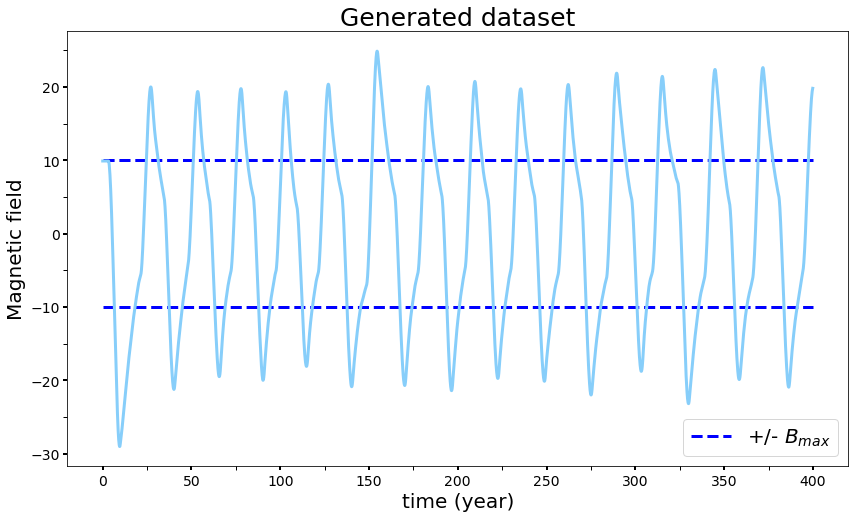

In [8]:
dt = 0.1
tau_fix = 4
Nd_fix = 9
T_delay_fix = 3.2
sigma_fix = 0.2
B_max_fix = 10
B_i_fix = 0.99*B_max_fix
T_sim_fix = 400

t, B = SDDE_simulate(dt = dt, tau = tau_fix, Nd = Nd_fix, T_delay = T_delay_fix, T_sim = T_sim_fix, sigma = sigma_fix, B_max = B_max_fix, B_i = B_i_fix, title = "Generated dataset")

Looking to the shape of the wave we can set some unbiased intervals for $\bar{\theta}$ as our prior:
- A priori, from the dynamo model construction, all the parameters need to be positive;
- the time parameters $\tau$ and $T_{delay}$ has to be surely less than a single oscillation time, indeed about $20$ years;
- dynamo number $\mathcal{N}$, from previous simulations, seems to be surely less than $20$;
- magnetic threshold $B_{max}$ has to be less than the dataset highest peak, again about $20$;
- noise amplitude $\sigma$ is surely less than $1$, indeed $\sigma B_{max} << 20$.

The easiest thing is to build the log-prior $\mathcal{L}(\bar{\theta})$ as follows, and then compute the log-posterior as $\mathcal{L}(\bar{\theta}|B) \simeq \mathcal{L}(B|\bar{\theta}) + \mathcal{L}(\bar{\theta})$ unless an additive constant (the evidence).

In [9]:
def log_prior(theta):
    tau, Nd, T_delay, sigma, B_max = theta
    if 0 < tau < 20 and 0 < Nd < 20 and 0 < T_delay < 20 and 0 < sigma < 1 and 0 < B_max < 20:
        return 0.0
    return -np.inf

In [10]:
def log_posterior(theta, B, dt):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, B, dt)

Given the full path $B_{0},...,B_N$, we can compute the most probable set of parameters $\bar{\theta}^*$ trying to maximize the log-posterior distribution $\mathcal{L}(\bar{\theta}|B)$. For this purpose we used a minimization algorithm called `differential evolution` to minimize the reversed log-posterior ($- \mathcal{L}(\bar{\theta}|B)$).

The `optimize.differential_evolution` method of the `Scipy` library finds the global minimum of a multivariate function using the strategy of **Differential Evolution**, a stochastic method which does not rely on gradient.
Here the [reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) of the library. 

In [11]:
def log_likelihood_minimization(theta, B, dt): # searching for the minima of  -log_likelihood
    return -log_likelihood(theta, B, dt)

def log_posterior_minimization(theta, B, dt): # searching for the minima of  -log_posterior
    return -log_posterior(theta, B, dt)

### Reversed log-posterior minimization

In [12]:
from scipy.optimize import differential_evolution

bounds = [(0,20),(0,20),(0,20),(0,1),(0,20)]

minimum = differential_evolution(log_posterior_minimization, bounds, args = (B, dt), mutation = (0,1.5), popsize=100, maxiter=10000)

In [13]:
tau, Nd, T_delay, sigma, B_max = minimum.x

df_theta_min = pd.DataFrame({r'$\tau$': minimum.x[0],
                   r'$\mathcal{N}$': minimum.x[1],
                   r'$T_{delay}$': minimum.x[2],
                   r"$\sigma$": minimum.x[3],
                   r"$B_{max}$": minimum.x[4]}, index=[r"$\theta_{min}$"])

df_theta_min

$\tau$  $\mathcal{N}$  $T_{delay}$  $\sigma$  $B_{max}$
$\theta_{min}$  4.002448       8.967863     3.274987  0.196971   9.999873

In [14]:
df_log_posterior = pd.DataFrame({r"- log-posterior($\bar{\theta}_{min}$)":[log_posterior_minimization(minimum.x, B, dt)],
                                 r"- log-posterior($\bar{\theta}_{real}$)":[log_posterior_minimization([tau_fix, Nd_fix, T_delay_fix, sigma_fix, B_max_fix], B, dt)]},
                                  index=["- log-posterior values"])

df_log_posterior.round(3)

- log-posterior($\bar{\theta}_{min}$)  \
- log-posterior values                             -13632.817   

                        - log-posterior($\bar{\theta}_{real}$)  
- log-posterior values                              -13631.376

It can be seen that the minimum of the reversed log-posterior corresponds to the parameters with which the data was generated. It can even be observed that the height of $-\mathcal{L}(\bar{\theta}_{min}|B)$ is lower than $-\mathcal{L}(\bar{\theta}_{real}|B)$. This is fair, since due to stochasticity the minimum can be slightly different from the expectations.

In [15]:
t, B_sim = SDDE_simulate(dt = dt, tau = tau, Nd = Nd, T_delay = T_delay, T_sim = T_sim_fix, sigma = sigma, B_max = B_max, B_i = B_i_fix, rs = 427367, flag = False)

Due to the fact that the integration is a stochastic process, the prediction on the trajectory may be not so accurate. We can see below how, after at most one or two cycles, the two waves start to be out of phase one from the other.

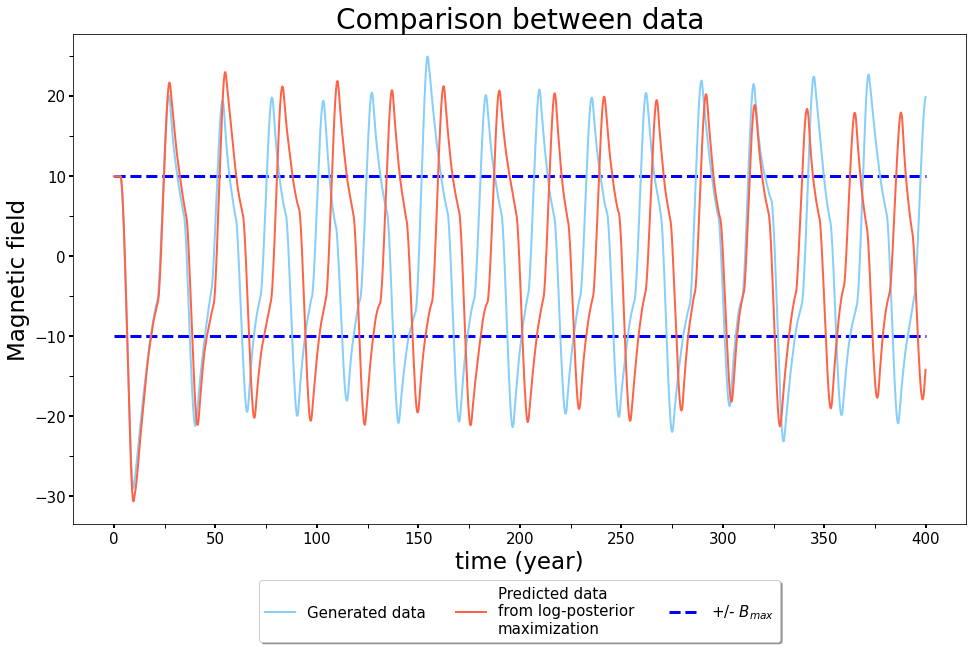

In [16]:
# comparison plot
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(t, B, color="lightskyblue", linewidth=2, label ="Generated data") 
ax.plot(t, B_sim, color = "tomato", linewidth=2, label = "Predicted data \nfrom log-posterior \nmaximization")
ax.set_title("Comparison between data", fontsize=28)
ax.set_xlabel('time (year)', fontsize = 23)
ax.set_ylabel('Magnetic field', fontsize = 23)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(which='major',labelsize=15, length=4, width=2, color='black')
ax.tick_params(which='minor',labelsize=15, length=4, width=1, color='black')
ax.hlines(B_max, 0, t[-1], colors = 'blue', linestyles = 'dashed', label="+/- $B_{max}$",linewidth=3) # thresholds at B_max and -B_max
ax.hlines(-B_max, 0, t[-1], colors = 'blue', linestyles = 'dashed',linewidth=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3, fontsize=15)

### Reversed log-posterior plots

It's interesting to check the projections of the reversed log-posterior $- \mathcal{L}(\bar{\theta}|B)$ with respect to every parameter at once, keeping fixed all the others to the values found in the minimization.  

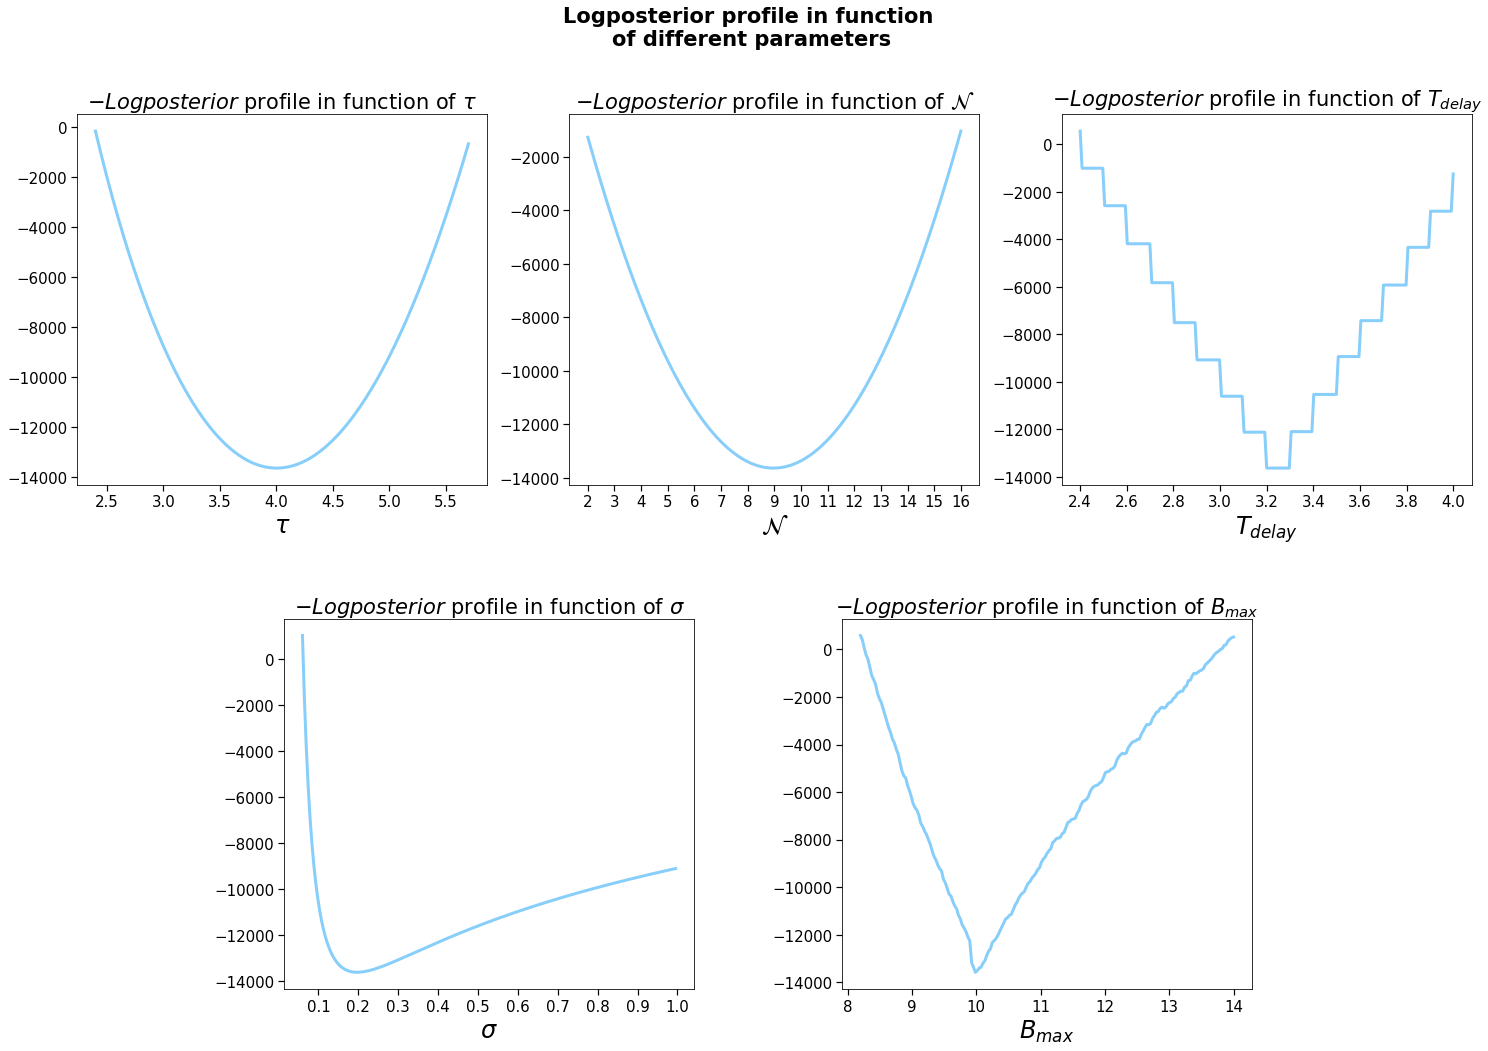

In [17]:
fig, axes = plt.subplots(2,3, figsize=(25,15))
fig.suptitle('Logposterior profile in function \nof different parameters',fontsize = 21, fontweight="bold" )
axes[1][2].set_visible(False)
axes[1][0].set_position([0.24,0.07,0.228,0.343])
axes[1][1].set_position([0.55,0.07,0.228,0.343])

tau_x = np.linspace(2.4, 5.7, 199)
logposterior_profile_tau = np.zeros_like(tau_x)
for i, elem in enumerate(tau_x):
    logposterior_profile_tau[i] = log_posterior_minimization([elem, Nd, T_delay, sigma, B_max], B, dt)
axes[0][0].plot(tau_x, logposterior_profile_tau, linewidth=3, color="lightskyblue")
axes[0][0].set_title(r"$- Log posterior$ profile in function of $\tau$", fontsize=21)
axes[0][0].set_xlabel(r'$\tau$', fontsize = 24, fontweight="bold")
axes[0][0].xaxis.set_major_locator(MultipleLocator(0.5))
axes[0][0].yaxis.set_major_locator(MultipleLocator(2000))
axes[0][0].tick_params(which='major',labelsize=15, length=6, width=1.2, color='black')
axes[0][0].tick_params(which='minor',labelsize=15, length=3, width=1, color='grey')

#################################################################################################################################

Nd_x = np.linspace(2, 16, 199)
logposterior_profile_Nd = np.zeros_like(Nd_x)
for i, elem in enumerate(Nd_x):
    logposterior_profile_Nd[i] = log_posterior_minimization([tau, elem, T_delay, sigma, B_max], B, dt)
axes[0][1].plot(Nd_x, logposterior_profile_Nd, linewidth=3,color="lightskyblue")
axes[0][1].set_title(r"$- Log posterior$ profile in function of $\mathcal{N}$", fontsize=21)
axes[0][1].set_xlabel(r'$\mathcal{N}$', fontsize = 24, fontweight="bold")
axes[0][1].xaxis.set_major_locator(MultipleLocator(1))
axes[0][1].yaxis.set_major_locator(MultipleLocator(2000))
axes[0][1].tick_params(which='major',labelsize=15, length=6, width=1.2, color='black')
axes[0][1].tick_params(which='minor',labelsize=15, length=3, width=1, color='grey')

#################################################################################################################################

T_delay_x = np.linspace(2.4, 4, 199)
logposterior_profile_T = np.zeros_like(T_delay_x)
for i, elem in enumerate(T_delay_x):
    logposterior_profile_T[i] = log_posterior_minimization([tau, Nd, elem, sigma, B_max], B, dt)
axes[0][2].plot(T_delay_x, logposterior_profile_T,linewidth=3,color="lightskyblue")
axes[0][2].set_title(r"$- Log posterior$ profile in function of $T_{delay}$", fontsize=21)
axes[0][2].set_xlabel(r'$T_{delay}$', fontsize = 24, fontweight="bold")
axes[0][2].xaxis.set_major_locator(MultipleLocator(0.2))
axes[0][2].yaxis.set_major_locator(MultipleLocator(2000))
axes[0][2].tick_params(which='major',labelsize=15, length=6, width=1.2, color='black')
axes[0][2].tick_params(which='minor',labelsize=15, length=3, width=1, color='grey')

###############################################################################################################################

sigma_x = np.linspace(0.06, 1, 199)
logposterior_profile_sigma = np.zeros_like(sigma_x)
for i, elem in enumerate(sigma_x):
    logposterior_profile_sigma[i] = log_posterior_minimization([tau, Nd, T_delay, elem, B_max], B, dt)
axes[1][0].plot(sigma_x, logposterior_profile_sigma,linewidth=3,color="lightskyblue")
axes[1][0].set_title(r"$- Log posterior$ profile in function of $\sigma$", fontsize=21)
axes[1][0].set_xlabel(r'$\sigma$', fontsize = 24, fontweight="bold") 
axes[1][0].xaxis.set_major_locator(MultipleLocator(0.1))
axes[1][0].yaxis.set_major_locator(MultipleLocator(2000))
axes[1][0].tick_params(which='major',labelsize=15, length=6, width=1.2, color='black')
axes[1][0].tick_params(which='minor',labelsize=15, length=3, width=1, color='grey')

###############################################################################################################################

B_max_x = np.linspace(8.2, 14, 199)
logposterior_profile_B = np.zeros_like(B_max_x)
for i, elem in enumerate(B_max_x):
    logposterior_profile_B[i] = log_posterior_minimization([tau, Nd, T_delay, sigma, elem], B, dt) 
axes[1][1].plot(B_max_x, logposterior_profile_B, linewidth=3, color="lightskyblue")
axes[1][1].set_title(r"$- Log posterior$ profile in function of $B_{max}$", fontsize=21)
axes[1][1].set_xlabel(r'$B_{max}$', fontsize = 24, fontweight="bold")
axes[1][1].xaxis.set_major_locator(MultipleLocator(1))
axes[1][1].yaxis.set_major_locator(MultipleLocator(2000))
axes[1][1].tick_params(which='major',labelsize=15, length=6, width=1.2, color='black')
axes[1][1].tick_params(which='minor',labelsize=15, length=3, width=1, color='grey')

The plots are obtained by varying the logarithm of the posterior density function as a function of only one parameter at a time; it can be observed that the minima are found in the values corresponding to those with which the data were generated.
Furthermore, it can be observed that the logarithm of the posterior density function as a function of $T_{delay}$ is not continuous and is stepped; however, this is consistent in that time has been discretized in the discussion.

### MCMC of the posterior distribution

Some variance estimation for the minima/maxima collected in the previous section can be done through posterior sampling, using MCMC techniques. In our case we made use of `emcee` library.

`emcee` is a stable, well tested Python implementation of the affine-invariant ensemble sampler for **Markov chain Monte Carlo (MCMC)** proposed by [Goodman & Weare (2010)](https://cims.nyu.edu/~weare/papers/d13.pdf).

MCMC is a method highly useful for the practice of inference.
What MCMC really shines at is in being able to sample from the posterior distribution around those optimum values in order to generatively model the data.
The fundamental process of running an MCMC in this mode is to compare generated models against data. Those models are generated by a set of parameters, and our goal is usually to sample from the set of parameters that produces the models that well-fit our data.
The `emcee` package has been used following this [instructions](https://emcee.readthedocs.io/en/stable/).

100%|██████████| 5000/5000 [26:19<00:00,  3.17it/s]


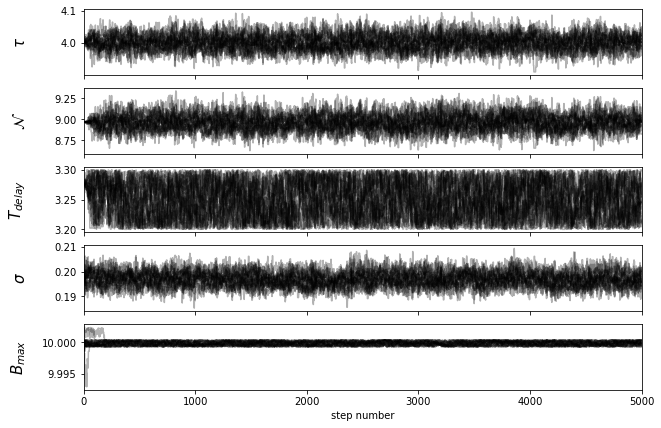

In [18]:
!pip install emcee

import emcee

pos = minimum.x + 1e-3 * np.random.randn(20, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(B, dt))
sampler.run_mcmc(pos, 5000, progress=True);

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\tau$", r"$\mathcal{N}$", r"$T_{delay}$", r"$\sigma$", r"$B_{max}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize = 15)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [19]:
flat_samples = sampler.get_chain(discard=200, thin=20, flat=True)
print(flat_samples.shape)

(4800, 5)


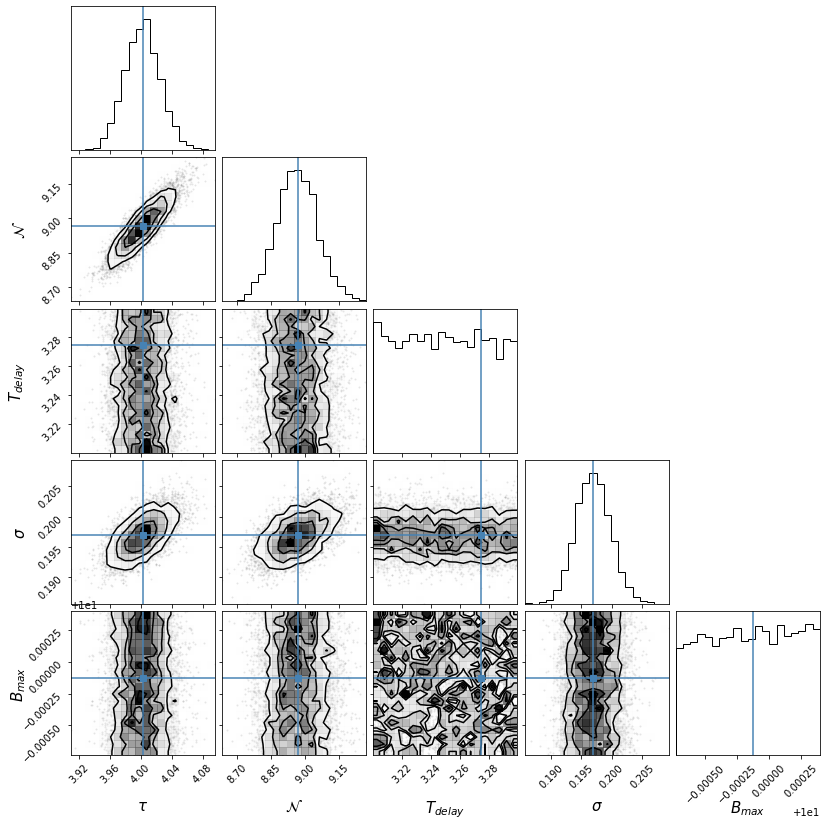

In [20]:
!pip install corner

import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=minimum.x, label_kwargs={"fontsize": 15}
);

### Marginalized distributions of the parameters

In [25]:
from scipy.stats import norm

def histogram(array, Title, true_mode, binning, majx, minx):
    fig, ax = plt.subplots(1,1 , figsize=(25, 10))
    m = array.min()
    M = array.max()
    N = len(array)
    spc = (M-m)/50 # nbins is 50
    #spc = binning/N
    ax.set_axisbelow(True)
    ax.grid(axis='y',linewidth=1,zorder=-1.0)
    a = ax.hist(array, bins=np.arange(m, M, spc), color='lightskyblue',edgecolor="darkblue",alpha=1)
    
    counts = a[0]
    edges = a[1]
    patches = a[2]
    tmp = np.cumsum(np.diff(edges)*counts)
    ntot_counts = np.sum(counts)
    sorted_array = np.sort(array)
    ci_array = sorted_array[int(0.025*ntot_counts):int(0.975*ntot_counts)]
    x_min = ci_array[0]
    x_max = ci_array[-1]
    
    #ci = norm(*norm.fit(array)).interval(0.95)
    ax.fill_betweenx([0, counts.max()], x_min, x_max, color='palegreen', alpha=0.5, label="credibility interval")
    
    ax.set_title(Title, fontsize=40)
    median = np.median(array,axis = None)
    ax.axvline(median, ymax = counts.max(), color ="blue", label="median = {:.3f}".format(median), linewidth=5, linestyle="dotted")
    ax.axvline(true_mode, ymax = counts.max(), color ="mediumblue", label="global max = {:.3f}".format(true_mode),linewidth=5, linestyle="dashdot")
    ax.legend(loc="best",prop={'size': 25})
    ax.set_ylabel("Counts",fontsize=25)
    ax.set_xlabel("Values",fontsize=25)
    ax.xaxis.set_major_locator(MultipleLocator(majx))
    ax.xaxis.set_minor_locator(MultipleLocator(minx))
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(which='minor', length=3, width=1, color='grey', labelsize = 20)
    ax.tick_params(which='major', length=6, width=1.2, color='black', labelsize = 20)
    #ax.grid(axis='y',linewidth=2)
    return [x_min, x_max]

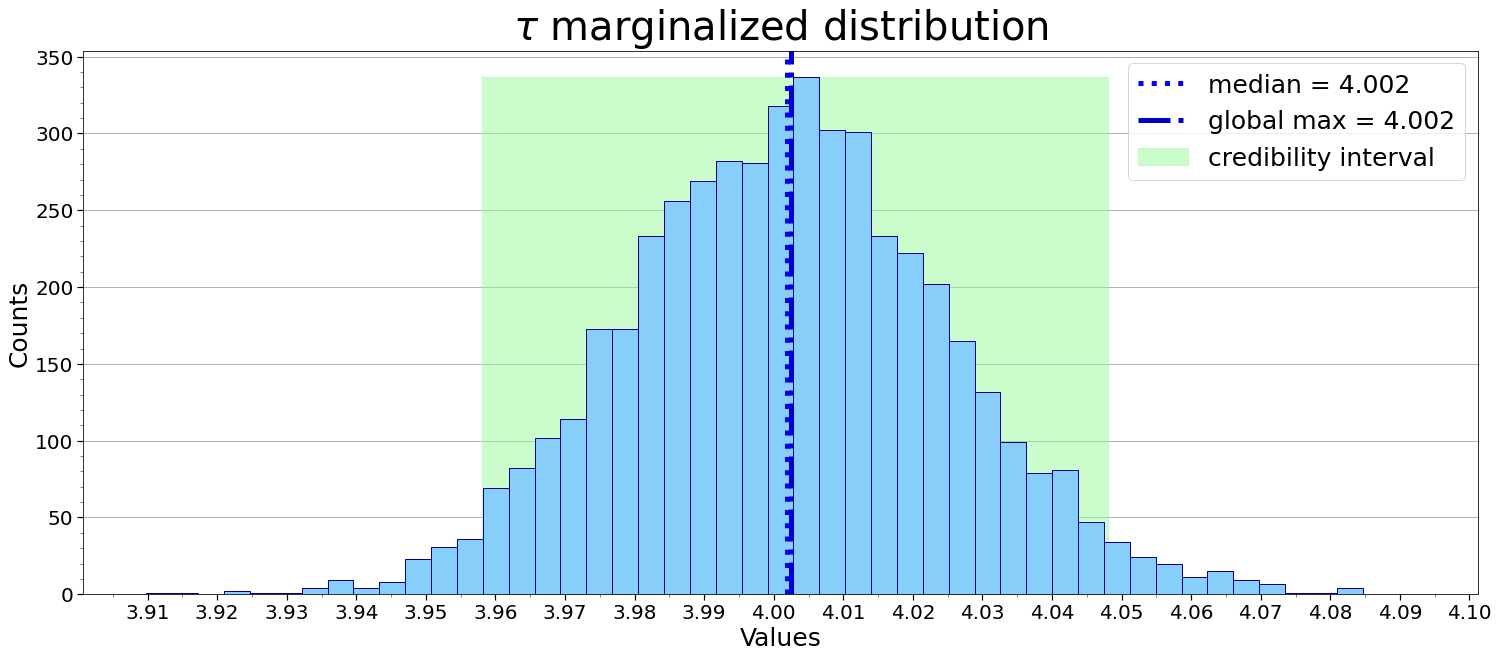

In [26]:
tau_hist = np.concatenate([a for a in flat_samples[:,0]], axis=None)
ci_tau = histogram(tau_hist, r"$\tau$ marginalized distribution", tau, 1500, 0.01, 0.005)

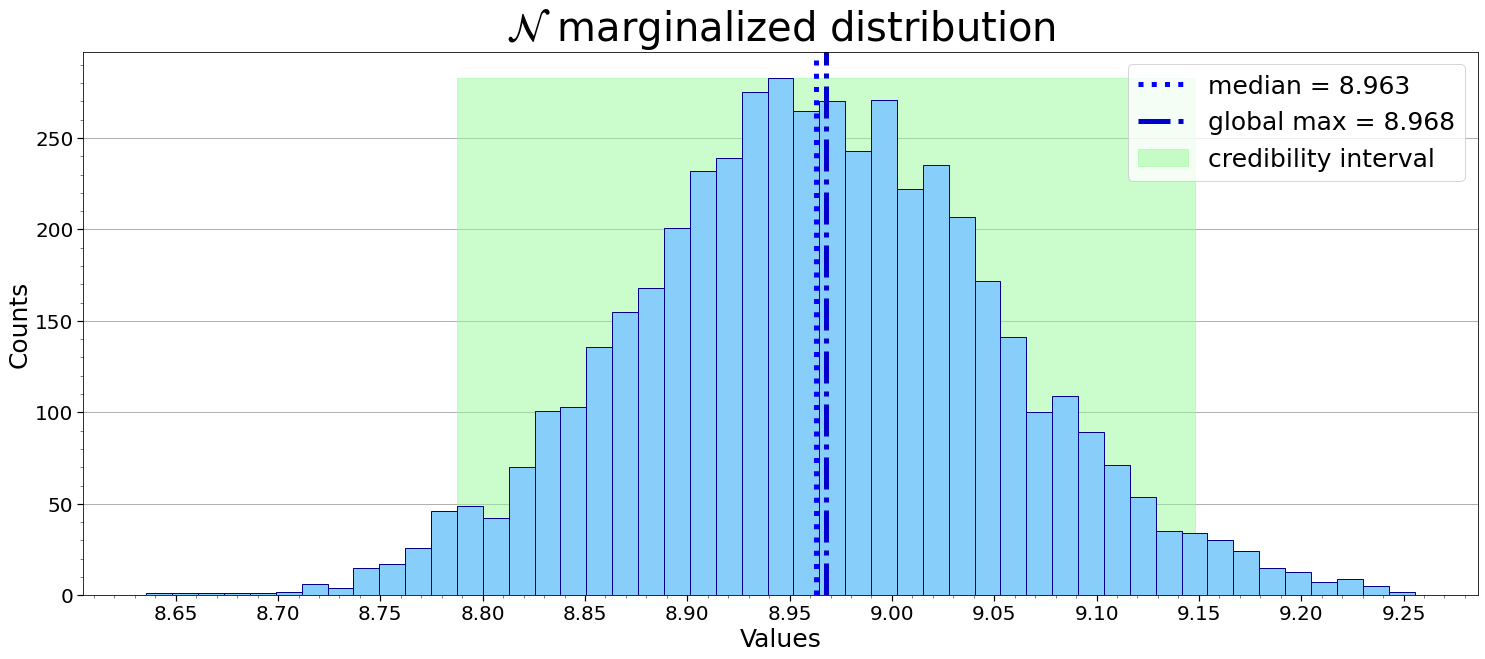

In [27]:
Nd_hist = np.concatenate([a for a in flat_samples[:,1]], axis=None)
ci_Nd = histogram(Nd_hist,r"$\mathcal{N}$ marginalized distribution", Nd, 1500, 0.05, 0.01 )

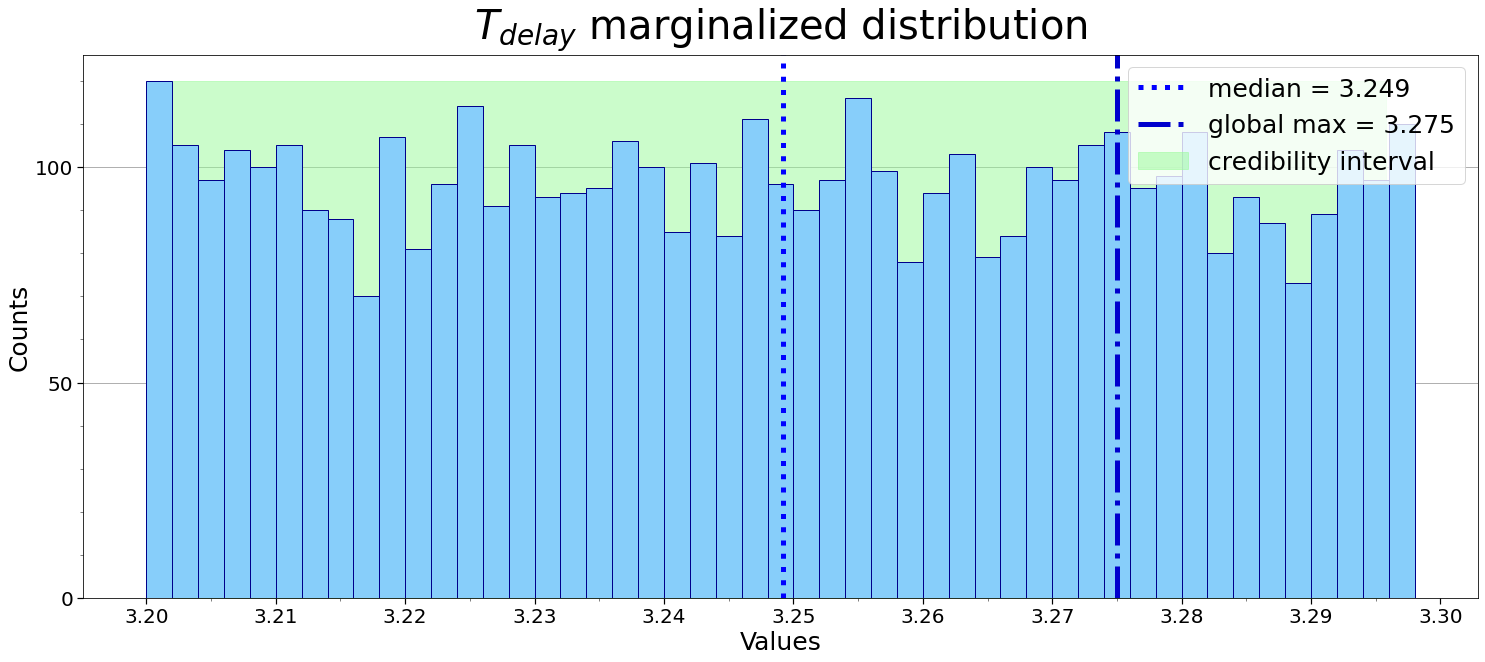

In [28]:
T_delay_hist = np.concatenate([a for a in flat_samples[:,2]], axis=None)
ci_T_delay = histogram(T_delay_hist, r"$T_{delay}$ marginalized distribution", T_delay, 1500, 0.01, 0.005)

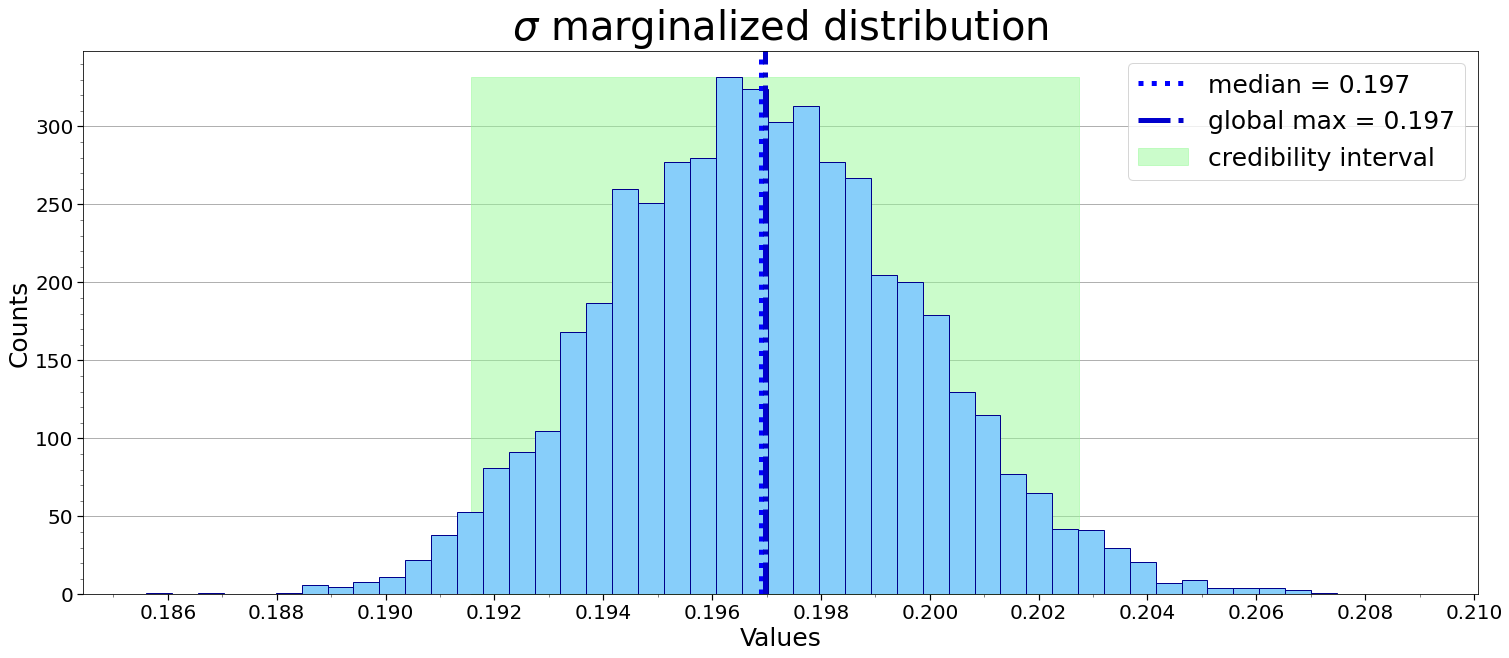

In [31]:
sigma_hist = np.concatenate([a for a in flat_samples[:,3]], axis=None)
ci_sigma = histogram(sigma_hist,r"$\sigma$ marginalized distribution", sigma, 80, 0.002, 0.001)

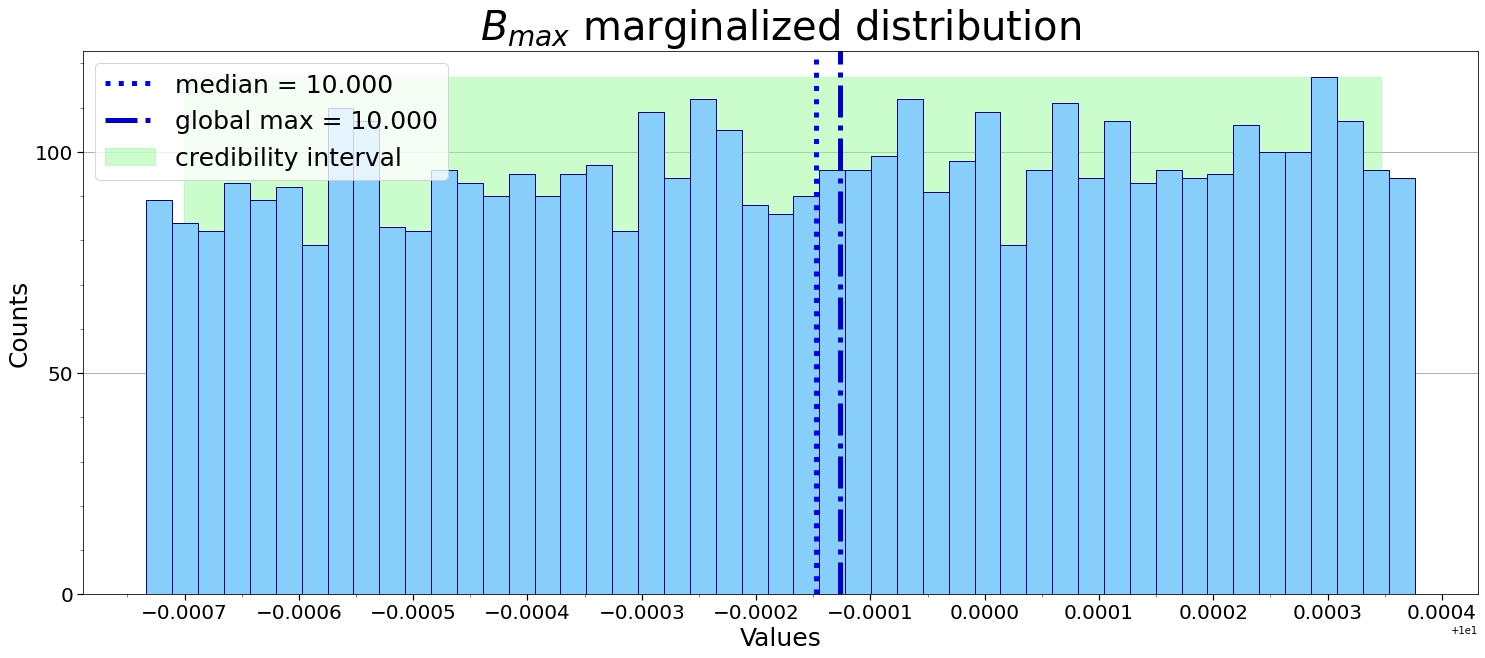

In [33]:
B_max_hist = np.concatenate([a for a in flat_samples[:,4]], axis=None)
ci_B_max = histogram(B_max_hist, r"$B_{max}$ marginalized distribution", B_max, 1500, 0.0001, 0.00005)

In [34]:
def round_list(list):
    rounded_list = []
    for i in list:
        rounded_list.append(round(i,3))
    return rounded_list

In [35]:
d = {'Values': [tau, Nd, T_delay, sigma, B_max], 'Credibility Intervals': [round_list(ci_tau), round_list(ci_Nd), round_list(ci_T_delay), round_list(ci_sigma), round_list(ci_B_max)]}
df = pd.DataFrame(data=d, index=[r'$\tau$', r'$\mathcal{N}$', r'$T_{delay}$', r"$\sigma$", r"$B_{max}$"]).round(3)
df.round(3)

Values Credibility Intervals
$\tau$          4.002        [3.958, 4.048]
$\mathcal{N}$   8.968        [8.787, 9.148]
$T_{delay}$     3.275        [3.202, 3.296]
$\sigma$        0.197        [0.192, 0.203]
$B_{max}$      10.000         [9.999, 10.0]

It can be observed in general that global maximum coordinates and medians assume values close to each other, and the credibility intervals are well defined around these values.
In particular, it is observed that the marginalized distribution associated with $B_{max}$ is very small.
It can also be seen that the distribution relative to $T_{delay}$ is much flatter and wider. This is not unexpected: remembering the plot of the logarithm of the posterior density function obtained by varying a single parameter, we observe that with respect to the $T_{delay}$ parameter, the minimum actually corresponds to a range of values.

## Real data inference

Real dataset is obtained from the record of the number of sunspots evaluated monthly, from approximately $1750$ to $2020$. To extrapolate a measure of the magnetic field evolving in time, square root of the $\#\ \mbox{of sunspots}$ was taken, and periodical inversion of the field was artificially added. The resulting trajectory can be seen below.

<Figure size 1008x576 with 0 Axes>

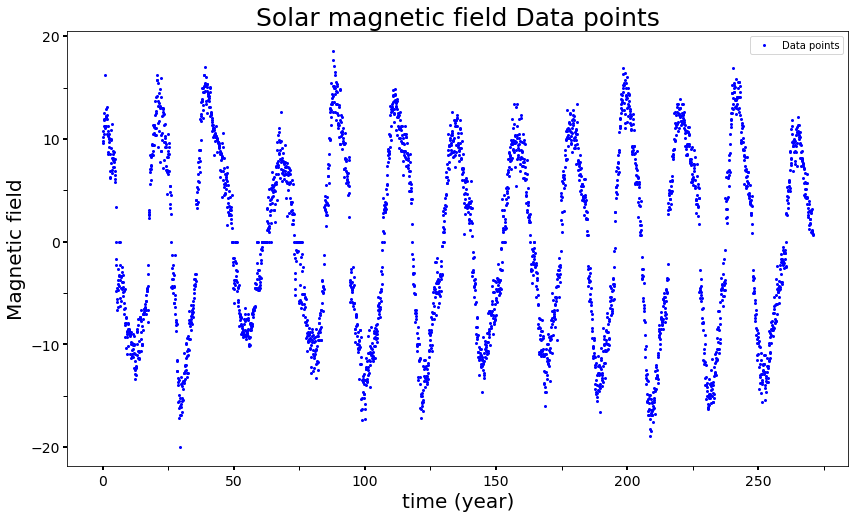

In [36]:
plt.figure(figsize = (14,8))

dt = 1/12
data = np.loadtxt("bfield_from_sunspots.dat")
time = dt*np.arange(len(data))


fig, ax = plt.subplots()
ax.plot(time, data,'o', color = "blue",markersize=2, label = "Data points")
    
ax.set_title("Solar magnetic field Data points", fontsize=25)
ax.set_xlabel('time (year)', fontsize = 20)
ax.set_ylabel('Magnetic field', fontsize = 20)
    
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
    
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
   
ax.tick_params(which='major',labelsize=14, length=4, width=2, color='black')
ax.tick_params(which='minor',labelsize=14, length=4, width=1, color='black')
ax.legend()

Again, we carry out a MAP procedure (but in practice of minimization, since all the algortms work more easily in finding minimums of functions rather than maximums) to identify the values corresponding to the maximum of the posterior probability density function.

In [40]:
bounds = [(0,20),(0,20),(0,20),(0,1),(0,20)]

minimum = differential_evolution(log_posterior_minimization, bounds, args = (data, dt), mutation = (0,1.5), popsize=100, maxiter=10000)
# , x0 = [0.123, 1, 10.8, 0.15, 12]
tau_fix, Nd_fix, T_delay_fix, sigma_fix, B_max_fix = minimum.x

C:\Users\stefa\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [42]:
df_theta_min = pd.DataFrame({r'$\tau$': [minimum.x[0]],
                   r'$\mathcal{N}$': [minimum.x[1]],
                   r'$T_{delay}$': [minimum.x[2]],
                   r"$\sigma$":[minimum.x[3]],
                   r"$B_{max}$":[minimum.x[4]]}, index=[r"$\theta_{min}$"])

df_theta_min

$\tau$  $\mathcal{N}$  $T_{delay}$  $\sigma$  $B_{max}$
$\theta_{min}$  0.189922       0.888298    10.540638  0.315978  19.516245

In [43]:
df_log_posterior = pd.DataFrame({r"- log-posterior($\bar{\theta}$)":[log_posterior_minimization(minimum.x, data, dt)]},index=[""])
df_log_posterior.round(3) 

- log-posterior($\bar{\theta}$)
                         6255.662

In [44]:
t, B_sim_0 = SDDE_simulate(dt = dt, tau = tau_fix, Nd = Nd_fix, T_delay = T_delay_fix, T_sim = len(data)*dt, sigma = sigma_fix , B_max = B_max_fix, B_i = data[:(int(T_delay_fix/dt)+2)], flag = False)

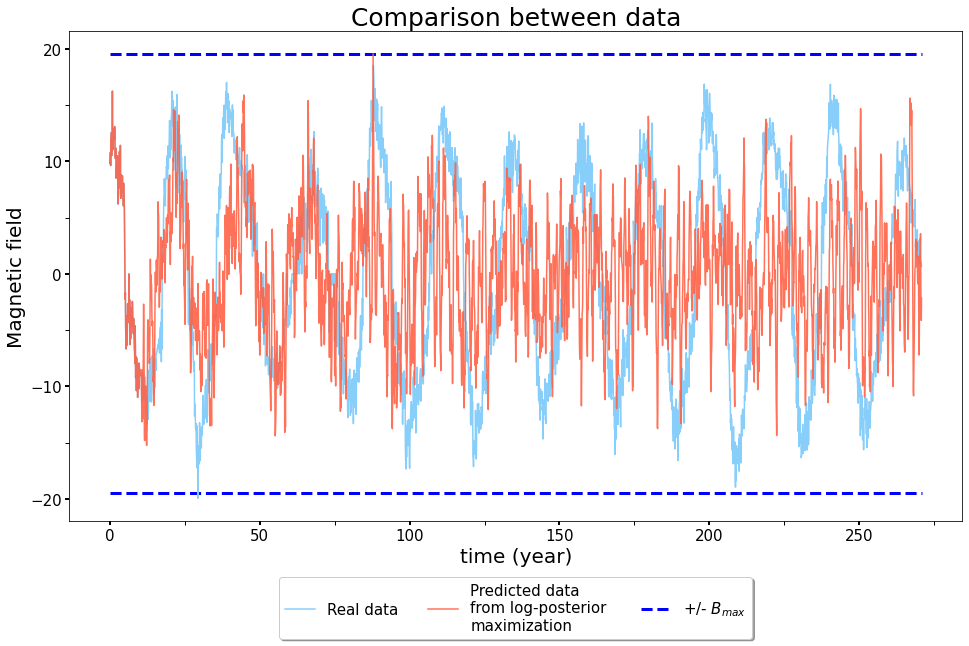

In [45]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(t, data, color="lightskyblue",linewidth=1.5, label ="Real data")
ax.plot(t, B_sim_0, color = "tomato", linewidth=1.5, label="Predicted data \nfrom log-posterior \nmaximization", alpha = 0.9)
ax.set_title("Comparison between data", fontsize=25)
ax.set_xlabel('time (year)', fontsize = 20)
ax.set_ylabel('Magnetic field', fontsize = 20)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(which='major',labelsize=15, length=4, width=2, color='black')
ax.tick_params(which='minor',labelsize=15, length=4, width=1, color='black')
ax.hlines(B_max_fix, 0, t[-1], colors = 'blue', linestyles = 'dashed', label="+/- $B_{max}$",linewidth=3) # thresholds at B_max and -B_max
ax.hlines(-B_max_fix, 0, t[-1], colors = 'blue', linestyles = 'dashed',linewidth=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3, fontsize=15)

It can be observed that for the first few cycles the prediction captures the period of the data, even if its amplitude is generally lower than the real one. It is also seen that after the first few periods the prediction becomes much noisier. This is partly expected as the extent of stochasticity increases with time in stochastic processes.

However, the reason why the stochastic part is so dominant is that, for such low dynamo numbers, the wave that would be obtained without noise (therefore only the deterministic evolution) tends to decrease in amplitude over time to almost zero.

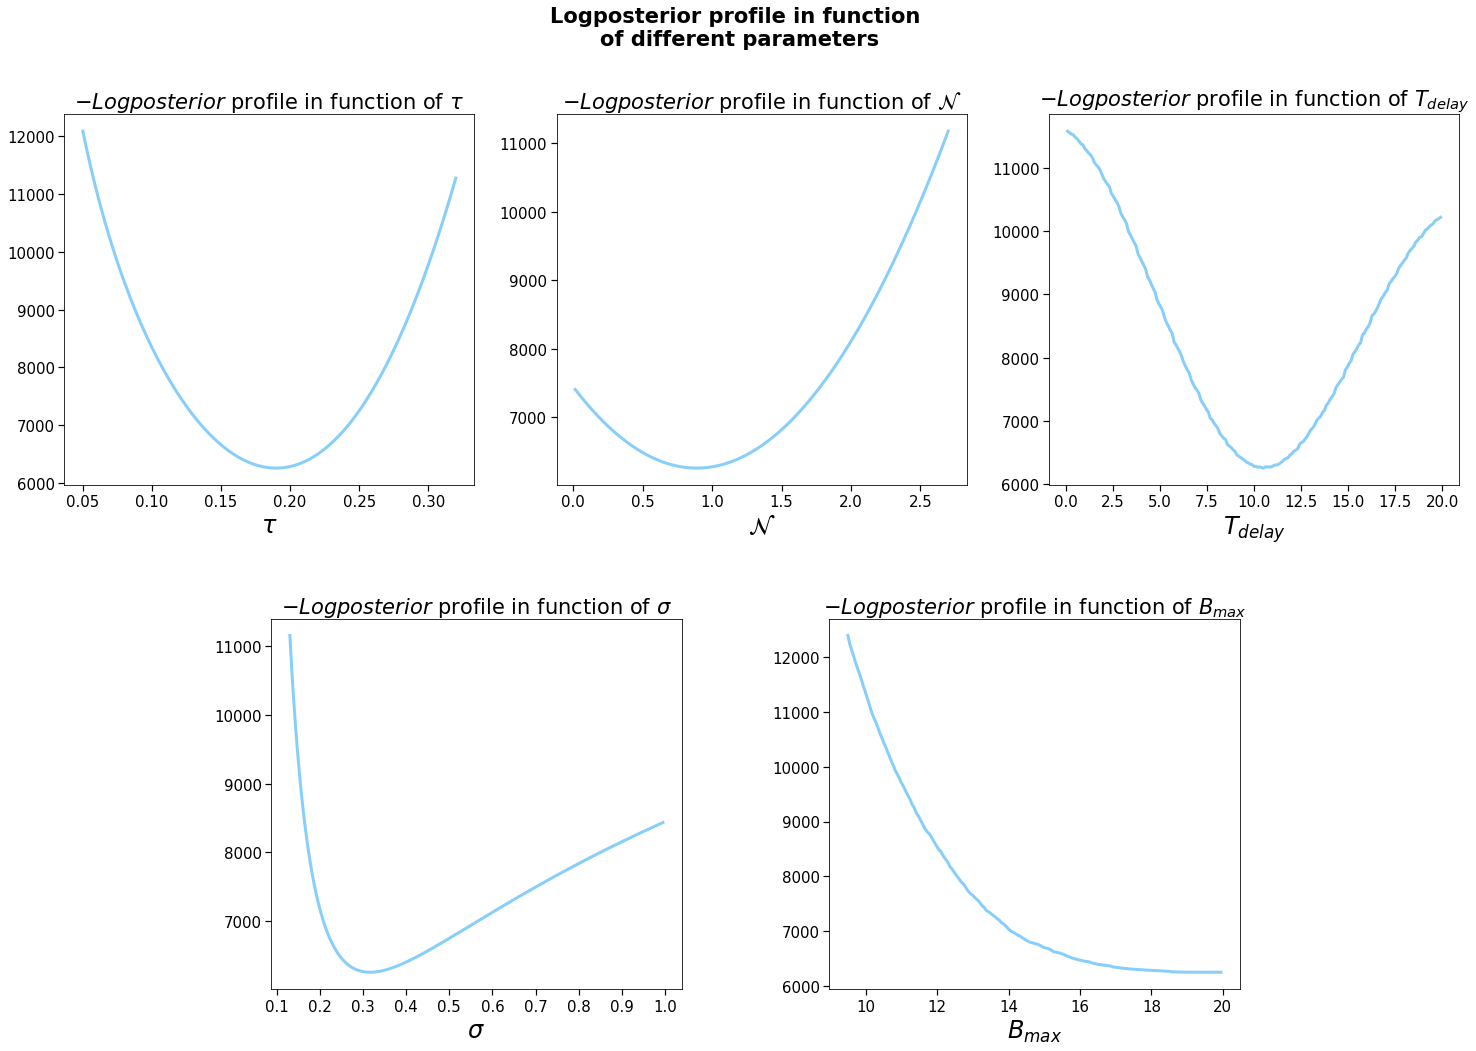

In [46]:
fig, axes = plt.subplots(2,3, figsize=(25,15))
fig.suptitle('Logposterior profile in function \nof different parameters',fontsize = 21, fontweight="bold" )
axes[1][2].set_visible(False)
axes[1][0].set_position([0.24,0.07,0.228,0.343])
axes[1][1].set_position([0.55,0.07,0.228,0.343])

tau_x = np.linspace(0.05, 0.32, 199)
logposterior_profile_tau = np.zeros_like(tau_x)
for i, elem in enumerate(tau_x): 
    logposterior_profile_tau[i] = log_posterior_minimization([elem, Nd_fix, T_delay_fix, sigma_fix, B_max_fix], data, dt)
axes[0][0].plot(tau_x, logposterior_profile_tau, linewidth=3, color="lightskyblue")
axes[0][0].set_title(r"$- Log posterior$ profile in function of $\tau$", fontsize=21)
axes[0][0].set_xlabel(r'$\tau$', fontsize = 24, fontweight="bold")
#axes[0][0].set_ylabel('Log_posterior', fontsize = 22) 
axes[0][0].xaxis.set_major_locator(MultipleLocator(0.05))
#axes[0][0].xaxis.set_minor_locator(MultipleLocator(0.1))
axes[0][0].yaxis.set_major_locator(MultipleLocator(1000))
#axes[0][0].yaxis.set_minor_locator(MultipleLocator(500))
axes[0][0].tick_params(which='major',labelsize=15, length=6, width=1.2, color='black')
axes[0][0].tick_params(which='minor',labelsize=15, length=3, width=1, color='grey')

#################################################################################################################################

Nd_x = np.linspace(0, 2.7, 199)
logposterior_profile_Nd = np.zeros_like(Nd_x)
for i, elem in enumerate(Nd_x):
    logposterior_profile_Nd[i] = log_posterior_minimization([tau_fix, elem, T_delay_fix, sigma_fix, B_max_fix], data, dt)
axes[0][1].plot(Nd_x, logposterior_profile_Nd, linewidth=3,color="lightskyblue")
axes[0][1].set_title(r"$- Log posterior$ profile in function of $\mathcal{N}$", fontsize=21)
axes[0][1].set_xlabel(r'$\mathcal{N}$', fontsize = 24, fontweight="bold")
#axes[0][1].set_ylabel('Log_likelihood', fontsize = 20) 
axes[0][1].xaxis.set_major_locator(MultipleLocator(0.5))
#axes[0][1].xaxis.set_minor_locator(MultipleLocator(0.5))
axes[0][1].yaxis.set_major_locator(MultipleLocator(1000))
#axes[0][1].yaxis.set_minor_locator(MultipleLocator(500))
axes[0][1].tick_params(which='major',labelsize=15, length=6, width=1.2, color='black')
axes[0][1].tick_params(which='minor',labelsize=15, length=3, width=1, color='grey')

#################################################################################################################################

T_delay_x = np.linspace(0, 20, 199)
logposterior_profile_T = np.zeros_like(T_delay_x)
for i, elem in enumerate(T_delay_x):
    logposterior_profile_T[i] = log_posterior_minimization([tau_fix, Nd_fix, elem, sigma_fix, B_max_fix], data, dt)
axes[0][2].plot(T_delay_x, logposterior_profile_T,linewidth=3,color="lightskyblue")
axes[0][2].set_title(r"$- Log posterior$ profile in function of $T_{delay}$", fontsize=21)
axes[0][2].set_xlabel(r'$T_{delay}$', fontsize = 24, fontweight="bold")
#axes[0][2].set_ylabel('Log_likelihood', fontsize = 20) 
axes[0][2].xaxis.set_major_locator(MultipleLocator(2.5))
#axes[0][2].xaxis.set_minor_locator(MultipleLocator(0.1))
axes[0][2].yaxis.set_major_locator(MultipleLocator(1000))
#axes[0][2].yaxis.set_minor_locator(MultipleLocator(500))
axes[0][2].tick_params(which='major',labelsize=15, length=6, width=1.2, color='black')
axes[0][2].tick_params(which='minor',labelsize=15, length=3, width=1, color='grey')

###############################################################################################################################

sigma_x = np.linspace(0.13, 1, 199)
logposterior_profile_sigma = np.zeros_like(sigma_x)
for i, elem in enumerate(sigma_x):
    logposterior_profile_sigma[i] = log_posterior_minimization([tau_fix, Nd_fix, T_delay_fix, elem, B_max_fix], data, dt)
axes[1][0].plot(sigma_x, logposterior_profile_sigma,linewidth=3,color="lightskyblue")
axes[1][0].set_title(r"$- Log posterior$ profile in function of $\sigma$", fontsize=21)
axes[1][0].set_xlabel(r'$\sigma$', fontsize = 24, fontweight="bold")
#axes[1][0].set_ylabel('Log_posterior', fontsize = 22)  
axes[1][0].xaxis.set_major_locator(MultipleLocator(0.1))
#axes[1][0].xaxis.set_minor_locator(MultipleLocator(0.1))
axes[1][0].yaxis.set_major_locator(MultipleLocator(1000))
#axes[1][0].yaxis.set_minor_locator(MultipleLocator(500))
axes[1][0].tick_params(which='major',labelsize=15, length=6, width=1.2, color='black')
axes[1][0].tick_params(which='minor',labelsize=15, length=3, width=1, color='grey')

###############################################################################################################################

B_max_x = np.linspace(9.5, 20, 199)
logposterior_profile_B = np.zeros_like(B_max_x)
for i, elem in enumerate(B_max_x):
    logposterior_profile_B[i] = log_posterior_minimization([tau_fix, Nd_fix, T_delay_fix, sigma_fix, elem], data, dt) 
axes[1][1].plot(B_max_x, logposterior_profile_B, linewidth=3, color="lightskyblue")
axes[1][1].set_title(r"$- Log posterior$ profile in function of $B_{max}$", fontsize=21)
axes[1][1].set_xlabel(r'$B_{max}$', fontsize = 24, fontweight="bold")
#ax.set_ylabel('Log_likelihood', fontsize = 20) 
axes[1][1].xaxis.set_major_locator(MultipleLocator(2))
#axes[1][1].xaxis.set_minor_locator(MultipleLocator(0.1))
axes[1][1].yaxis.set_major_locator(MultipleLocator(1000))
#axes[1][1].yaxis.set_minor_locator(MultipleLocator(500))
axes[1][1].tick_params(which='major',labelsize=15, length=6, width=1.2, color='black')
axes[1][1].tick_params(which='minor',labelsize=15, length=3, width=1, color='grey')

It can be observed that the minima that can be identified in the plots correspond approximately to the values found through the minimization process. In particular, regarding $B_{max}$ projection, a wide range of values from $16$ on have pretty the same likeliness. As can be seen below, $B_{max}$ and $\sigma$ are probably anti-correlated, in the sense that is their product that seems to be the relevant quantity characterizing the log-posterior value of the minimum. This is not surprising, because high values of $B_{max}$ make the $f$ function almost always equal to $1$, and so $B_{max}$ enters only paired with $\sigma$.

100%|██████████| 5000/5000 [18:55<00:00,  4.40it/s]


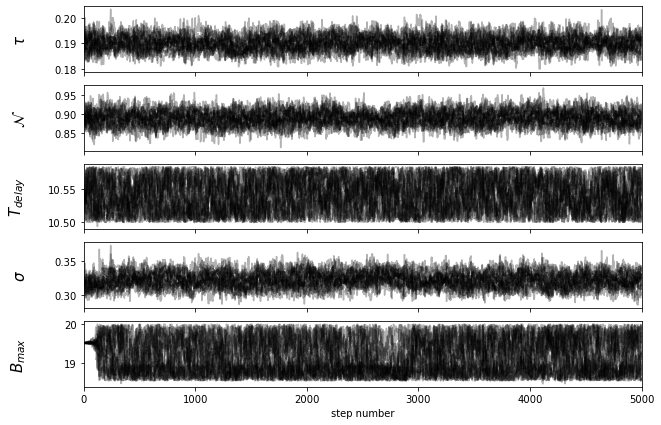

In [47]:
pos = minimum.x + 1e-3 * np.random.randn(20, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, dt))
sampler.run_mcmc(pos, 5000, progress=True);

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\tau$", r"$\mathcal{N}$", r"$T_{delay}$", r"$\sigma$", r"$B_{max}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize = 15)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [48]:
flat_samples_0 = sampler.get_chain(discard=200, thin=20, flat=True)
print(flat_samples.shape)

(4800, 5)


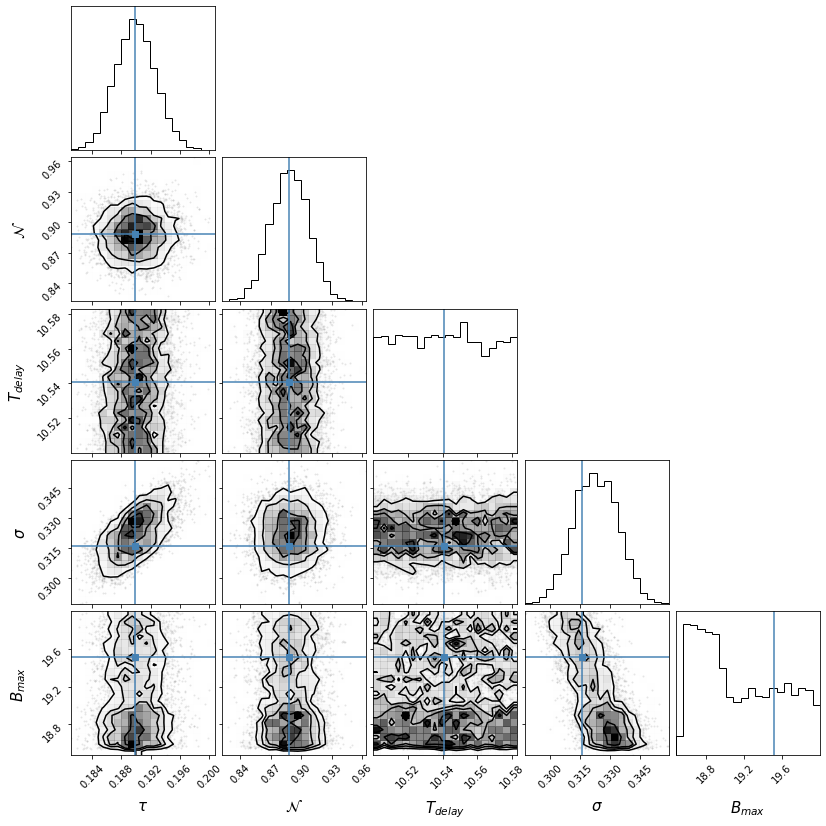

In [49]:
fig = corner.corner(
    flat_samples_0, labels=labels, truths=minimum.x, label_kwargs={"fontsize": 15}
);

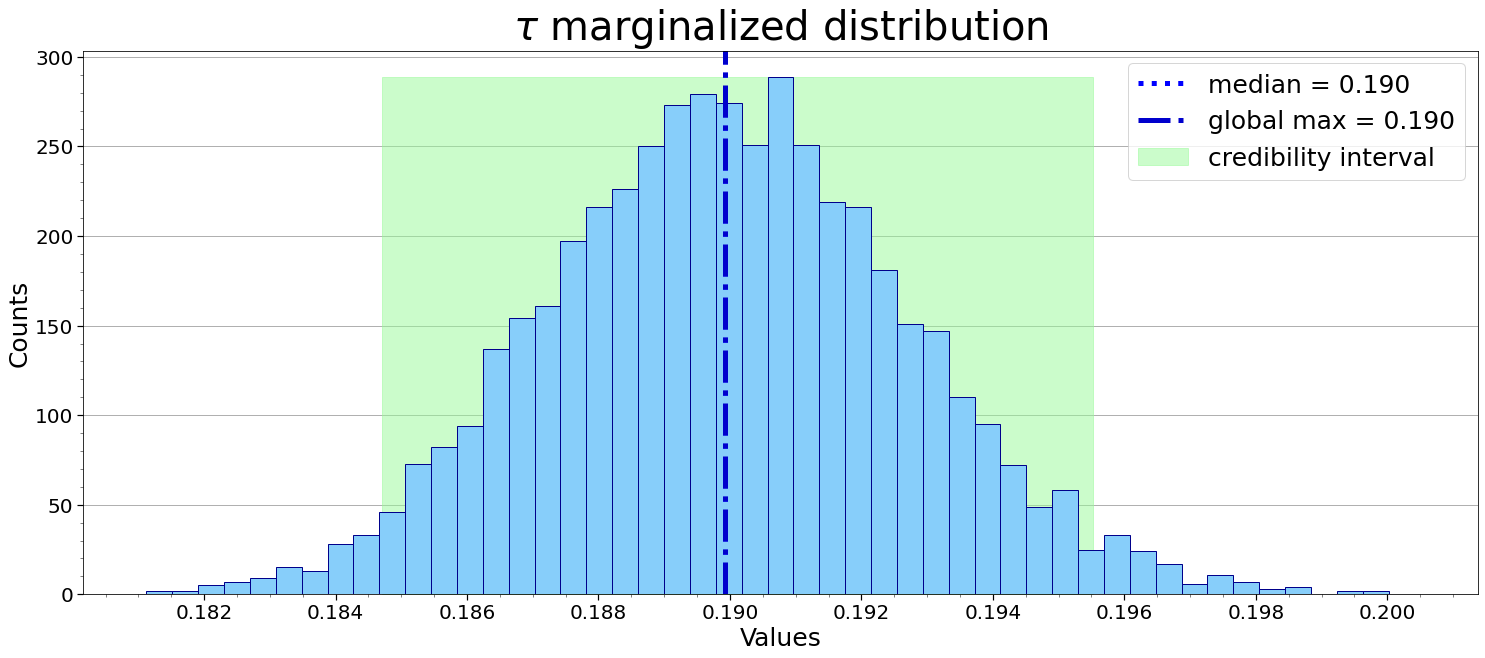

In [51]:
tau_hist = np.concatenate([a for a in flat_samples_0[:,0]], axis=None)
ci_tau = histogram(tau_hist, r"$\tau$ marginalized distribution", minimum.x[0], 1500, 0.002, 0.0005)

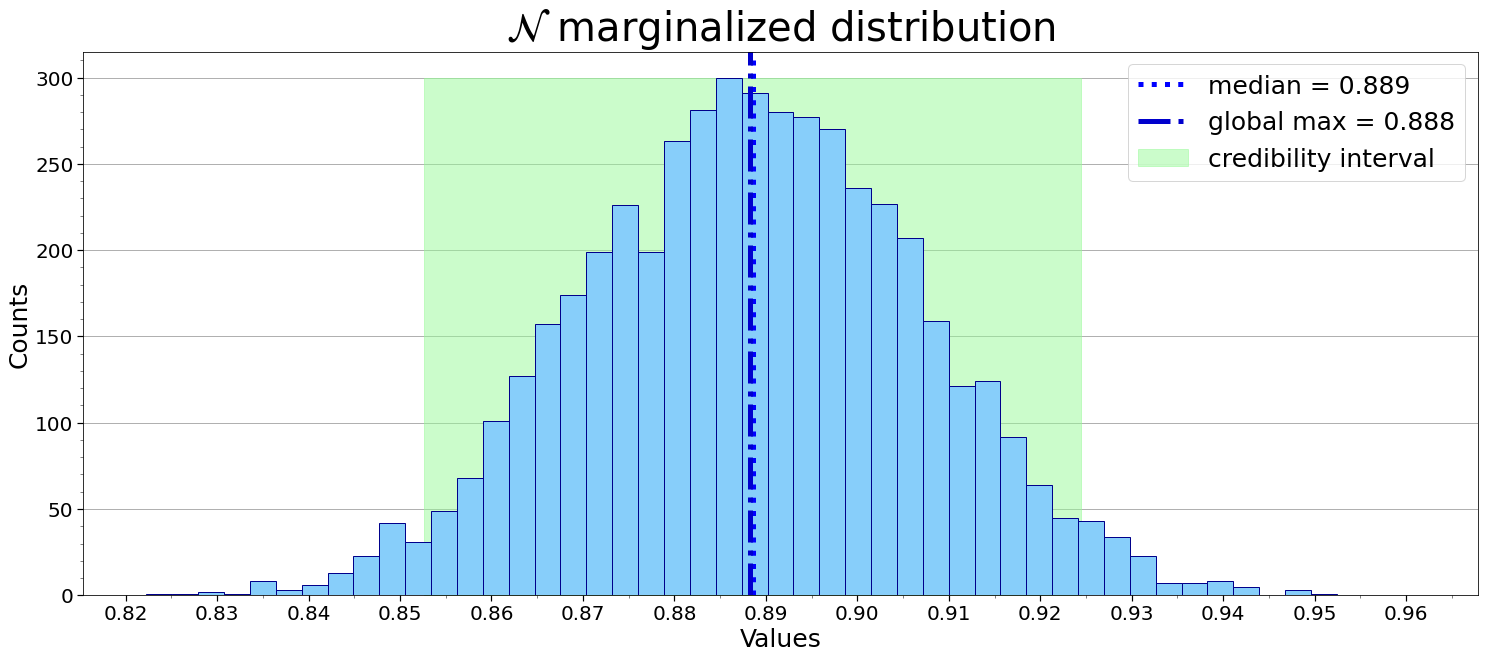

In [52]:
Nd_hist = np.concatenate([a for a in flat_samples_0[:,1]], axis=None)
ci_Nd = histogram(Nd_hist,r"$\mathcal{N}$ marginalized distribution", minimum.x[1], 1500, 0.01, 0.005 )

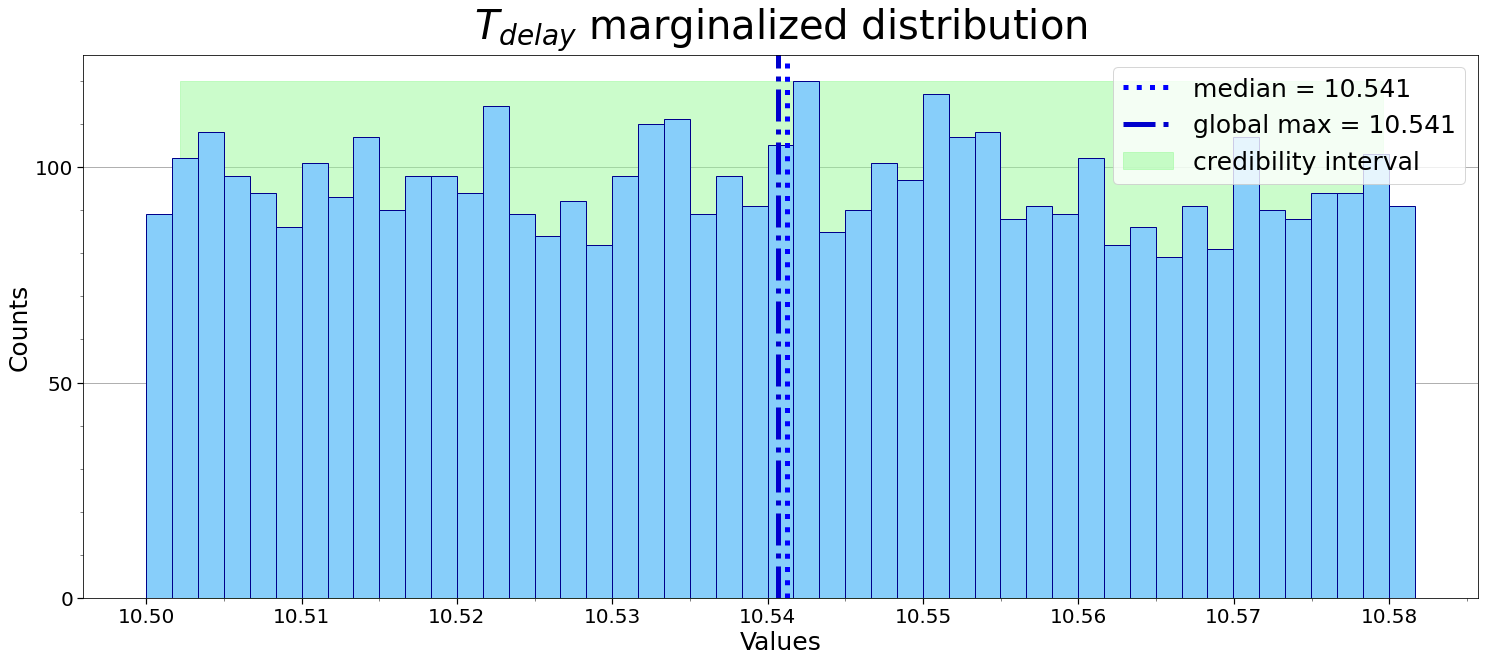

In [53]:
T_delay_hist = np.concatenate([a for a in flat_samples_0[:,2]], axis=None)
ci_T_delay = histogram(T_delay_hist, r"$T_{delay}$ marginalized distribution", minimum.x[2], 1500, 0.01, 0.005)

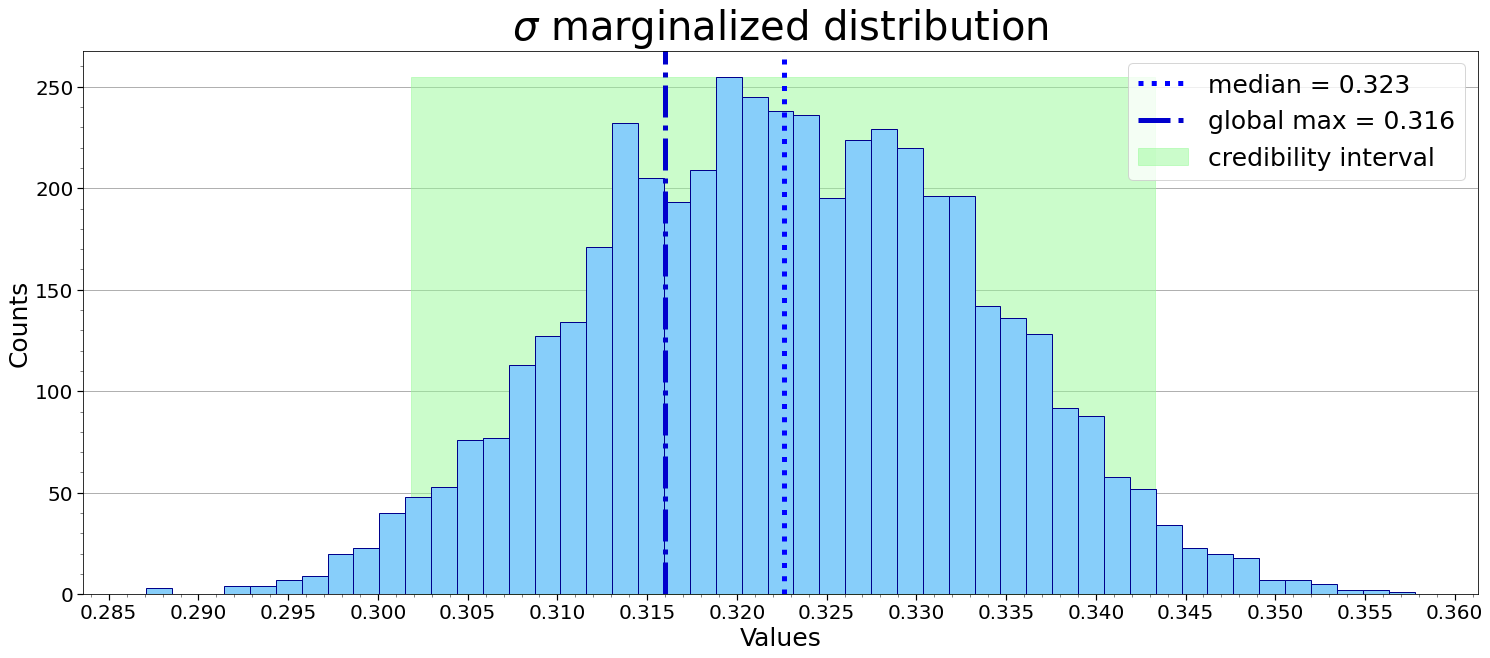

In [54]:
sigma_hist = np.concatenate([a for a in flat_samples_0[:,3]], axis=None)
ci_sigma = histogram(sigma_hist,r"$\sigma$ marginalized distribution", minimum.x[3], 80, 0.005, 0.001)

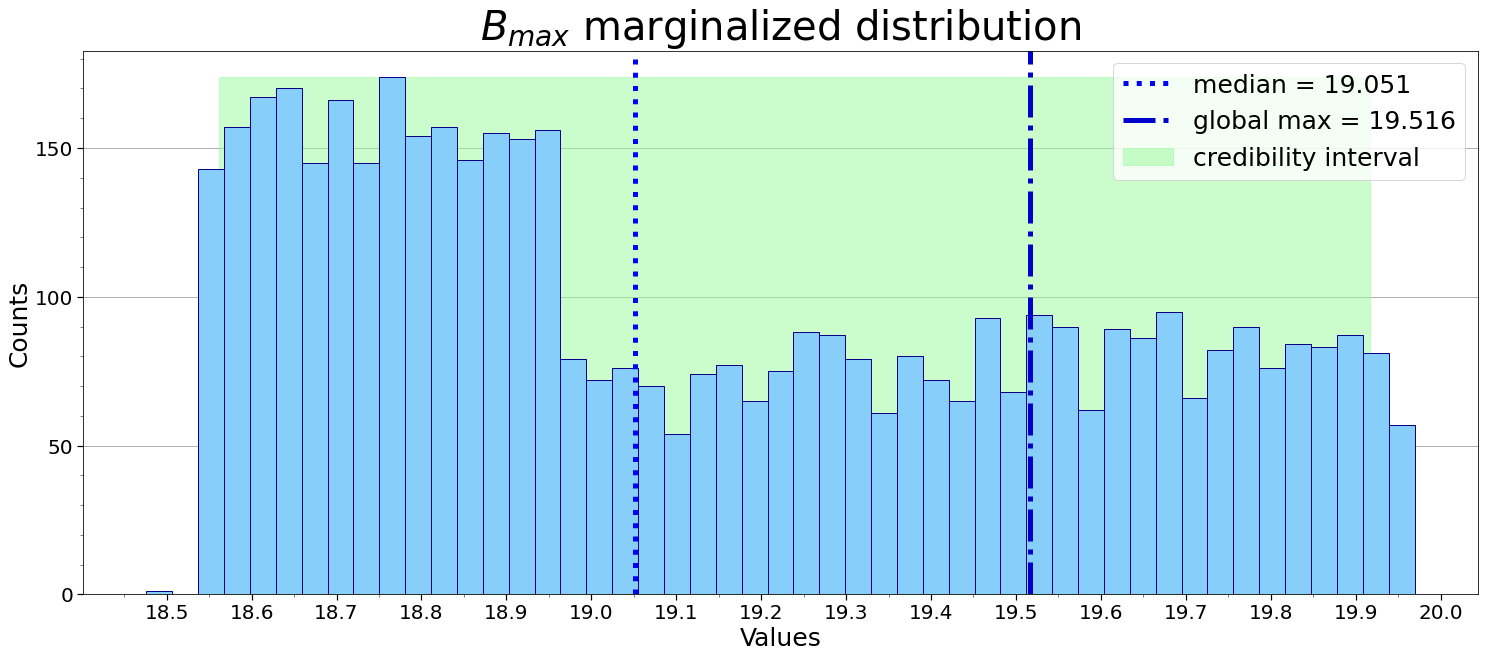

In [55]:
B_max_hist = np.concatenate([a for a in flat_samples_0[:,4]], axis=None)
ci_B_max = histogram(B_max_hist, r"$B_{max}$ marginalized distribution", minimum.x[4], 1500, 0.1, 0.05)

In [56]:
d = {'Values': minimum.x, 'Credibility Intervals': [round_list(ci_tau), round_list(ci_Nd), round_list(ci_T_delay), round_list(ci_sigma), round_list(ci_B_max)]}
df = pd.DataFrame(data=d, index=[r'$\tau$', r'$\mathcal{N}$', r'$T_{delay}$', r"$\sigma$", r"$B_{max}$"]).round(3)
df.round(3)

Values Credibility Intervals
$\tau$          0.190        [0.185, 0.196]
$\mathcal{N}$   0.888        [0.853, 0.925]
$T_{delay}$    10.541       [10.502, 10.58]
$\sigma$        0.316        [0.302, 0.343]
$B_{max}$      19.516      [18.561, 19.917]

It is observed that the distributions are well centered in the values corresponding to the maximum of the posterior, apart from $T_{delay}$. It is also possible to observe that the marginalized distributions have a similar shape to that associated with the data generated for the corresponding variable.

### Constraining $\mathcal{N}>1$ 

One problem of the previous minimum inferred from the minimization process is that the dynamo number $\mathcal{N}$ is found to be less than $1$, and this leads to a damped oscillation over time. We constrain here $\mathcal{N}$ to be greater than one, hoping to find a more physical set of parameters.

In [57]:
def log_prior(theta):
    tau, Nd, T_delay, sigma, B_max = theta
    if 0 < tau < 20 and 1 < Nd < 20 and 0 < T_delay < 20 and 0 < sigma < 1 and 0 < B_max < 20:
        return 0.0
    return -np.inf

In [58]:
bounds2 = [(0,20),(1,20),(0,20),(0,1),(0,20)]

minimum = differential_evolution(log_posterior_minimization, bounds2, args = (data, dt), mutation = (0,1.5), popsize=100, maxiter=10000)
# , x0 = [0.123, 1, 10.8, 0.15, 12]
tau_fix, Nd_fix, T_delay_fix, sigma_fix, B_max_fix = minimum.x

C:\Users\stefa\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [60]:
df_theta_min = pd.DataFrame({r'$\tau$': [minimum.x[0]],
                   r'$\mathcal{N}$': [minimum.x[1]],
                   r'$T_{delay}$': [minimum.x[2]],
                   r"$\sigma$":[minimum.x[3]],
                   r"$B_{max}$":[minimum.x[4]]}, index=[r"$\theta_{min}$"])

df_theta_min

$\tau$  $\mathcal{N}$  $T_{delay}$  $\sigma$  $B_{max}$
$\theta_{min}$  0.19302       1.000009    10.545053  0.338734  18.781897

In [61]:
df_log_posterior = pd.DataFrame({r"- log-posterior($\bar{\theta}$)":[log_posterior_minimization(minimum.x, data, dt)]},index=[""])
df_log_posterior.round(3)

- log-posterior($\bar{\theta}$)
                         6272.404

In [62]:
t, B_sim_1 = SDDE_simulate(dt = dt, tau = tau_fix, Nd = Nd_fix, T_delay = T_delay_fix, T_sim = len(data)*dt, sigma = sigma_fix , B_max = B_max_fix, B_i = data[:(int(T_delay_fix/dt)+2)], flag = False)

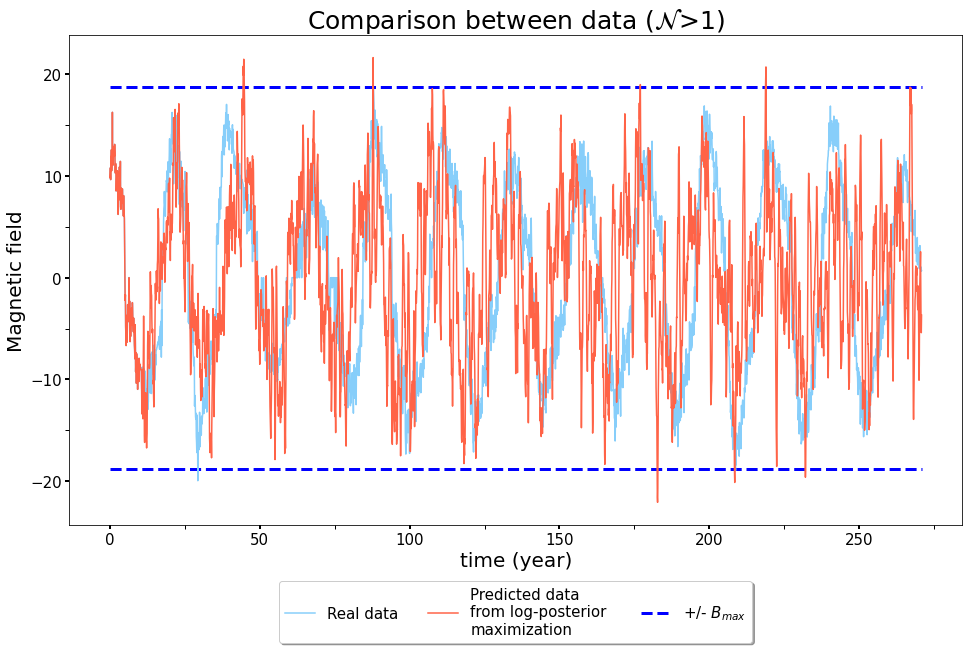

In [63]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(t, data, color="lightskyblue",linewidth=1.5, label ="Real data")
ax.plot(t, B_sim_1, color = "tomato", linewidth=1.5, label="Predicted data \nfrom log-posterior \nmaximization")
ax.set_title("Comparison between data ($\mathcal{N}$>1)", fontsize=25)
ax.set_xlabel('time (year)', fontsize = 20)
ax.set_ylabel('Magnetic field', fontsize = 20)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(which='major',labelsize=15, length=4, width=2, color='black')
ax.tick_params(which='minor',labelsize=15, length=4, width=1, color='black')
ax.hlines(B_max_fix, 0, t[-1], colors = 'blue', linestyles = 'dashed', label="+/- $B_{max}$",linewidth=3) # thresholds at B_max and -B_max
ax.hlines(-B_max_fix, 0, t[-1], colors = 'blue', linestyles = 'dashed',linewidth=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3, fontsize=15)

Compared to the unconstrained trajectory, this one is more sustained over time, even if after a few cycles the noisy behaviour is still present.

100%|██████████| 5000/5000 [17:29<00:00,  4.76it/s]


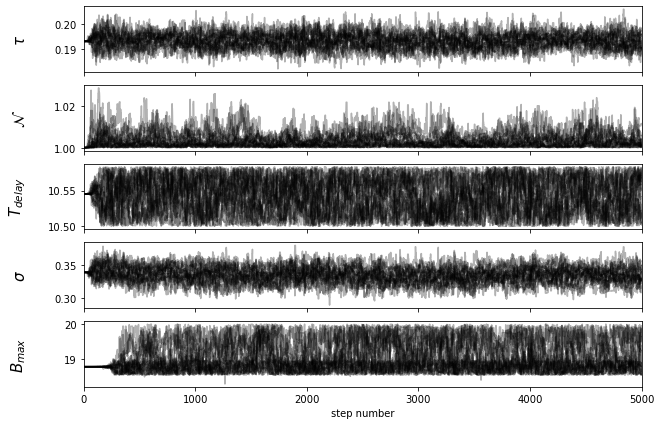

In [64]:
pos = minimum.x + 1e-8 * np.random.randn(20, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, dt))
sampler.run_mcmc(pos, 5000, progress=True);

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\tau$", r"$\mathcal{N}$", r"$T_{delay}$", r"$\sigma$", r"$B_{max}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize = 15)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [65]:
flat_samples_1 = sampler.get_chain(discard=200, thin=20, flat=True)
print(flat_samples_1.shape)

(4800, 5)


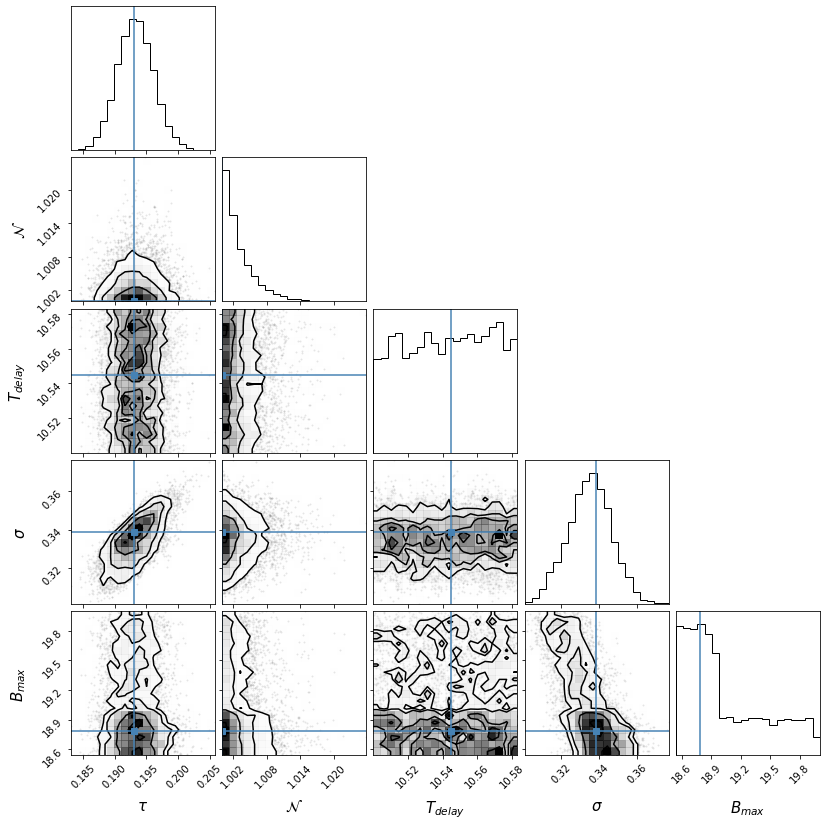

In [66]:
fig = corner.corner(
    flat_samples_1, labels=labels, truths=minimum.x, label_kwargs={"fontsize": 15}
);

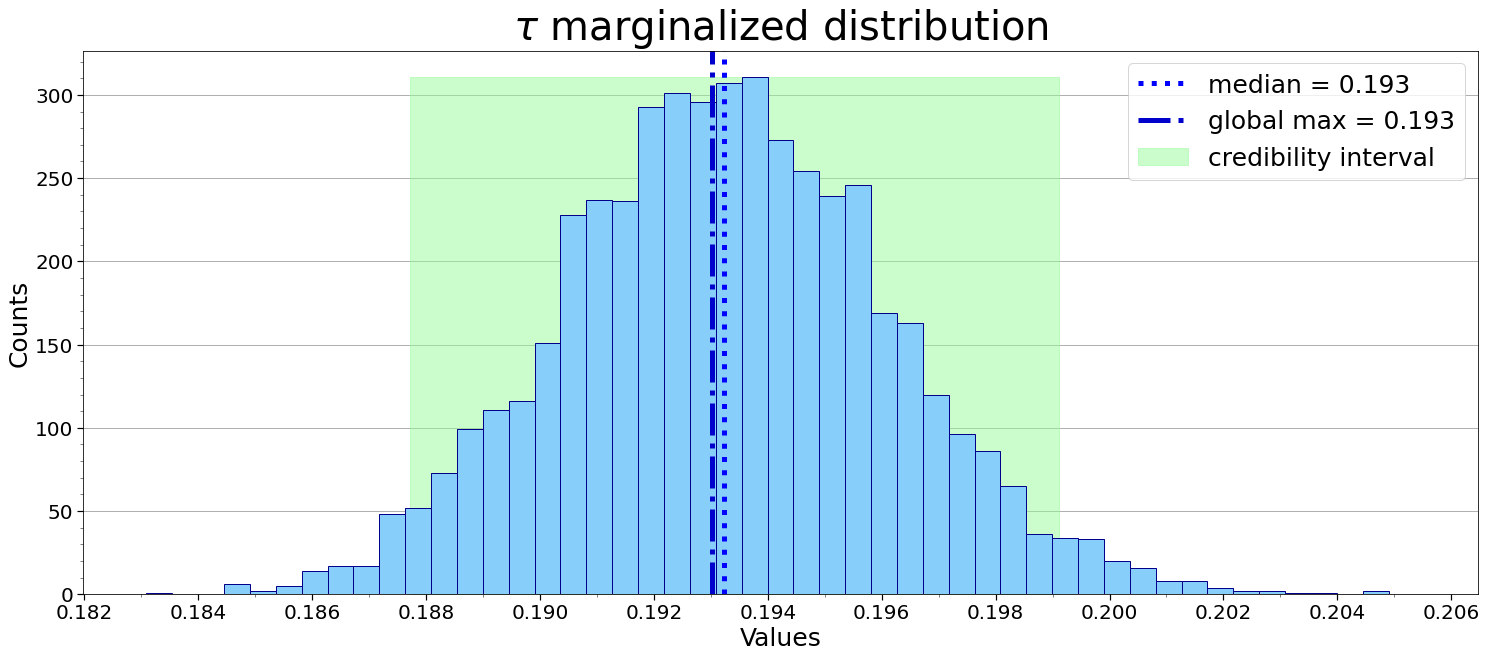

In [68]:
tau_hist = np.concatenate([a for a in flat_samples_1[:,0]], axis=None)
ci_tau = histogram(tau_hist, r"$\tau$ marginalized distribution", minimum.x[0], 1500, 0.002, 0.001)

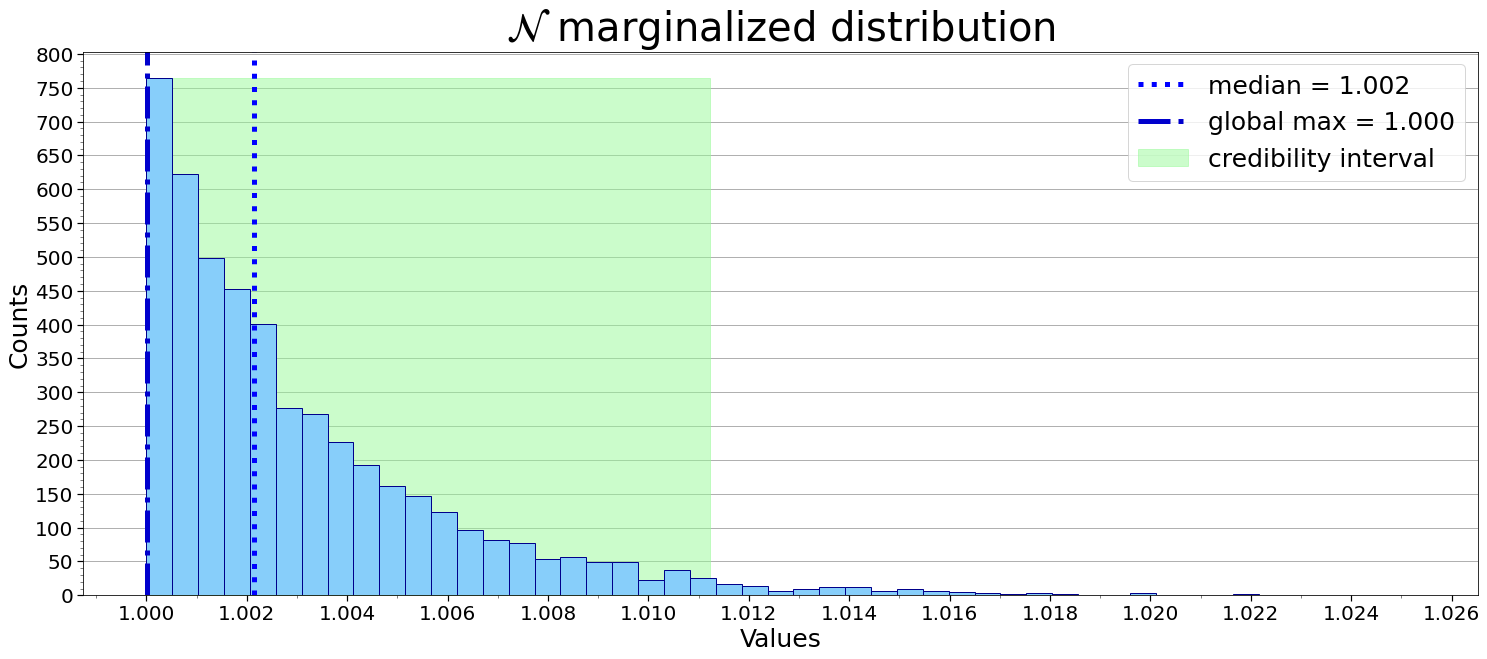

In [70]:
Nd_hist = np.concatenate([a for a in flat_samples_1[:,1]], axis=None)
ci_Nd = histogram(Nd_hist,r"$\mathcal{N}$ marginalized distribution", minimum.x[1], 1500, 0.002, 0.001 )

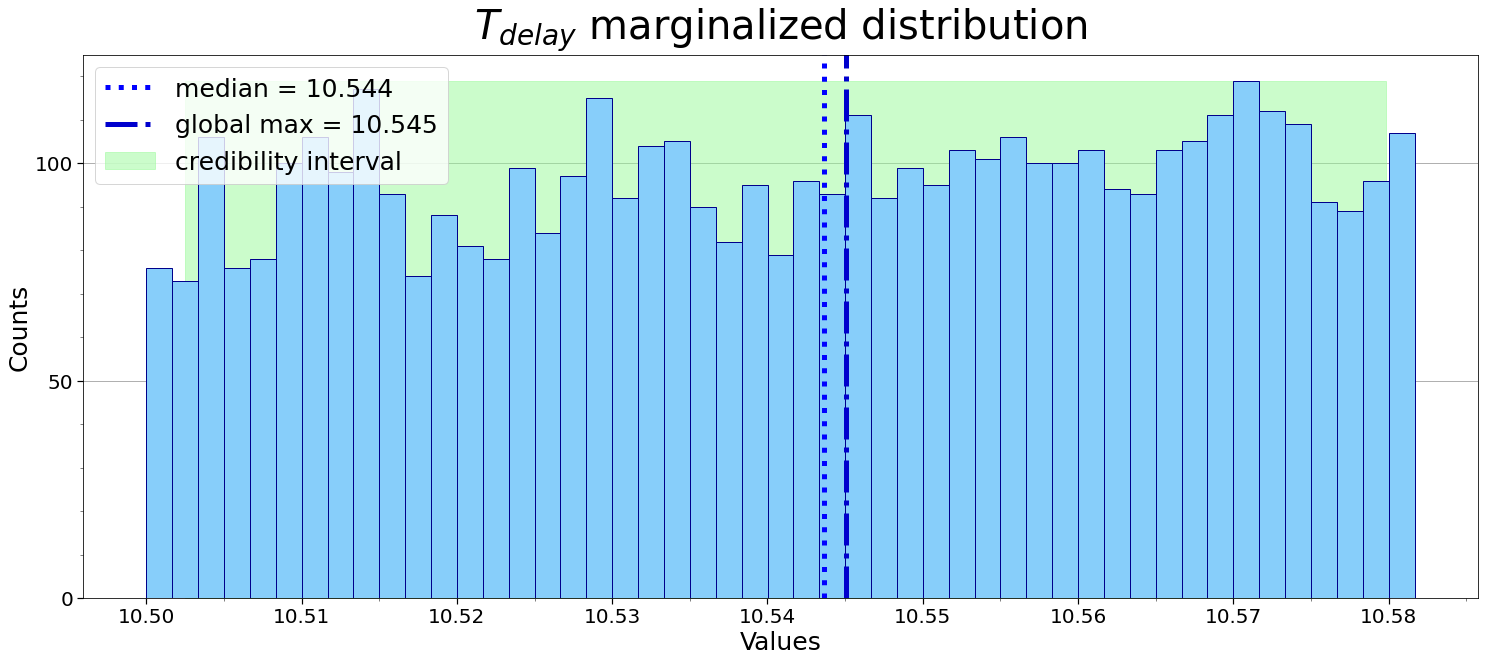

In [71]:
Td_hist = np.concatenate([a for a in flat_samples_1[:,2]], axis=None)
ci_Td = histogram(Td_hist,r"$T_{delay}$ marginalized distribution", minimum.x[2], 1500, 0.01, 0.005 )

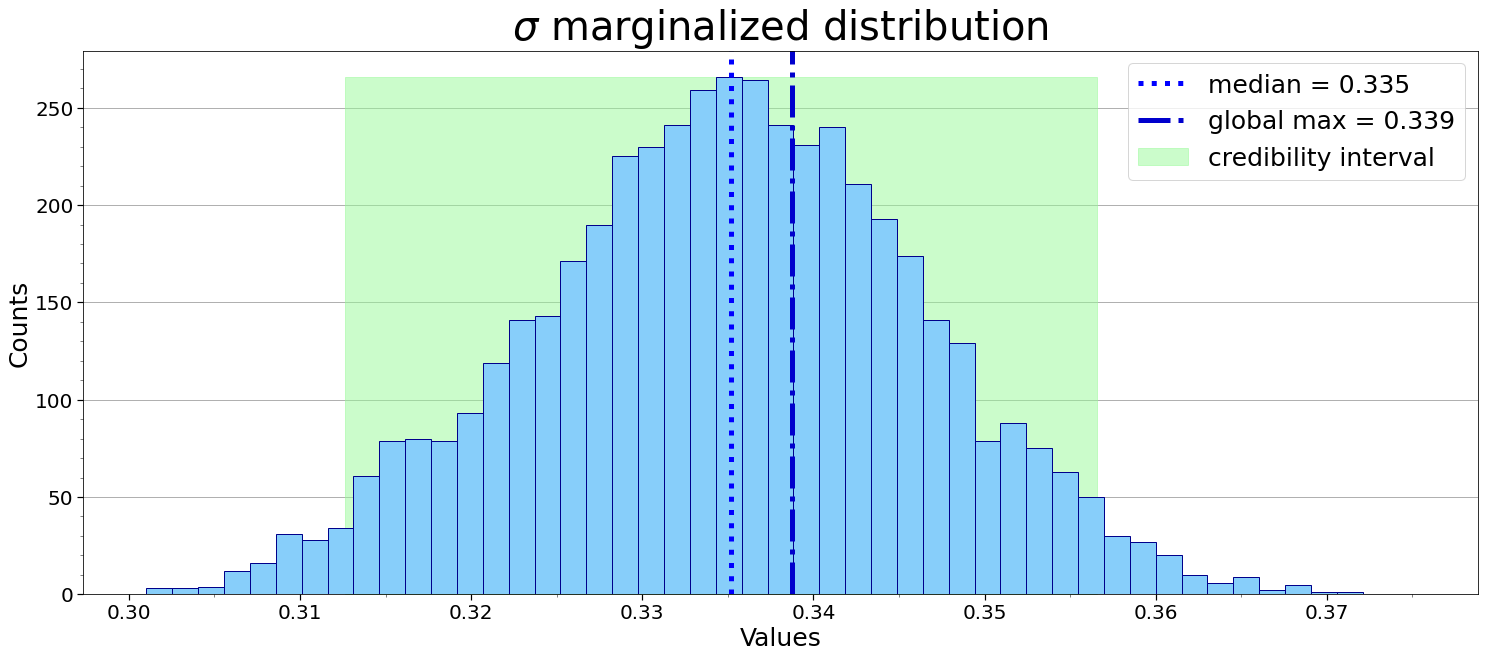

In [72]:
s_hist = np.concatenate([a for a in flat_samples_1[:,3]], axis=None)
ci_sigma = histogram(s_hist,r"$\sigma$ marginalized distribution", minimum.x[3], 1500, 0.01, 0.005 )

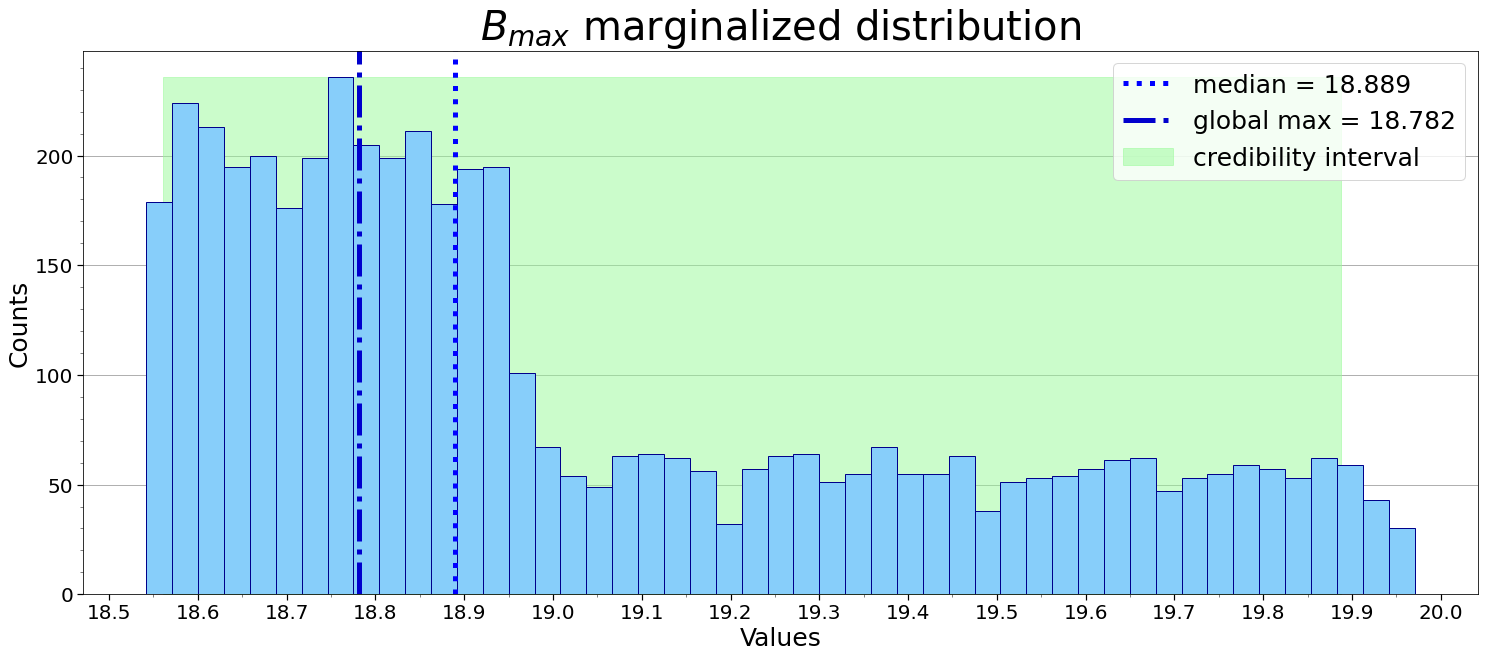

In [73]:
B_max_hist = np.concatenate([a for a in flat_samples_1[:,4]], axis=None)
ci_B_max = histogram(B_max_hist, r"$B_{max}$ marginalized distribution", minimum.x[4], 1500, 0.1, 0.05)

In [74]:
d = {'Values': minimum.x, 'Credibility Intervals': [round_list(ci_tau), round_list(ci_Nd), round_list(ci_T_delay), round_list(ci_sigma), round_list(ci_B_max)]}
df = pd.DataFrame(data=d, index=[r'$\tau$', r'$\mathcal{N}$', r'$T_{delay}$', r"$\sigma$", r"$B_{max}$"]).round(3)
df.round(3)

Values Credibility Intervals
$\tau$          0.193        [0.188, 0.199]
$\mathcal{N}$   1.000          [1.0, 1.011]
$T_{delay}$    10.545       [10.502, 10.58]
$\sigma$        0.339        [0.313, 0.357]
$B_{max}$      18.782      [18.561, 19.887]

It can be observed that the marginalized distributions are similar to the previous case except for $\mathcal{N}>1$: its distribution in fact has a peak at the minimum value that $\mathcal{N}$ can assume, and decreases as the value of $\mathcal{N}$ increases. This is not unexpected as if $\mathcal{N}$ were not constrained, the peak of the distribution would assume a value less than 1.

### Constraining $\mathcal{N}>1$ and  $B_{max}<10$

As experiment, we try also to bind $B_{max}$ to see if the trajectory found has some different behaviour from the latter.

In [75]:
def log_prior(theta):
    tau, Nd, T_delay, sigma, B_max = theta
    if 0 < tau < 20 and 1 < Nd < 20 and 0 < T_delay < 20 and 0 < sigma < 1 and 0 < B_max < 10:
        return 0.0
    return -np.inf

In [76]:
bounds3 = [(0,20),(1,20),(0,20),(0,1),(0,10)]

minimum = differential_evolution(log_posterior_minimization, bounds3, args = (data, dt), mutation = (0,1.5), popsize=100, maxiter=10000)
# , x0 = [0.123, 1, 10.8, 0.15, 12]
tau_fix, Nd_fix, T_delay_fix, sigma_fix, B_max_fix = minimum.x

C:\Users\stefa\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [78]:
df_theta_min = pd.DataFrame({r'$\tau$': [minimum.x[0]],
                   r'$\mathcal{N}$': [minimum.x[1]],
                   r'$T_{delay}$': [minimum.x[2]],
                   r"$\sigma$":[minimum.x[3]],
                   r"$B_{max}$":[minimum.x[4]]}, index=[r"$\theta_{min}$"])

df_theta_min

$\tau$  $\mathcal{N}$  $T_{delay}$  $\sigma$  $B_{max}$
$\theta_{min}$  0.248357       1.001209    10.736961  0.999985   9.989719

In [79]:
df_log_posterior = pd.DataFrame({r"- log-posterior($\bar{\theta}$)":[log_posterior_minimization(minimum.x, data, dt)]},index=[""])
df_log_posterior.round(3)

- log-posterior($\bar{\theta}$)
                           6572.9

In [80]:
t, B_sim_2 = SDDE_simulate(dt = dt, tau = tau_fix, Nd = Nd_fix, T_delay = T_delay_fix, T_sim = len(data)*dt, sigma = sigma_fix , B_max = B_max_fix, B_i = data[:(int(T_delay_fix/dt)+2)], flag = False)

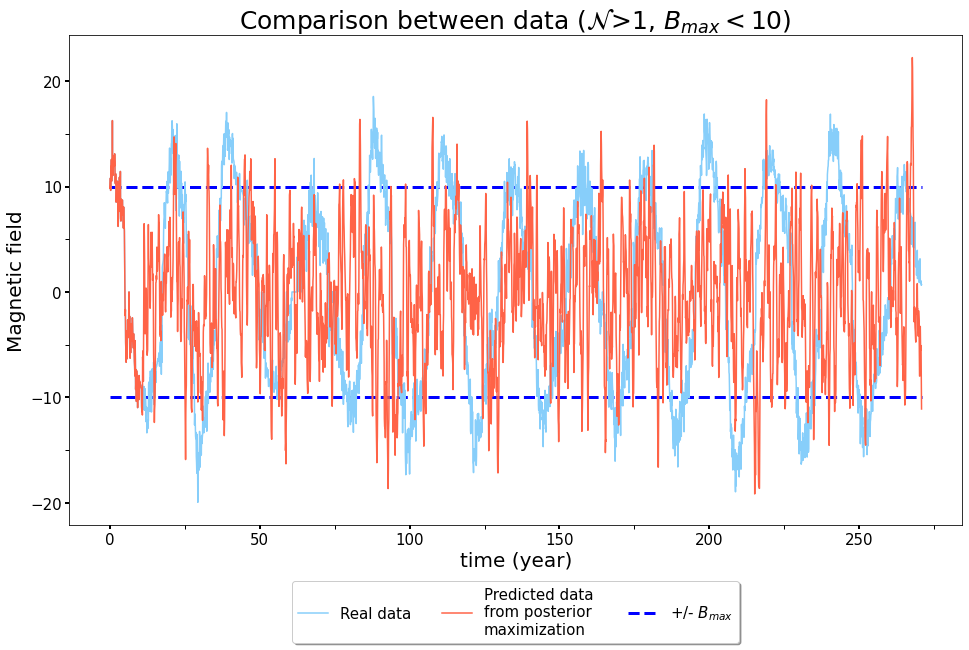

In [82]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(t, data, color="lightskyblue",linewidth=1.5, label ="Real data")
ax.plot(t, B_sim_2, color = "tomato", linewidth=1.5, label="Predicted data \nfrom posterior \nmaximization")
ax.set_title("Comparison between data ($\mathcal{N}$>1, $B_{max}<10$)", fontsize=25)
ax.set_xlabel('time (year)', fontsize = 20)
ax.set_ylabel('Magnetic field', fontsize = 20)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(which='major',labelsize=15, length=4, width=2, color='black')
ax.tick_params(which='minor',labelsize=15, length=4, width=1, color='black')
ax.hlines(B_max_fix, 0, t[-1], colors = 'blue', linestyles = 'dashed', label="+/- $B_{max}$",linewidth=3) # thresholds at B_max and -B_max
ax.hlines(-B_max_fix, 0, t[-1], colors = 'blue', linestyles = 'dashed',linewidth=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3, fontsize=15)

The addition of a $B_{max}$ constrain get worse the predicted behaviour of the magnetic field, which loses also the initial matching with the data periodicity.

100%|██████████| 5000/5000 [15:37<00:00,  5.33it/s]


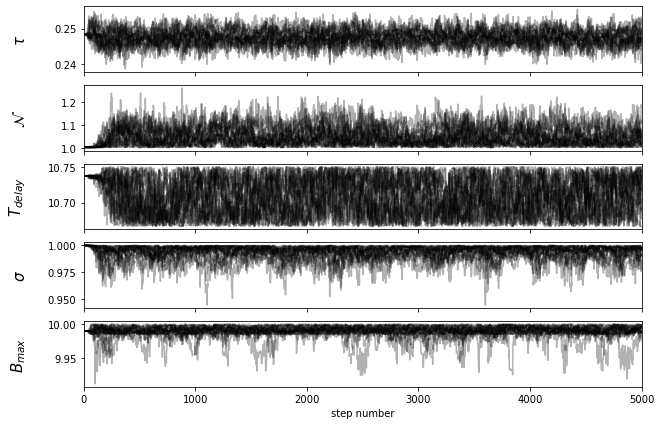

In [83]:
pos = minimum.x + 1e-8 * np.random.randn(20, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, dt))
sampler.run_mcmc(pos, 5000, progress=True);

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\tau$", r"$\mathcal{N}$", r"$T_{delay}$", r"$\sigma$", r"$B_{max}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize = 15)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [84]:
flat_samples = sampler.get_chain(discard=200, thin=20, flat=True)
print(flat_samples.shape)

(4800, 5)


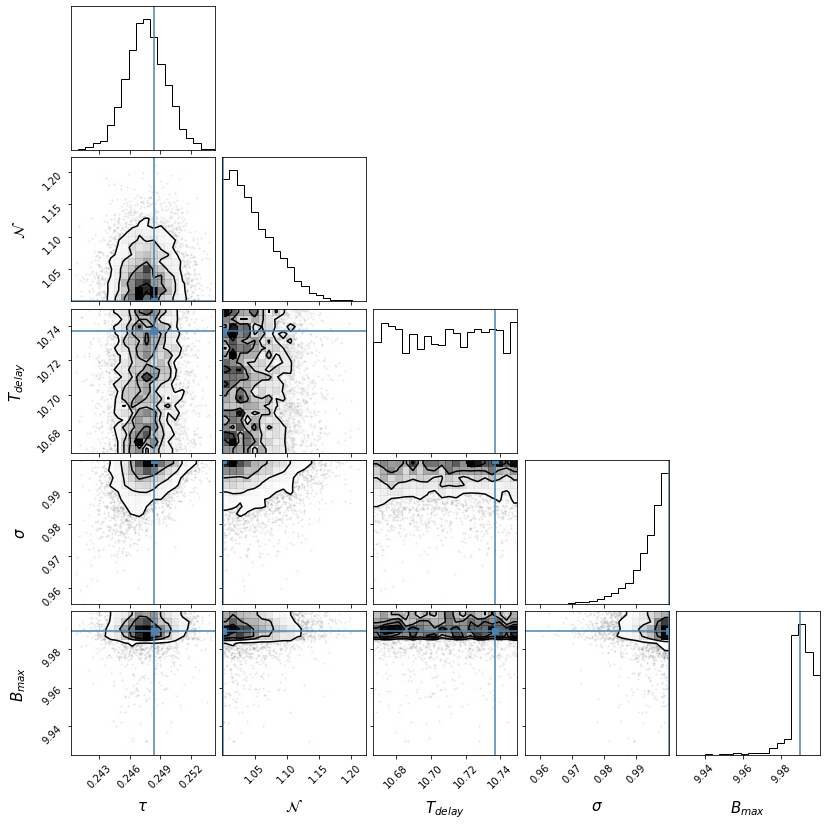

In [85]:
fig = corner.corner(
    flat_samples, labels=labels, truths=minimum.x, label_kwargs={"fontsize": 15}
);

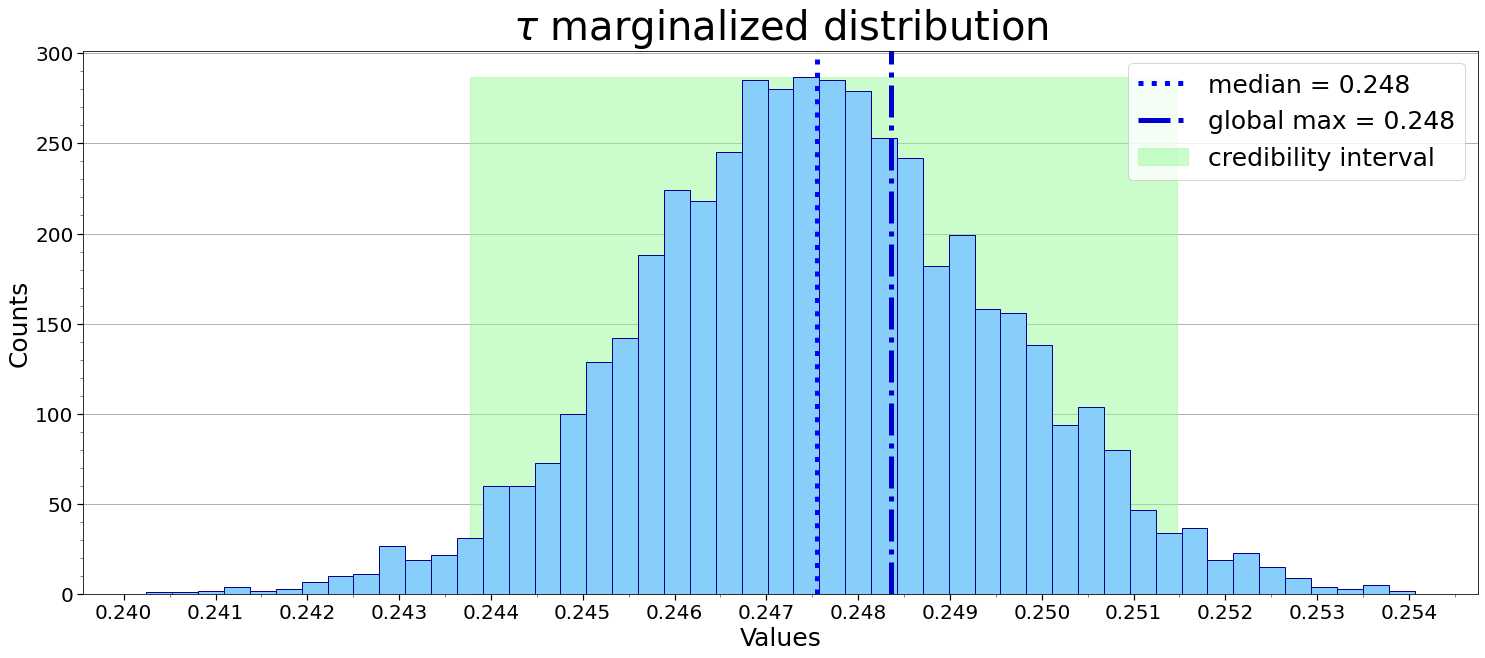

In [86]:
tau_hist = np.concatenate([a for a in flat_samples[:,0]], axis=None)
ci_tau = histogram(tau_hist, r"$\tau$ marginalized distribution", minimum.x[0], 1500, 0.001, 0.0005)

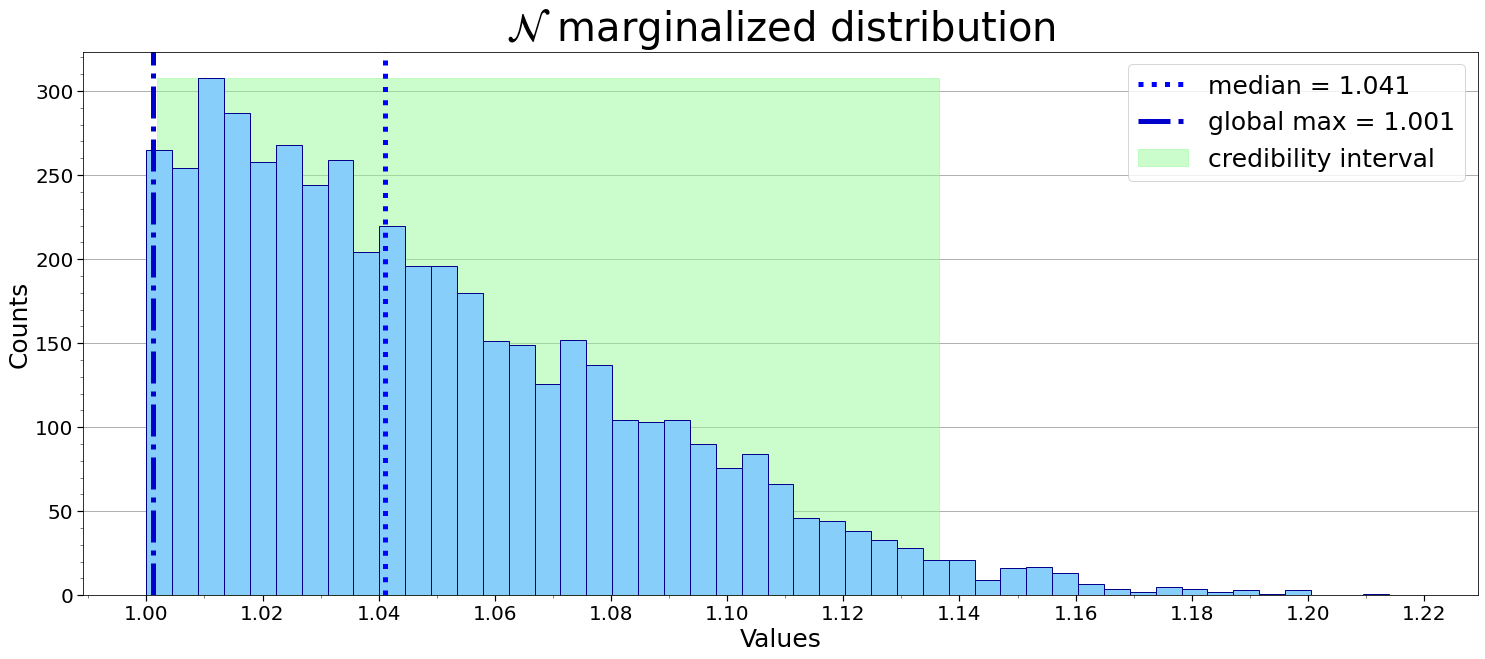

In [88]:
Nd_hist = np.concatenate([a for a in flat_samples[:,1]], axis=None)
ci_Nd = histogram(Nd_hist,r"$\mathcal{N}$ marginalized distribution", minimum.x[1], 1500, 0.02, 0.01 )

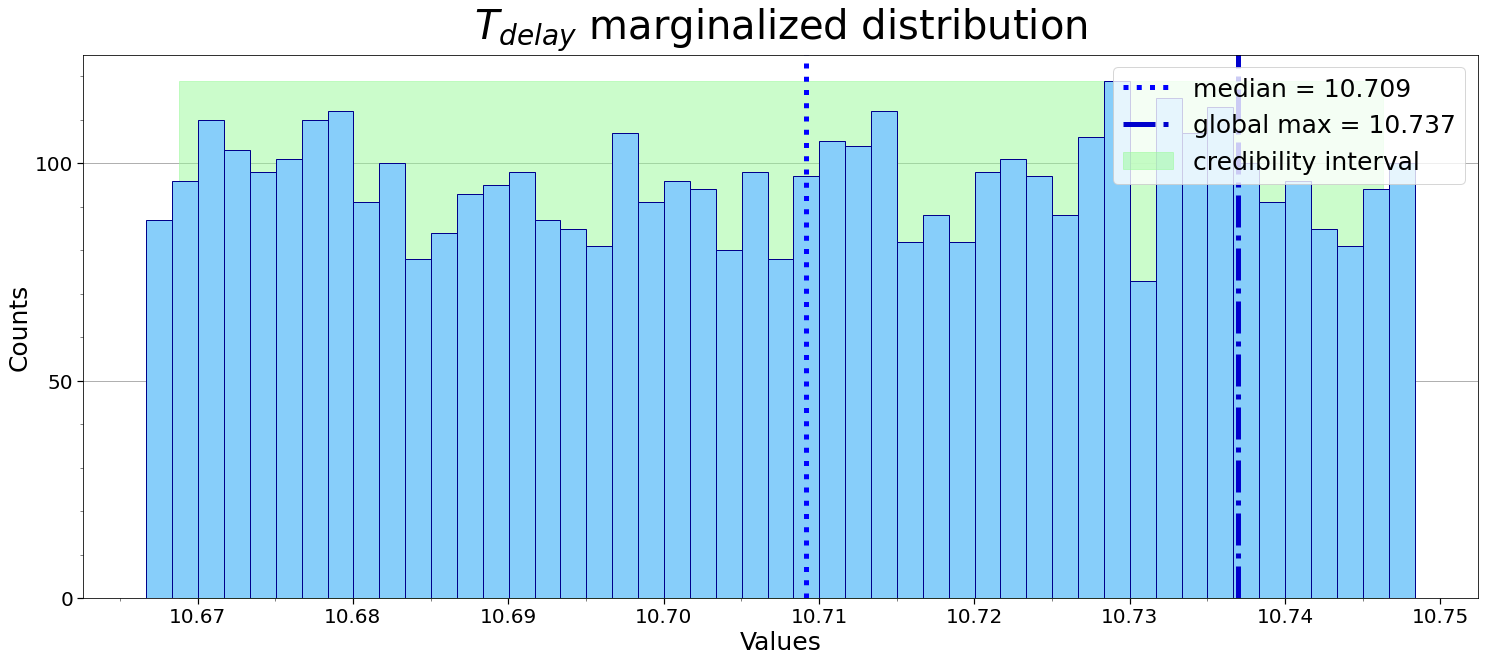

In [89]:
T_delay_hist = np.concatenate([a for a in flat_samples[:,2]], axis=None)
ci_T_delay = histogram(T_delay_hist, r"$T_{delay}$ marginalized distribution", minimum.x[2], 1500, 0.01, 0.005)

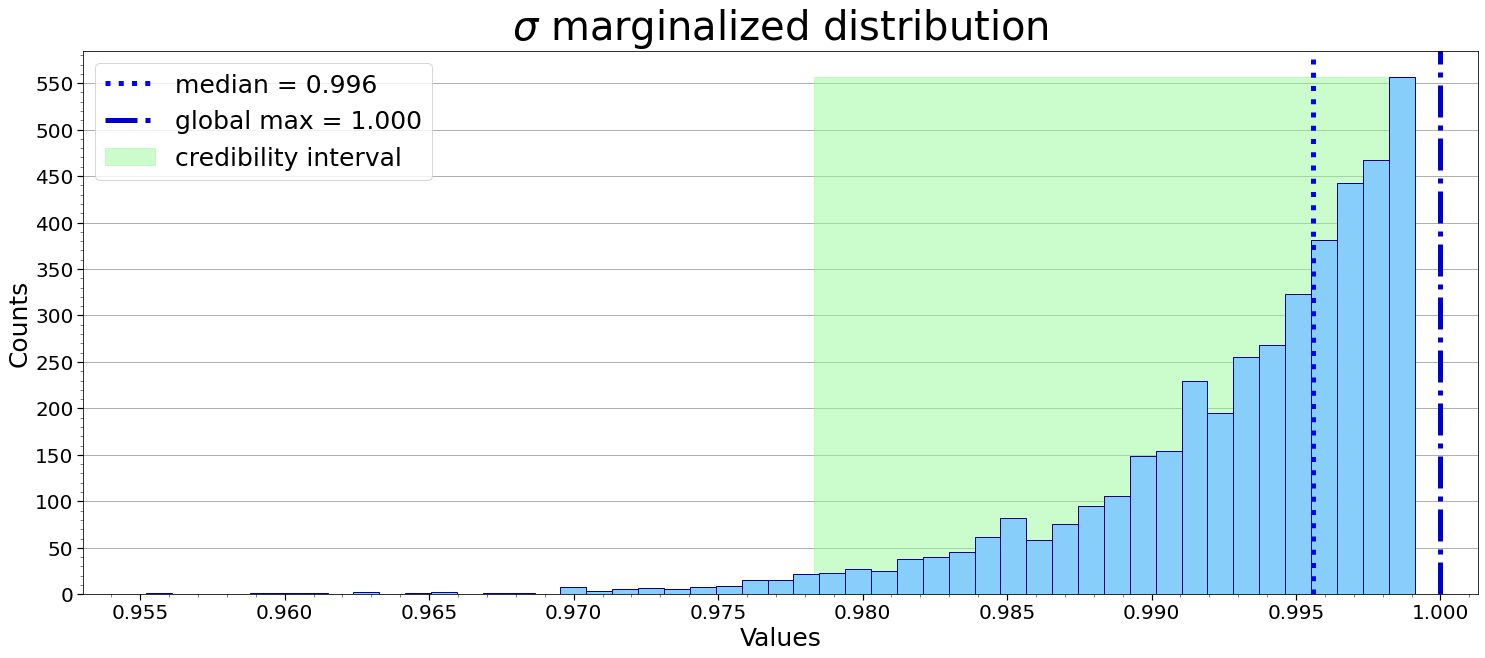

In [90]:
sigma_hist = np.concatenate([a for a in flat_samples[:,3]], axis=None)
ci_sigma = histogram(sigma_hist,r"$\sigma$ marginalized distribution", minimum.x[3], 80, 0.005, 0.001)

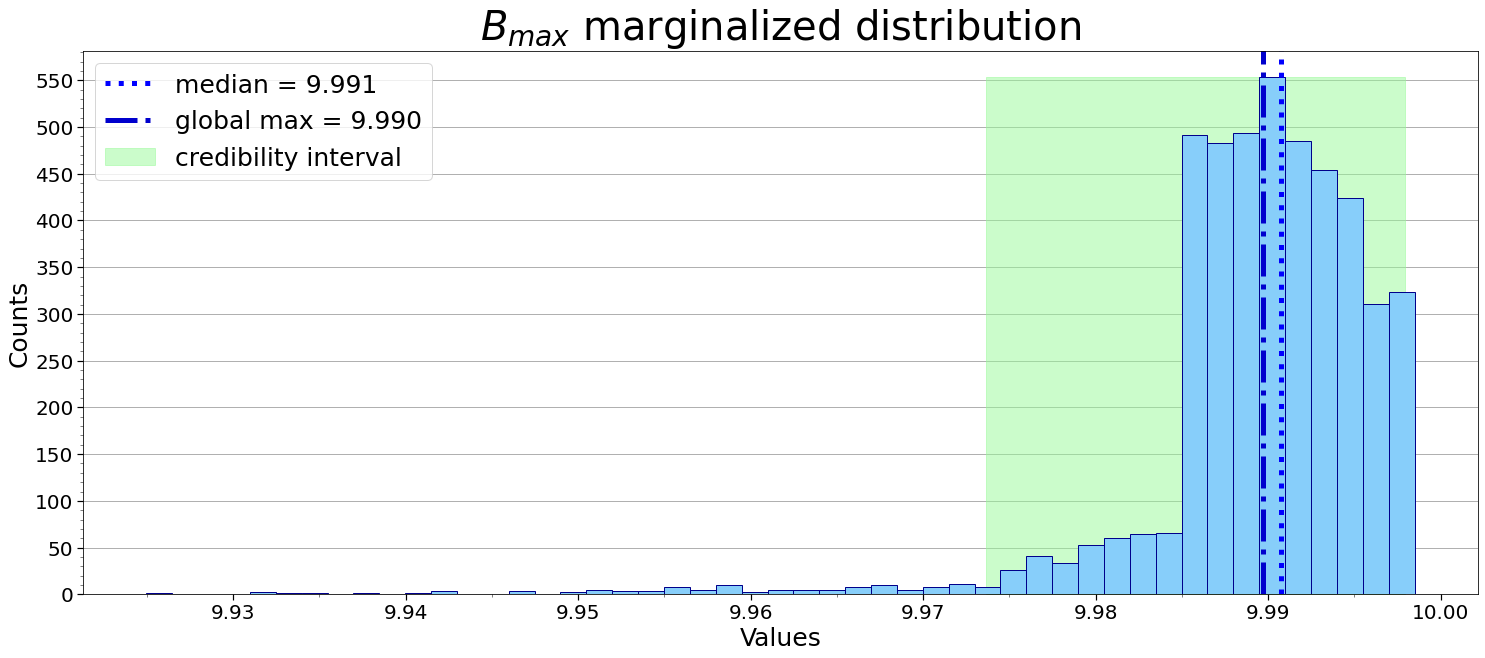

In [91]:
B_max_hist = np.concatenate([a for a in flat_samples[:,4]], axis=None)
ci_B_max = histogram(B_max_hist, r"$B_{max}$ marginalized distribution", minimum.x[4], 1500, 0.01, 0.005)

In [92]:
d = {'Values': minimum.x, 'Credibility Intervals': [round_list(ci_tau), round_list(ci_Nd), round_list(ci_T_delay), round_list(ci_sigma), round_list(ci_B_max)]}
df = pd.DataFrame(data=d, index=[r'$\tau$', r'$\mathcal{N}$', r'$T_{delay}$', r"$\sigma$", r"$B_{max}$"]).round(3)
df.round(3)

Values Credibility Intervals
$\tau$          0.248        [0.244, 0.251]
$\mathcal{N}$   1.001        [1.002, 1.137]
$T_{delay}$    10.737      [10.669, 10.746]
$\sigma$        1.000        [0.978, 0.999]
$B_{max}$       9.990        [9.974, 9.998]

Again, the marginalized distributions have a similar shape to the unconstrained case apart from the distributions relative to $\mathcal{N}$ and $B_{max}$. For $\mathcal{N}$ the case is similar to what was previously discussed, while for $B_{max}$ it is observed that the peak of the distribution is close to the maximum value that $B_{max}$ can assume. This behavior is expected as, as already seen, if $B_{max}$ were not constrained, the maximum would be found for a value greater than 10.

## Real data inference with weak periodic driver

It is possible to consider also an external influence on the system, provided by considering an external forcing (hypothetically a planets effect) that could influence the period of the cycles. This is done by considering a small modulation in the formula above. This modulation is represented by a cosine function. The integrator and the likelihood are modified as consequence of this new term. The new term adds two parameters to the inference: the amplitute of the cosine $\epsilon$ and its frequency $\omega_{d}$.

\begin{equation}
    \tau^2 \frac{d^2}{dt^2}B(t) + 2\tau\frac{d}{dt}B(t)+
    B(t) =  -\mathcal{N}\cdot(1+\epsilon \cdot cos(\omega_d t))\cdot B(t-T_{delay}) \cdot f(B(t-T_{delay})) + \sqrt{\tau}B_{max}\sigma\xi(t)
\end{equation}

\begin{equation} \label{Bi}
    B_i = 2\cdot\left(1- \frac{\Delta t}{\tau}\right)\cdot B_{i-1} - \left(1-\left(\frac{\Delta t}{\tau}\right)\right)^2 \cdot B_{i-2}  - \mathcal{N}\cdot(1+ \epsilon \cdot cos(\omega_d i \Delta t))\cdot\left(\frac{\Delta t}{\tau}\right)^2 \cdot B_{i-T-2} \cdot f(B_{i-T-2}) + \left(\frac{\Delta t}{\tau}\right)^{\frac{3}{2}}\sigma B_{max}\epsilon_i
\end{equation}

\begin{align} \nonumber
    \mathcal{L}(B_{T+2},..,B_N|\bar{\theta}) & = \left[-\frac{1}{2} \ln{(2\pi)} - \frac{3}{2} \ln{(\Delta t)} + \frac{3}{2} \ln{(\tau)} - \ln{(\sigma)} - \ln{(B_{max})}\right] \cdot (N-(T+2)) \\ & - \sum_{i=T+2}^{N} \frac{\biggl( B_i - 2(1- \frac{\Delta t}{\tau})B_{i-1}  + (1-\frac{\Delta t}{\tau})^2 B_{i-2} + \mathcal{N}\cdot(1+ \epsilon \cdot cos(\omega_d i \Delta t))\cdot \frac{(\Delta t)^2}{\tau^2} B_{i-T-2}  \cdot f(B_{i-T-2}) \biggr)^2 }{2 \biggl[ \left(\frac{\Delta t}{\tau}\right)^{(3/2)} \sigma B_{max} \biggr]^2}
\end{align}

In [93]:
def integrator_cos(B, dt, tau, Nd, T, e,w, T_sim = 100, sigma = 0, B_max = 10):
    # function that computes B(t) in its discretized form
    
    for i in range(T+2, len(B)):
        B[i] = 2 * (1-(dt/tau)) * B[i-1] - (1-(dt/tau))**2 * B[i-2]\
               - (dt/tau)**2 * Nd * (1+e*np.cos(w*i*dt)) * B[i-(T+2)] * f(B[i-(T+2)],B_max)\
               + (dt/tau)**(3/2) * sigma * B_max * np.random.randn()
    
    return B

In [94]:
def SDDE_simulate_cos(dt, tau, Nd, T_delay, e,w, T_sim = 100, sigma = 0, B_max = 10, B_i = 9.9, rs = 463617, flag = True): 
    # function that creates the arrays and plot the integrated B(t)
    
    np.random.seed(rs) # set random seed for reproducible results
    t = np.arange(0, T_sim, dt)
    N = len(t)
    B = np.zeros(N)
    T = int(T_delay/dt)
    
    B[:T+2] = B_i*np.ones(T+2) # initial conditions
    
    B = integrator_cos(B, dt, tau, Nd, T,e,w, T_sim, sigma, B_max) # integrating the differential equation
    
    if flag:
        fig, ax = plt.subplots()
        ax.plot(t, B, color = "lightskyblue", linewidth=3)
        ax.hlines(B_max, 0, T_sim, colors = 'red', linestyles = 'dashed', label="+/- $B_{max}$",linewidth=3) # thresholds at B_max and -B_max
        ax.hlines(-B_max, 0, T_sim, colors = 'red', linestyles = 'dashed',linewidth=3)
    
        ax.set_title("Solar magnetic field", fontsize=25)
        ax.set_xlabel('time', fontsize = 20)
        ax.set_ylabel('Magnetic field', fontsize = 20)
    
        ax.legend(loc="lower right",fontsize=20)
    
        ax.xaxis.set_major_locator(MultipleLocator(50))
        ax.xaxis.set_minor_locator(MultipleLocator(25))
    
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.yaxis.set_minor_locator(MultipleLocator(5))
    
        ax.tick_params(which='major', length=4, width=2, color='black')
        ax.tick_params(which='minor', length=4, width=1, color='black')
        
    return t, B

In [95]:
def sommatory_cos(B, dt, tau, T, Nd, B_max, N,e,w): # sommatory term of the log-likelihood
    somm = 0
    for i in range(T+2, N):
        somm += ( B[i] - 2 * (1-(dt/tau)) *B[i-1] + (1-(dt/tau))**2 * B[i-2]\
                + Nd* (1+e*np.cos(w*i*dt)) * (dt/tau)**2 * B[i-(T+2)] * f(B[i-(T+2)],B_max)\
                )**2
    return somm

In [96]:
def log_likelihood_cos(theta, B, dt):
    tau, Nd, T_delay, sigma, B_max,e,w = theta
    N = len(B)
    T = int(T_delay/dt)

    loglike = (- (1/2)*np.log(2*np.pi) - (3/2)*np.log(dt) + (3/2)*np.log(tau) - np.log(sigma) - np.log(B_max))*(N-(T+2))\
              - (sommatory_cos(B, dt, tau, T, Nd, B_max, N,e,w)/(2*((dt/tau)**(3/2)*sigma*B_max)**2))
    return loglike

Prior knowledge on the standard case without modulation suggest to consider a smaller interval for $\mathcal{N}$. Regarding the additional parameters $\epsilon$ and $\omega_d$, well suit intervals are considered, with the aim of not having too much modulation amplitude and not dealing with periods much smaller that $20$ (period of a singol cycle).

In [100]:
def log_prior_cos(theta):
    tau, Nd, T_delay, sigma, B_max,e,w = theta
    if 0 < tau < 20 and 0.0 < Nd < 4 and 0 < T_delay < 20 and 0 < sigma < 1 and 0 < B_max < 20 and 0 < e < 0.4 and 0 < w < 0.35 :
        return 0.0
    return -np.inf

In [101]:
def log_posterior_cos(theta, B, dt):
    lp = log_prior_cos(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_cos(theta, B, dt)

In [102]:
def log_likelihood_minimization_cos(theta, B, dt): # searching for the minima of  -log_likelihood
    return -log_likelihood_cos(theta, B, dt)

def log_posterior_minimization_cos(theta, B, dt): # searching for the minima of  -log_posterior
    return -log_posterior_cos(theta, B, dt)

In [105]:
bounds_cos = [(0,20),(0,20),(0,20),(0,1),(0,20),(0,0.4),(0,0.35)]

minimum_cos = differential_evolution(log_posterior_minimization_cos, bounds_cos, args = (data, dt), mutation = (0,1.5), popsize=100, maxiter=10000)
# , x0 = [0.123, 1, 10.8, 0.15, 12]
tau_fix, Nd_fix, T_delay_fix, sigma_fix, B_max_fix, e_fix, w_fix = minimum_cos.x

C:\Users\stefa\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [106]:
df_theta_min_cos = pd.DataFrame({r'$\tau$': [minimum_cos.x[0]],
                   r'$\mathcal{N}$': [minimum_cos.x[1]],
                   r'$T_{delay}$': [minimum_cos.x[2]],
                   r"$\sigma$":[minimum_cos.x[3]],
                   r"$B_{max}$":[minimum_cos.x[4]],
                   r"$\epsilon$":[minimum_cos.x[5]], 
                   r"$\omega_d$":[minimum_cos.x[6]]}, index=[r"$\theta_{min}$"])

df_theta_min_cos

$\tau$  $\mathcal{N}$  $T_{delay}$  $\sigma$  $B_{max}$  \
$\theta_{min}$  0.188561       0.889473    10.575851  0.317607  19.351737   

                $\epsilon$  $\omega_d$  
$\theta_{min}$    0.173854    0.063894

In [107]:
df_log_posterior_cos = pd.DataFrame({r"- log-posterior($\bar{\theta}$)":[log_posterior_minimization_cos(minimum_cos.x, data, dt)]},index=[""])
df_log_posterior_cos.round(3)

- log-posterior($\bar{\theta}$)
                         6243.596

In [108]:
t, B_sim_cos = SDDE_simulate_cos(dt = dt, tau = tau_fix, Nd = Nd_fix, T_delay = T_delay_fix, e=e_fix, w=w_fix, T_sim = len(data)*dt, sigma = sigma_fix , B_max = B_max_fix, B_i = data[:(int(T_delay_fix/dt)+2)], flag = False)

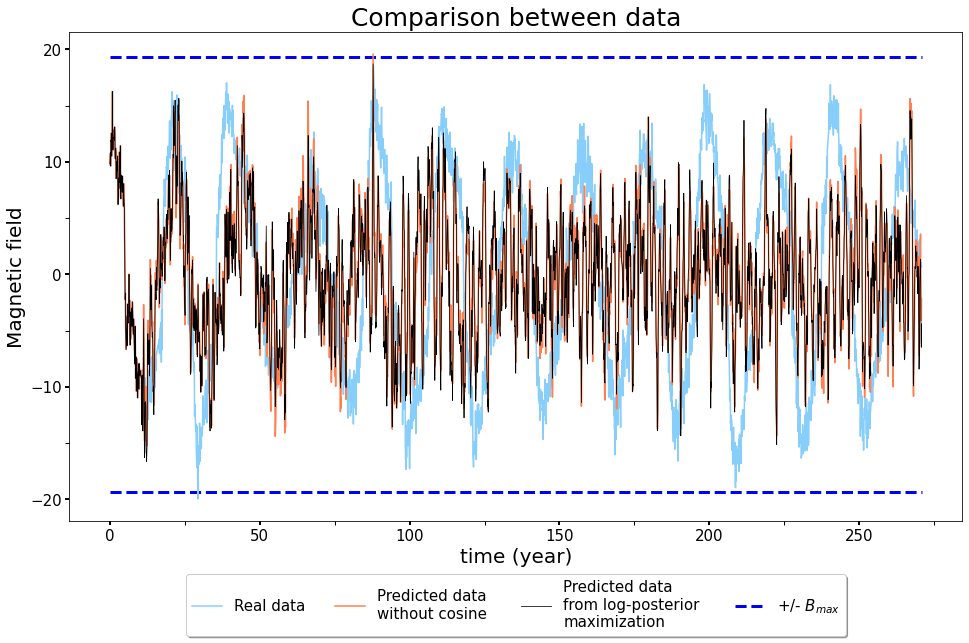

In [119]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(t, data, color="lightskyblue",linewidth=1.5, label ="Real data")
ax.plot(t, B_sim_0, color = "coral", linewidth=1.5, label="Predicted data \nwithout cosine",)
ax.plot(t, B_sim_cos, color = "black", linewidth=0.75, label="Predicted data \nfrom log-posterior \nmaximization")
ax.set_title("Comparison between data", fontsize=25)
ax.set_xlabel('time (year)', fontsize = 20)
ax.set_ylabel('Magnetic field', fontsize = 20)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(which='major',labelsize=15, length=4, width=2, color='black')
ax.tick_params(which='minor',labelsize=15, length=4, width=1, color='black')
ax.hlines(B_max_fix, 0, t[-1], colors = 'blue', linestyles = 'dashed', label="+/- $B_{max}$",linewidth=3) # thresholds at B_max and -B_max
ax.hlines(-B_max_fix, 0, t[-1], colors = 'blue', linestyles = 'dashed',linewidth=3)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=4, fontsize=15)

As it possible to see, the new term does not provide a great improvement in predicting the real data when the time gets higher than almost 100 years. Indeed the predicted curve in that region stays very noisy and it gets good results just in the firsts cycles. The parameters obtained by the minimization are very similar to the ones obtained without considering the not modulated version of the likelihood.

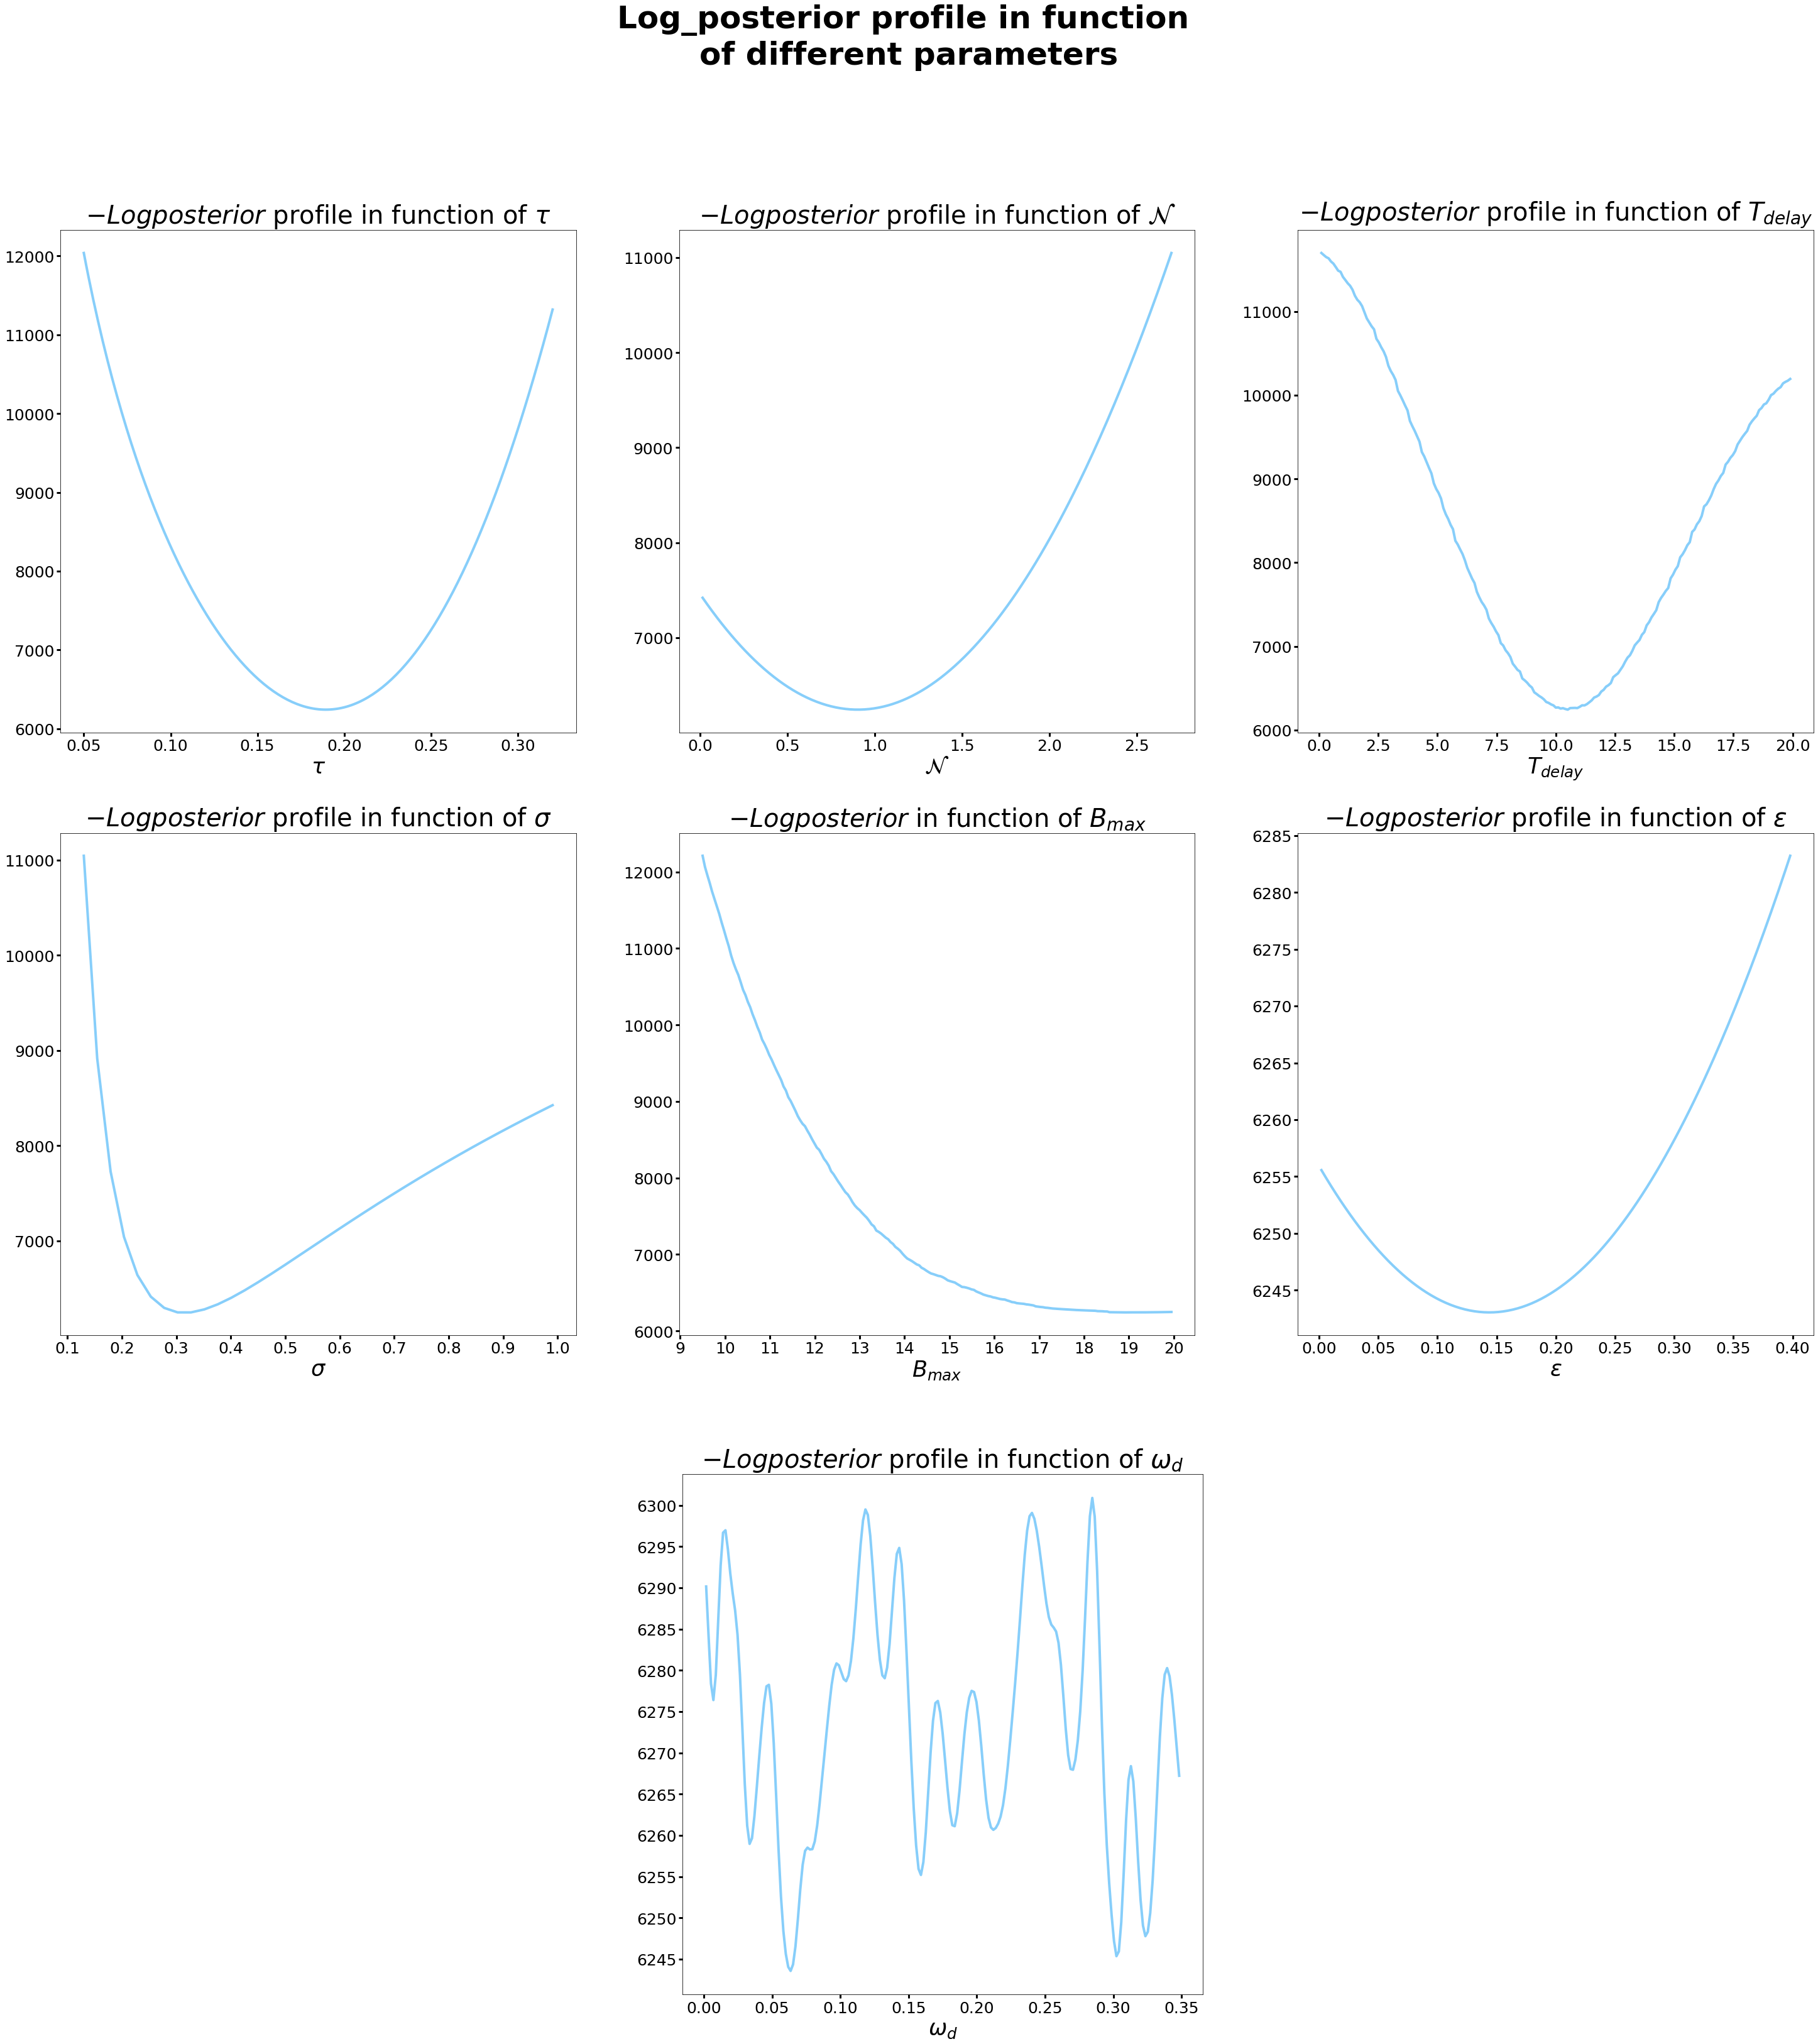

In [120]:
fig, axes = plt.subplots(3,3, figsize=(50,50))
fig.suptitle('Log_posterior profile in function \nof different parameters',fontsize = 50, fontweight="bold" )
axes[2][1].set_visible(False)
axes[2][2].set_visible(False)

axes[2][0].set_position([0.40, 0.10,0.23, 0.23])

tau_x = np.linspace(0.05, 0.32, 199)
loglike_profile_tau = np.zeros_like(tau_x)
for i, elem in enumerate(tau_x):
    loglike_profile_tau[i] = log_posterior_minimization_cos([elem, Nd_fix, T_delay_fix, sigma_fix, B_max_fix,e_fix,w_fix], data, dt)
axes[0][0].plot(tau_x, loglike_profile_tau, linewidth=4,color="lightskyblue")
axes[0][0].set_title(r"$- Log posterior$ profile in function of $\tau$", fontsize=40)
axes[0][0].set_xlabel(r'$\tau$', fontsize = 35, fontweight="bold")
#axes[0][0].set_ylabel('Log_posterior', fontsize = 35)
axes[0][0].xaxis.set_major_locator(MultipleLocator(0.05))
#axes[0][0].xaxis.set_minor_locator(MultipleLocator(0.01))
axes[0][0].yaxis.set_major_locator(MultipleLocator(1000))
#axes[0][0].yaxis.set_minor_locator(MultipleLocator(5000))
axes[0][0].tick_params(which='major', length=6, width=3, color='black',labelsize=25)
#axes[0][0].tick_params(which='minor', length=8, width=4, color='grey')

#################################################################################################################################

Nd_x = np.linspace(0, 2.7, 199)
loglike_profile_Nd = np.zeros_like(Nd_x)
for i, elem in enumerate(Nd_x):
    loglike_profile_Nd[i] = log_posterior_minimization_cos([tau_fix, elem, T_delay_fix, sigma_fix, B_max_fix,e_fix,w_fix], data, dt)
axes[0][1].plot(Nd_x, loglike_profile_Nd, linewidth=4,color="lightskyblue")
axes[0][1].set_title(r"$- Log posterior$ profile in function of $\mathcal{N}$", fontsize=40)
axes[0][1].set_xlabel(r'$\mathcal{N}$', fontsize = 35, fontweight="bold")
#axes[0][1].set_ylabel('Log_likelihood', fontsize = 20) 
axes[0][1].xaxis.set_major_locator(MultipleLocator(0.5))
#axes[0][1].xaxis.set_minor_locator(MultipleLocator(0.10))
axes[0][1].yaxis.set_major_locator(MultipleLocator(1000))
#axes[0][1].yaxis.set_minor_locator(MultipleLocator(100))
axes[0][1].tick_params(which='major', length=6, width=3, color='black',labelsize=25)
#axes[0][1].tick_params(which='minor', length=8, width=4, color='grey')

#################################################################################################################################

T_delay_x = np.linspace(0, 20, 199)
loglike_profile_T = np.zeros_like(T_delay_x)
for i, elem in enumerate(T_delay_x):
    loglike_profile_T[i] = log_posterior_minimization_cos([tau_fix, Nd_fix, elem, sigma_fix, B_max_fix,e_fix,w_fix], data, dt)
axes[0][2].plot(T_delay_x, loglike_profile_T,linewidth=4,color="lightskyblue")
axes[0][2].set_title(r"$- Log posterior$ profile in function of $T_{delay}$", fontsize=40)
axes[0][2].set_xlabel(r'$T_{delay}$', fontsize = 35, fontweight="bold")
#axes[0][2].set_ylabel('Log_likelihood', fontsize = 20) 
axes[0][2].xaxis.set_major_locator(MultipleLocator(2.5))
#axes[0][2].xaxis.set_minor_locator(MultipleLocator(1))
axes[0][2].yaxis.set_major_locator(MultipleLocator(1000))
#axes[0][2].yaxis.set_minor_locator(MultipleLocator(250))
axes[0][2].tick_params(which='major', length=6, width=3, color='black',labelsize=25)
#axes[0][2].tick_params(which='minor', length=8, width=4, color='grey')

###############################################################################################################################

sigma_x = np.linspace(0.13, 5, 199)
loglike_profile_sigma = np.zeros_like(sigma_x)
for i, elem in enumerate(sigma_x):
    loglike_profile_sigma[i] = log_posterior_minimization_cos([tau_fix, Nd_fix, T_delay_fix, elem, B_max_fix,e_fix,w_fix], data, dt)
axes[1][0].plot(sigma_x, loglike_profile_sigma,linewidth=4,color="lightskyblue")
axes[1][0].set_title(r"$- Log posterior$ profile in function of $\sigma$", fontsize=40)
axes[1][0].set_xlabel(r'$\sigma$', fontsize = 35, fontweight="bold")
#axes[1][0].set_ylabel('Log_posterior', fontsize = 40)  
axes[1][0].xaxis.set_major_locator(MultipleLocator(0.1))
#axes[1][0].xaxis.set_minor_locator(MultipleLocator(0.05))
#axes[1][0].yaxis.set_major_locator(MultipleLocator(0.5))
#axes[1][0].yaxis.set_minor_locator(MultipleLocator(0.1))
axes[1][0].tick_params(which='major', length=6, width=3, color='black',labelsize=25)
#axes[1][0].tick_params(which='minor', length=8, width=4, color='grey')

###############################################################################################################################

B_max_x = np.linspace(9.5, 20, 199)
loglike_profile_B = np.zeros_like(B_max_x)
for i, elem in enumerate(B_max_x):
    loglike_profile_B[i] = log_posterior_minimization_cos([tau_fix, Nd_fix, T_delay_fix, sigma_fix, elem,e_fix,w_fix], data, dt) 
axes[1][1].plot(B_max_x, loglike_profile_B, linewidth=4,color="lightskyblue")
axes[1][1].set_title(r"$- Log posterior$ in function of $B_{max}$", fontsize=40)
axes[1][1].set_xlabel(r'$B_{max}$', fontsize = 35, fontweight="bold")
#ax.set_ylabel('Log_likelihood', fontsize = 20) 
axes[1][1].xaxis.set_major_locator(MultipleLocator(1))
#axes[1][1].xaxis.set_minor_locator(MultipleLocator(0.5))
axes[1][1].yaxis.set_major_locator(MultipleLocator(1000))
#axes[1][1].yaxis.set_minor_locator(MultipleLocator(500))
axes[1][1].tick_params(which='major', length=6, width=3, color='black',labelsize=25)
#axes[1][1].tick_params(which='minor', length=8, width=4, color='grey')

###############################################################################################################################

e_x = np.linspace(0, 0.4, 199)
loglike_profile_e = np.zeros_like(e_x)
for i, elem in enumerate(e_x):
    loglike_profile_e[i] = log_posterior_minimization_cos([tau_fix, Nd_fix, T_delay_fix, sigma_fix, B_max_fix, elem, w_fix], data, dt) 
axes[1][2].plot(e_x, loglike_profile_e, linewidth=4,color="lightskyblue")
axes[1][2].set_title(r"$- Log posterior$ profile in function of $\epsilon$", fontsize=40)
axes[1][2].set_xlabel(r'$\epsilon$', fontsize = 35, fontweight="bold")
#ax.set_ylabel('Log_likelihood', fontsize = 20) 
axes[1][2].xaxis.set_major_locator(MultipleLocator(0.05))
#axes[1][2].xaxis.set_minor_locator(MultipleLocator(0.01))
axes[1][2].yaxis.set_major_locator(MultipleLocator(5))
#axes[1][2].yaxis.set_minor_locator(MultipleLocator(1))
axes[1][2].tick_params(which='major', length=6, width=3, color='black',labelsize=25)
#axes[1][2].tick_params(which='minor', length=8, width=4, color='grey')

###############################################################################################################################

w_x = np.linspace(0, 0.35, 199)
loglike_profile_w = np.zeros_like(w_x)
for i, elem in enumerate(w_x):
    loglike_profile_w[i] = log_posterior_minimization_cos([tau_fix, Nd_fix, T_delay_fix, sigma_fix, B_max_fix, e_fix, elem], data, dt) 
axes[2][0].plot(w_x, loglike_profile_w, linewidth=4,color="lightskyblue")
axes[2][0].set_title(r"$- Log posterior$ profile in function of $\omega_d$", fontsize=40)
axes[2][0].set_xlabel(r'$\omega_d$', fontsize = 35, fontweight="bold")
#axes[2][0].set_ylabel('Log_posterior', fontsize = 35)
axes[2][0].xaxis.set_major_locator(MultipleLocator(0.05))
#axes[2][0].xaxis.set_minor_locator(MultipleLocator(0.01))
axes[2][0].yaxis.set_major_locator(MultipleLocator(5))
#axes[2][0].yaxis.set_minor_locator(MultipleLocator(1))
axes[2][0].tick_params(which='major', length=6, width=3, color='black',labelsize=25)
#axes[2][0].tick_params(which='minor', length=8, width=4, color='grey')



The profiles of the posterior for the old parameters does not change considerably. Regarding the new ones, it is possible to see that $\epsilon$ is characterized by a well defined unique minima in the range considered while $\omega_{d}$ has multiple local minima. 

It's interesting to notice that the $\omega_{d}$ global minimum is linked to a period of approximately $98$ years, not that far from the **Gleissberg cycle**. The other minima are linked to the characteristic **Hale cycles** of $22$ years.

*Note:* during the the minimization it is not unusal to obtain a different value of this parameter and so multiple runs of the optimizer could be necessary to obtaine a value around the correct global minima.

100%|██████████| 5000/5000 [29:46<00:00,  2.80it/s]


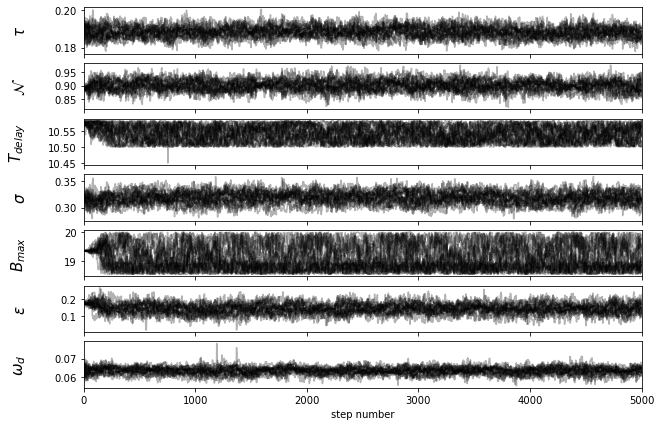

In [122]:
pos = minimum_cos.x + 1e-3 * np.random.randn(20, 7)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_cos, args=(data, dt))
sampler.run_mcmc(pos, 5000, progress=True);

fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\tau$", r"$\mathcal{N}$", r"$T_{delay}$", r"$\sigma$", r"$B_{max}$", r"$\epsilon$", r"$\omega_d$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize = 15)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [123]:
flat_samples = sampler.get_chain(discard=200, thin=20, flat=True)
print(flat_samples.shape)

(4800, 7)


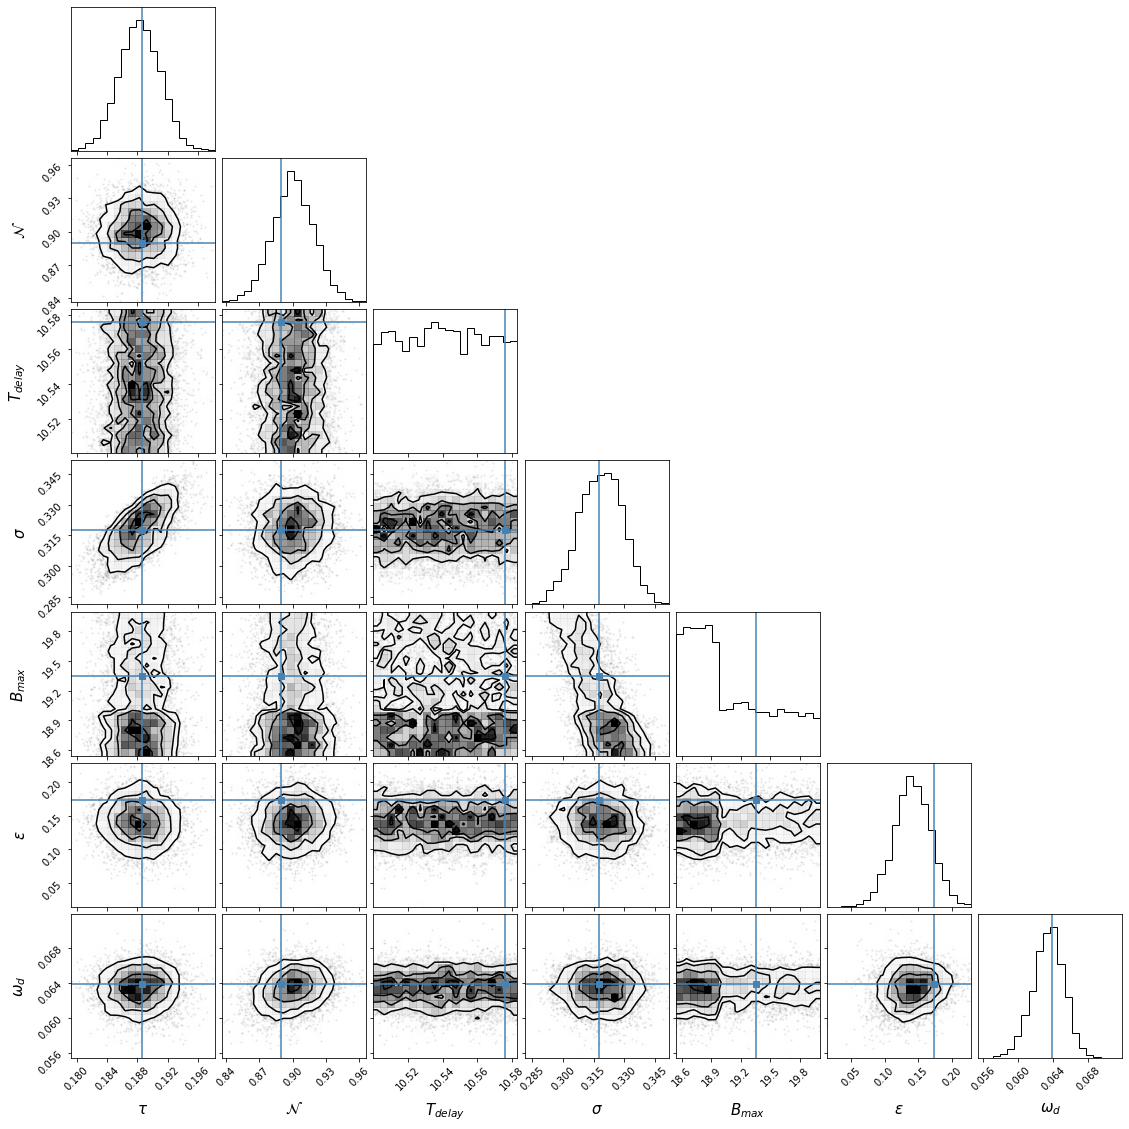

In [124]:
fig = corner.corner(
    flat_samples, labels=labels, truths=minimum_cos.x, label_kwargs={"fontsize": 15}
);

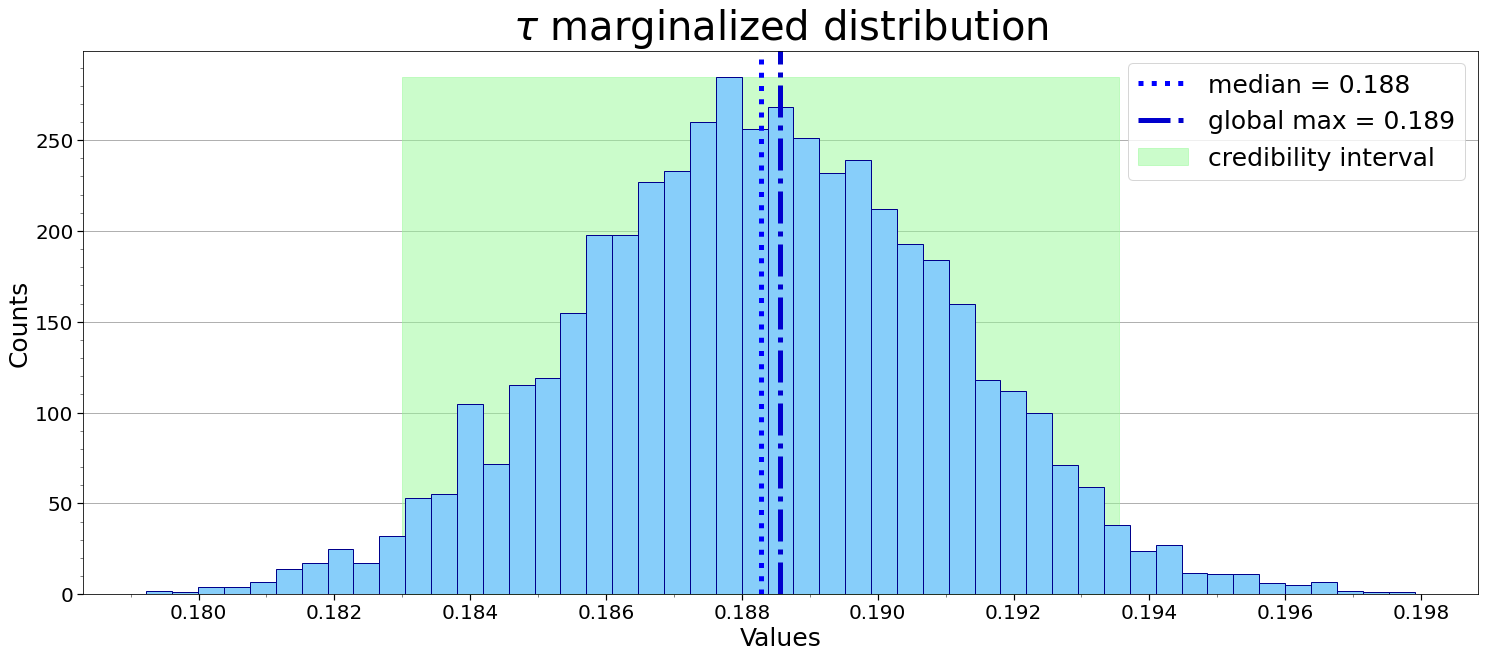

In [126]:
tau_hist = np.concatenate([a for a in flat_samples[:,0]], axis=None)
ci_tau = histogram(tau_hist, r"$\tau$ marginalized distribution", minimum_cos.x[0], 1500, 0.002, 0.001)

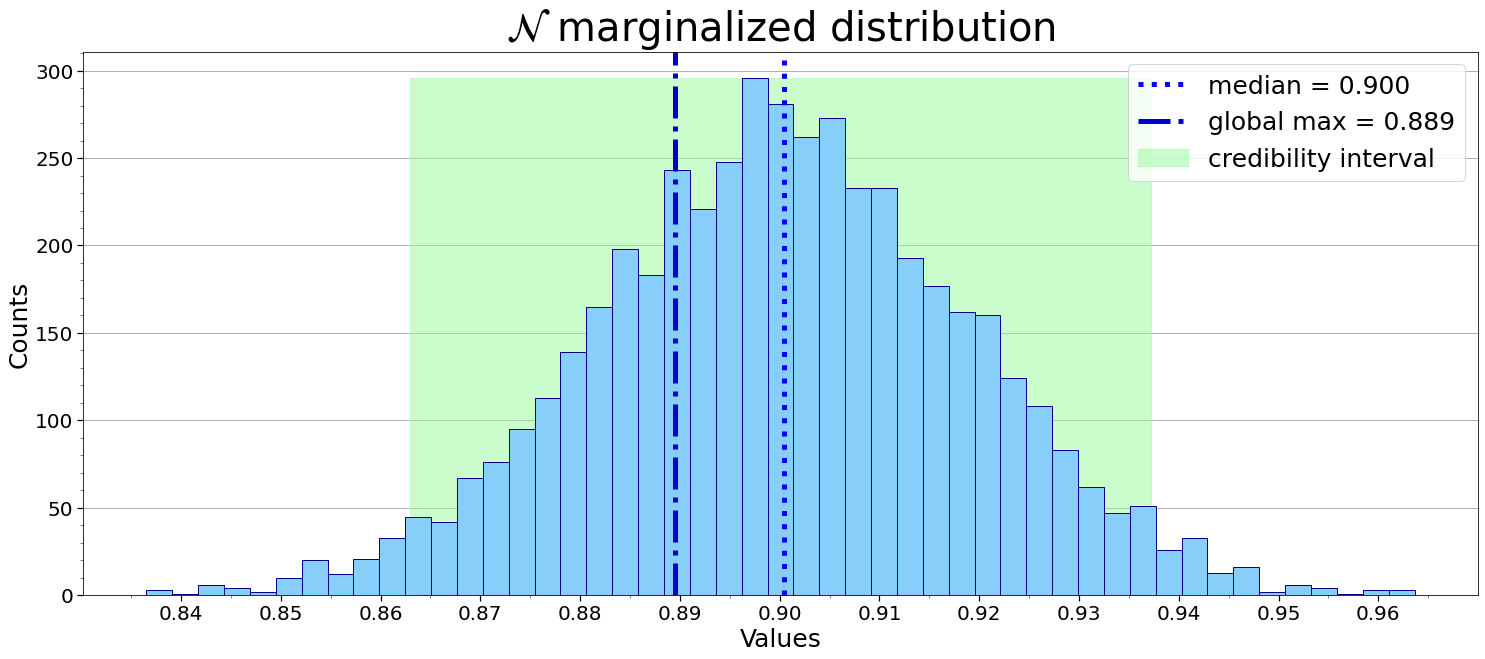

In [127]:
Nd_hist = np.concatenate([a for a in flat_samples[:,1]], axis=None)
ci_Nd = histogram(Nd_hist,r"$\mathcal{N}$ marginalized distribution", minimum_cos.x[1], 1500, 0.01, 0.005 )

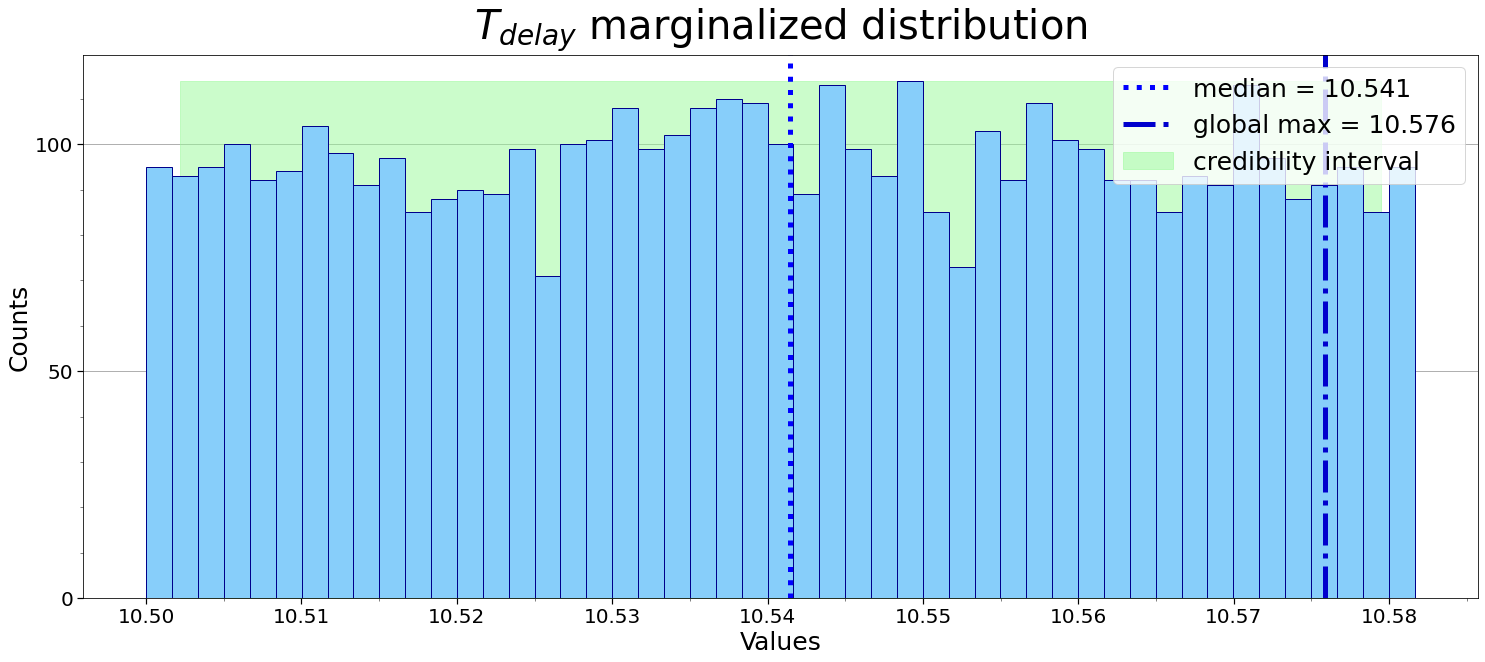

In [128]:
T_delay_hist = np.concatenate([a for a in flat_samples[:,2]], axis=None)
ci_T_delay = histogram(T_delay_hist, r"$T_{delay}$ marginalized distribution", minimum_cos.x[2], 1500, 0.01, 0.005)

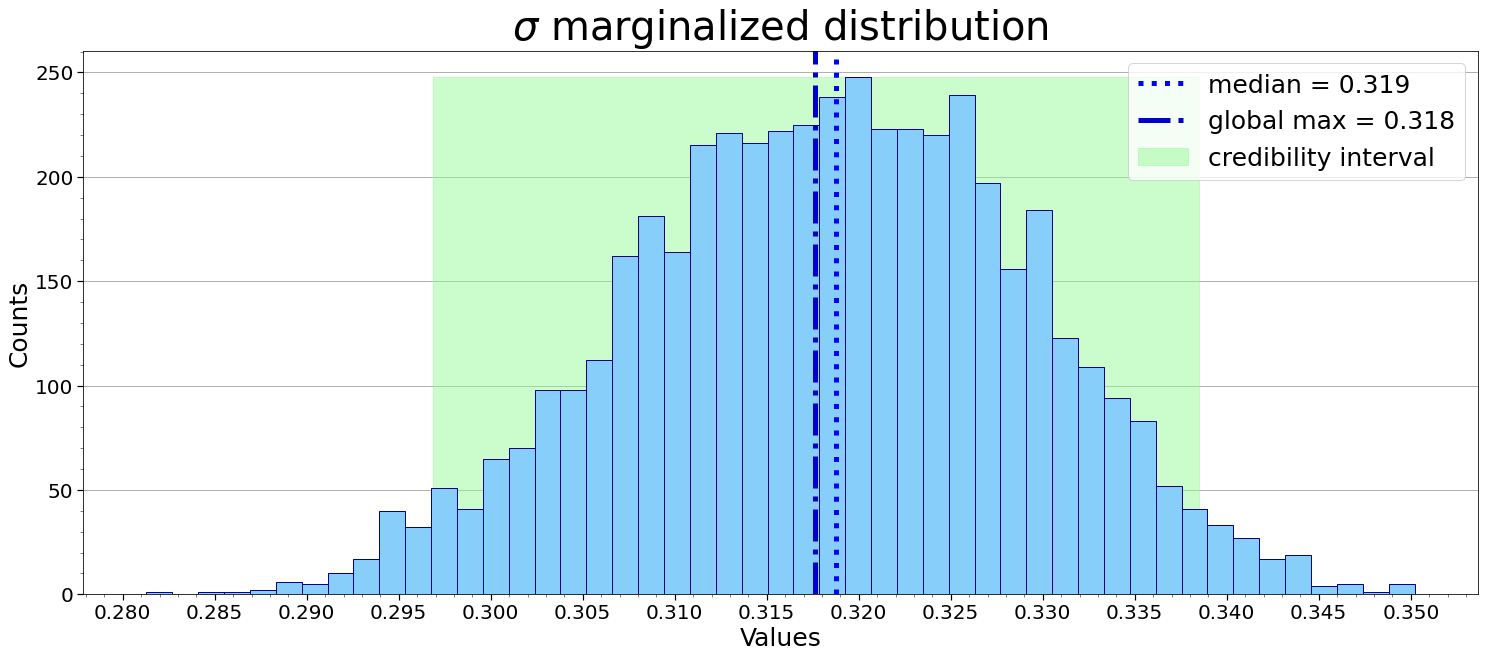

In [129]:
sigma_hist = np.concatenate([a for a in flat_samples[:,3]], axis=None)
ci_sigma = histogram(sigma_hist,r"$\sigma$ marginalized distribution", minimum_cos.x[3], 80, 0.005, 0.001)

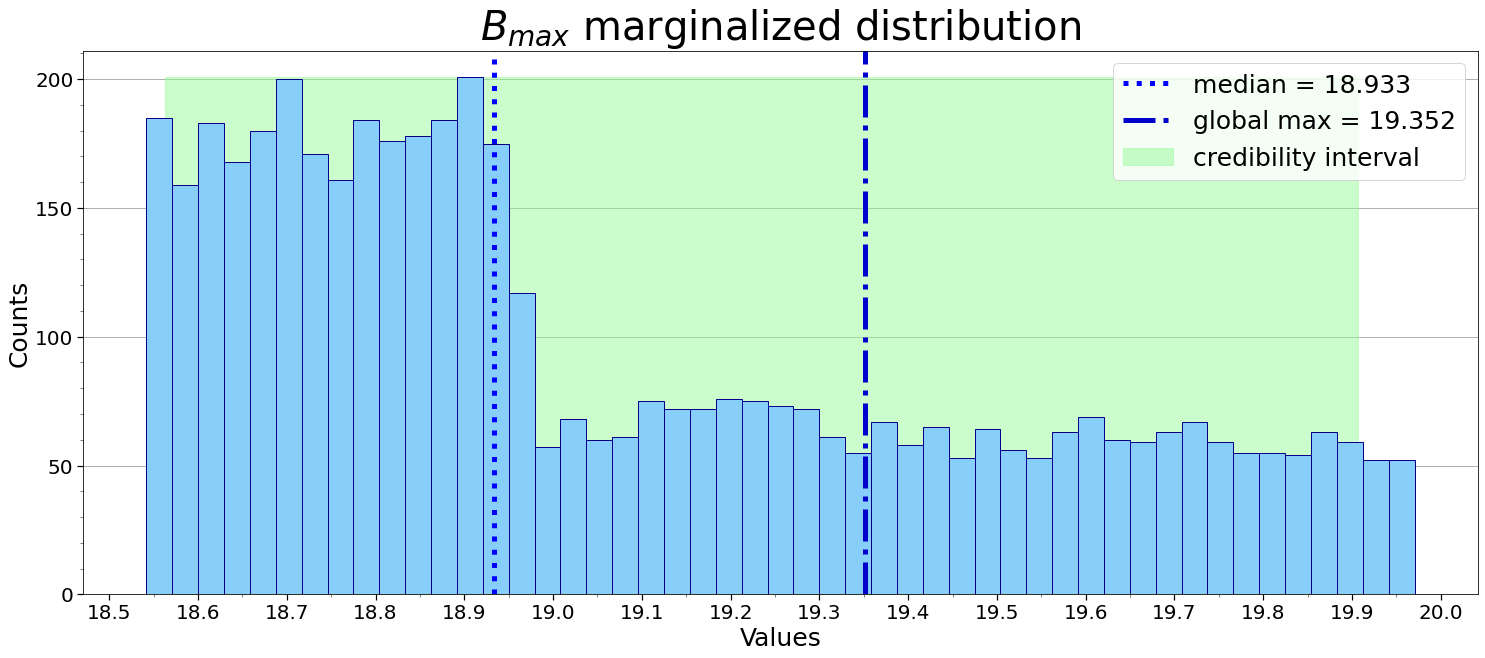

In [130]:
B_max_hist = np.concatenate([a for a in flat_samples[:,4]], axis=None)
ci_B_max = histogram(B_max_hist, r"$B_{max}$ marginalized distribution", minimum_cos.x[4], 1500, 0.1, 0.05)

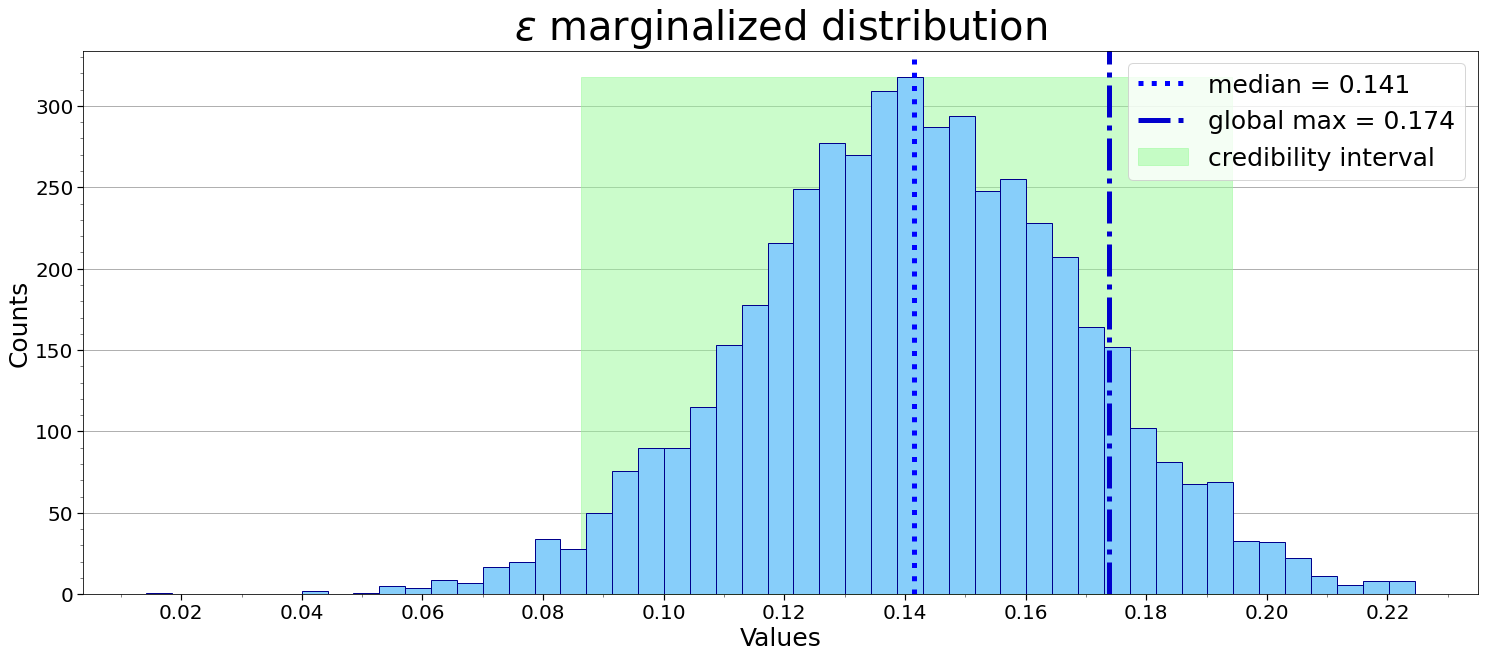

In [132]:
e_hist = np.concatenate([a for a in flat_samples[:,5]], axis=None)
ci_e = histogram(e_hist, r"$\epsilon$ marginalized distribution", minimum_cos.x[5], 1500, 0.02, 0.01)

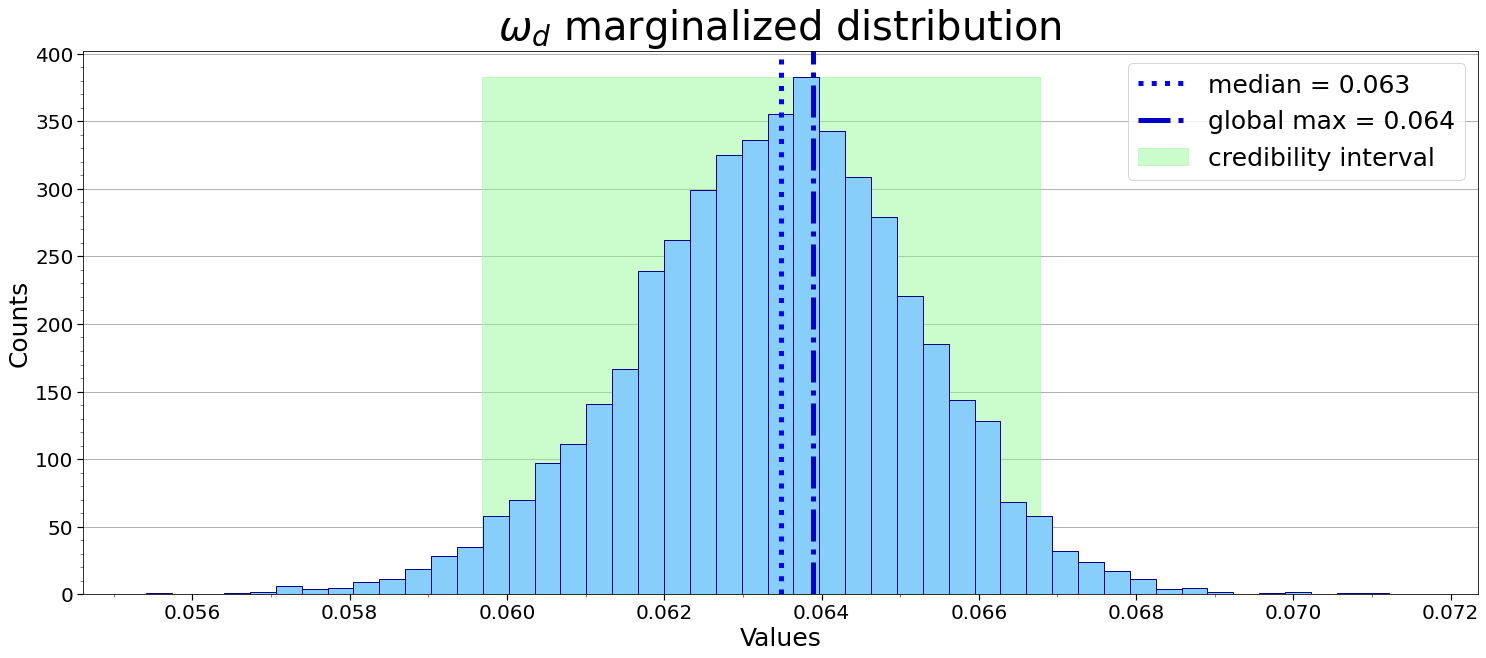

In [133]:
w_hist = np.concatenate([a for a in flat_samples[:,6]], axis=None)
ci_w = histogram(w_hist, r"$\omega_d$ marginalized distribution", minimum_cos.x[6], 1500, 0.002, 0.001)

In [134]:
d_cos = {'Values': minimum_cos.x, 'Credibility Intervals': [round_list(ci_tau), round_list(ci_Nd), round_list(ci_T_delay), round_list(ci_sigma), round_list(ci_B_max), round_list(ci_e), round_list(ci_w)]}
df_cos = pd.DataFrame(data=d_cos, index=[r'$\tau$', r'$\mathcal{N}$', r'$T_{delay}$', r"$\sigma$", r"$B_{max}$", r"$\epsilon$", r"$\omega_d$"]).round(3)
df_cos.round(3)

Values Credibility Intervals
$\tau$          0.189        [0.183, 0.194]
$\mathcal{N}$   0.889        [0.863, 0.937]
$T_{delay}$    10.576      [10.502, 10.579]
$\sigma$        0.318        [0.297, 0.339]
$B_{max}$      19.352      [18.563, 19.907]
$\epsilon$      0.174        [0.086, 0.194]
$\omega_d$      0.064         [0.06, 0.067]

The are not considerable changes in the marginalized posteriors and in the credibility intervals for the already existing parameters with respect to the previous method. It is possible to see that the one dimensional marginalized posteriors of the new parameters have a shape similar to a gaussian.

### Constraining $\mathcal{N}$ > 1

It is observed that even with the modulation there is a decay of the wave after almost 100 years. In order to obtaine a more substained wave the parameter $\mathcal{N}$ is constrained to be grater then 1. Here the results are presented and compared to the one obtained without modulation

In [135]:
bounds2_cos = [(0,20),(1,20),(0,20),(0,1),(0,20),(0,0.4),(0,0.35)]

minimum_cos = differential_evolution(log_posterior_minimization_cos, bounds2_cos, args = (data, dt), mutation = (0,1.5), popsize=100, maxiter=10000)

tau_fix_c, Nd_fix_c, T_delay_fix_c, sigma_fix_c, B_max_fix_c, e_fix_c, w_fix_c = minimum_cos.x

C:\Users\stefa\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [136]:
df_theta_min_cos = pd.DataFrame({r'$\tau$': [minimum_cos.x[0]],
                   r'$\mathcal{N}$': [minimum_cos.x[1]],
                   r'$T_{delay}$': [minimum_cos.x[2]],
                   r"$\sigma$":[minimum_cos.x[3]],
                   r"$B_{max}$":[minimum_cos.x[4]],
                   r"$\epsilon$":[minimum_cos.x[5]], 
                   r"$\omega_d$":[minimum_cos.x[6]]}, index=[r"$\theta_{min}$"])

df_theta_min_cos

$\tau$  $\mathcal{N}$  $T_{delay}$  $\sigma$  $B_{max}$  \
$\theta_{min}$  0.19288       1.003495    10.349007   0.37423  17.320119   

                $\epsilon$  $\omega_d$  
$\theta_{min}$    0.169961    0.064465

In [138]:
df_log_posterior_cos = pd.DataFrame({r"- log-posterior($\bar{\theta}$)":[log_posterior_minimization_cos(minimum_cos.x, data, dt)]},index=[""])
df_log_posterior_cos.round(3)

- log-posterior($\bar{\theta}$)
                         6260.462

It is possible to see that the resulting $- \mbox{logposterior}$ is just slightly worse than the one obtained without constraines.

In [139]:
t, B_sim_cos = SDDE_simulate_cos(dt = dt, tau = tau_fix_c, Nd = Nd_fix_c, T_delay = T_delay_fix_c, e=e_fix_c, w=w_fix_c, T_sim = len(data)*dt, sigma = sigma_fix_c , B_max = B_max_fix_c, B_i = data[:(int(T_delay_fix_c/dt)+2)], flag = False)

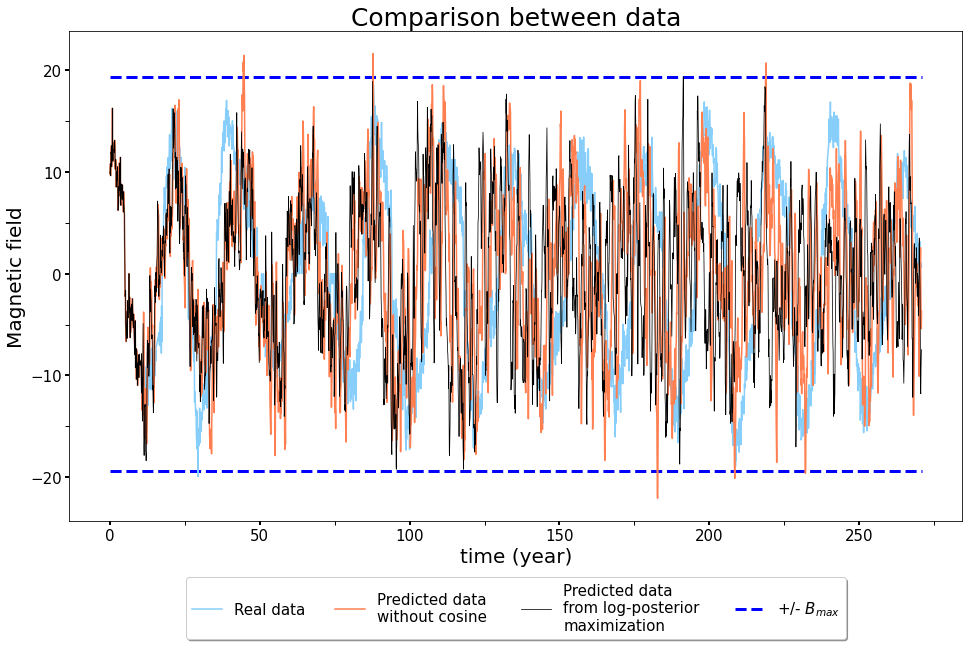

In [140]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(t, data, color="lightskyblue",linewidth=1.5, label ="Real data")
ax.plot(t, B_sim_1, color = "coral", linewidth=1.5, label="Predicted data \nwithout cosine")
ax.plot(t, B_sim_cos, color = "black", linewidth=0.75, label="Predicted data \nfrom log-posterior \nmaximization")
ax.set_title("Comparison between data", fontsize=25)
ax.set_xlabel('time (year)', fontsize = 20)
ax.set_ylabel('Magnetic field', fontsize = 20)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(which='major',labelsize=15, length=4, width=2, color='black')
ax.tick_params(which='minor',labelsize=15, length=4, width=1, color='black')
ax.hlines(B_max_fix, 0, t[-1], colors = 'blue', linestyles = 'dashed', label="+/- $B_{max}$",linewidth=3) # thresholds at B_max and -B_max
ax.hlines(-B_max_fix, 0, t[-1], colors = 'blue', linestyles = 'dashed',linewidth=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4, fontsize=15)

Even if it is noisy it is possible to see that the resulting wave does not decay and the result is very similar to the one obtained without modulation.

## Deterministic fit of the real data

The assumption that we made in the previous sections is that the evolution of the solar magnetic field follows a stochastic process. Another legitimate point of view is that the trajectory is deterministic and the variability we see in real data is due to measurement errors. In other words one can assume that the magnetic field $B_i$ at a given time $t_i$ is:

\begin{equation}
    B_i = B_i^{model} + \eta B_{max} \epsilon_i
\end{equation}

where $B_i^{model}$ is the deterministic prediction given the parameters $\tau$, $\mathcal{N}$, $T_{delay}$, $B_{max}$ (there is no more $\sigma$, because there is no more stochastic term), $\eta$ regulates the amplitude of the error and $\epsilon_i$ is a normal random value. This can be valid if $i > k \geq T$, where $k$ will be the length of the initial conditions (this time fixed $\forall\ T$). Similarly at what we have done in the stochastic case, we can build a likelihood starting from $\epsilon_i$ and changing the variable to $B_i$:

\begin{align} \nonumber
    P(B_{k},..,B_N|\bar{\theta}) & = \frac{1}{(2\pi \eta^2 B_{max}^2)^{(N - k)/2}} \cdot \exp\biggl[ - \sum_{i=k}^{N} \frac{( B_i - B_i^{model}(\bar{\theta}))^2 }{2 ( \eta B_{max} )^2}\biggr]
\end{align}

\begin{align} \nonumber
    \mathcal{L}(B_{k},..,B_N|\bar{\theta}) & = -\frac{1}{2} \ln{(2\pi \eta^2 B_{max}^2)} \cdot (N-k) - \sum_{i=k}^{N} \frac{( B_i - B_i^{model}(\bar{\theta}))^2 }{2 ( \eta B_{max} )^2}
\end{align}


The problem in this kind of likelihood is that $B^{model}$ is not analytically computable from $\bar{\theta}$, but some numeric integration is needed, with some unavoidable loss in precision. For this reason the time step used in the integration process is set to $1/10$ of the dataset $dt$. Moreover, the initial conditions need to be interpolated from the first $k-1$ samples of the dataset with the same smaller time step, called $dts$.

In [141]:
from scipy.interpolate import interp1d

scale = 10
dts = 1/(12*scale) # smaller time step
k = 190 # initial samples
f_b_in = interp1d(time[:(k+1)], data[:(k+1)], kind='cubic', fill_value="extrapolate")
data_notfit = f_b_in(np.arange(0, time[k]+dts, dts))

In [142]:
def integrator_smalldt(B, dt, tau, Nd, T, T_sim = 100, sigma = 0, B_max = 10):
    # function that computes B(t) in its discretized form
    for i in range((k*scale)+1, len(B)):
        B[i] = 2*(1-(dt/tau))*B[i-1] - (1-(dt/tau))**2*B[i-2] - (dt/tau)**2*Nd*B[i-(T+2)]*f(B[i-(T+2)],B_max) + (dt/tau)**(3/2)*sigma*B_max*np.random.randn()
    
    return B

In [143]:
def SDDE_smalldt(dt, tau, Nd, T_delay = 3.2, T_sim = 100, sigma = 0, B_max = 10, B_i = 9.9, flag = True): 
    # function that creates the arrays and plot the integrated B(t)
    np.random.seed(463617)
    t = np.arange(0, T_sim, dt)
    N = len(t)
    B = np.zeros(N)
    T = int(T_delay/(dt*10))
    T = 10*T
    
    #B[:T+1] = B_max*np.sin(t[:T+1])
    B[:(k*scale)+1] = data_notfit # initial conditions
    
    B = integrator_smalldt(B, dt, tau, Nd, T, T_sim, sigma, B_max)
    
    if flag:
        fig, ax = plt.subplots()
        ax.plot(t, B, color = "lightskyblue", linewidth=3)
        ax.hlines(B_max, 0, T_sim, colors = 'blue', linestyles = 'dashed', label="+/- $B_{max}$",linewidth=3) # thresholds at B_max and -B_max
        ax.hlines(-B_max, 0, T_sim, colors = 'blue', linestyles = 'dashed',linewidth=3)
    
        ax.set_title("Solar magnetic field", fontsize=25)
        ax.set_xlabel('time', fontsize = 20)
        ax.set_ylabel('Magnetic field', fontsize = 20)
    
        ax.legend(loc="lower right",fontsize=20)
    
        ax.xaxis.set_major_locator(MultipleLocator(50))
        ax.xaxis.set_minor_locator(MultipleLocator(25))
    
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.yaxis.set_minor_locator(MultipleLocator(5))
    
        ax.tick_params(which='major', length=4, width=2, color='black')
        ax.tick_params(which='minor', length=4, width=1, color='black')
    
    return t, B

### Likelihood with the error term

In [144]:
def log_likelihood_deterministic(theta, B, dt):
    tau, Nd, T_delay, eta, B_max = theta
    N = len(B)
    T = int(T_delay/dt)
    dts = dt/scale
    B_model = np.zeros((N*scale)+1)
    B_model[:(k*scale)+1] = data_notfit
    summation = 0

    for i in range((k*scale)+1, (N*scale)+1):
        B_model[i] = 2*(1-(dts/tau))*B_model[i-1] - (1-(dts/tau))**2*B_model[i-2] - (dts/tau)**2*Nd*B_model[i-((T*scale)+2)]*f(B_model[i-((T*scale)+2)],B_max)
    
    for i in range(k, N):
        summation += (B_model[(scale*i)]-B[i])**2
        
    return -((0.5) * np.log( 2 * np.pi * (B_max*eta)**2)*(N-(T+2)) + summation/( 2 * (B_max*eta)**2 ))
    #return summation
    
def log_prior_deterministic(theta):
    tau, Nd, T_delay, eta, B_max = theta
    if 0 < tau < 20 and 0 < Nd < 20 and 0 < T_delay < 15 and 0 < eta < 1 and 0 < B_max < 10:
        return 0.0
    return -np.inf

def log_posterior_deterministic(theta, B, dt):
    lp = log_prior_deterministic(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_deterministic(theta, B, dt)

def log_posterior_deterministic_minimization(theta, B, dt):
    return (-log_posterior_deterministic(theta, B, dt))

In [145]:
N = len(data)
dt = 1/12

bounds = [(0,20),(0,20),(0,15),(0,1),(0,10)]

minimum_det = differential_evolution(log_posterior_deterministic_minimization, bounds, args = (data, dt), popsize = 10, maxiter = 400)

<ipython-input-144-7268cc18438f>:11: RuntimeWarning: overflow encountered in double_scalars
  B_model[i] = 2*(1-(dts/tau))*B_model[i-1] - (1-(dts/tau))**2*B_model[i-2] - (dts/tau)**2*Nd*B_model[i-((T*scale)+2)]*f(B_model[i-((T*scale)+2)],B_max)
<ipython-input-144-7268cc18438f>:11: RuntimeWarning: invalid value encountered in double_scalars
  B_model[i] = 2*(1-(dts/tau))*B_model[i-1] - (1-(dts/tau))**2*B_model[i-2] - (dts/tau)**2*Nd*B_model[i-((T*scale)+2)]*f(B_model[i-((T*scale)+2)],B_max)
<ipython-input-144-7268cc18438f>:14: RuntimeWarning: overflow encountered in double_scalars
  summation += (B_model[(scale*i)]-B[i])**2
C:\Users\stefa\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [147]:
df_theta_min = pd.DataFrame({r'$\tau$': [minimum_det .x[0]],
                   r'$\mathcal{N}$': [minimum_det.x[1]],
                   r'$T_{delay}$': [minimum_det.x[2]],
                   r"$\eta$":[minimum_det.x[3]],
                   r"$B_{max}$":[minimum_det.x[4]]}, index=[r"$\theta_{min}$"])

df_theta_min

$\tau$  $\mathcal{N}$  $T_{delay}$    $\eta$  $B_{max}$
$\theta_{min}$  4.93743       9.441723     4.951183  0.677741   7.122281

In [148]:
df_log_posterior = pd.DataFrame({r"log-posterior($\bar{\theta}_{min}$)":[log_posterior_deterministic_minimization(minimum_det.x, data, dt)],
                                 },
                                  index=["log-posterior values"])
df_log_posterior.round(3)

log-posterior($\bar{\theta}_{min}$)
log-posterior values                             9332.771

In [149]:
dt = 1/(12*scale)
t, B_sim = SDDE_smalldt(dt = dt, tau = minimum_det.x[0], Nd = minimum_det.x[1], T_delay = minimum_det.x[2], T_sim = (1/12)*len(data), sigma = 0 , B_max = minimum_det.x[4], B_i = 0, flag = False)

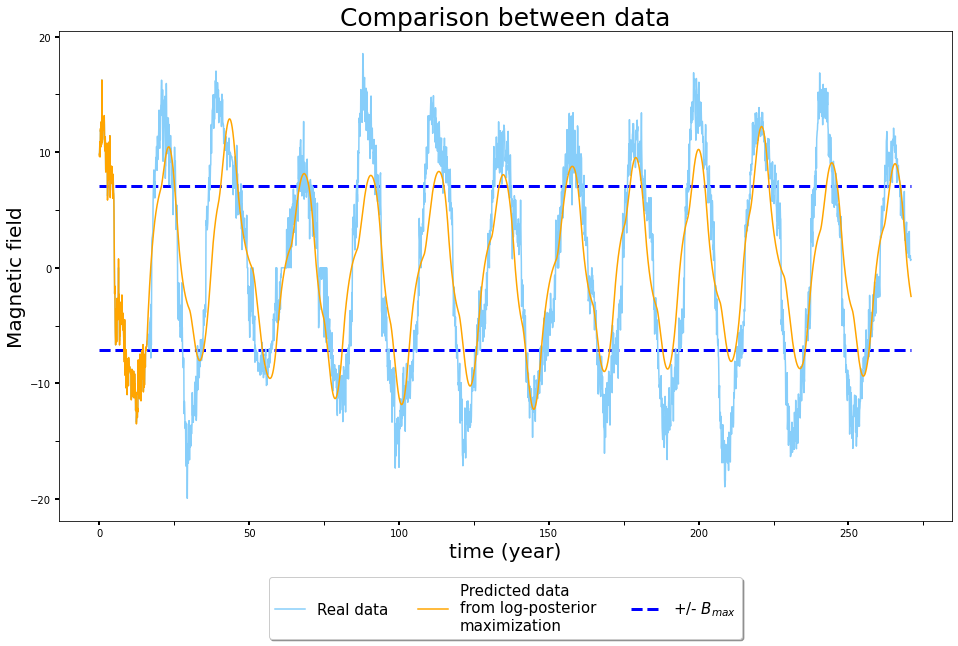

In [154]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(time, data, color="lightskyblue",linewidth=1.5, label ="Real data")
ax.plot(t, B_sim, color = "orange", linewidth=1.5, label="Predicted data \nfrom log-posterior \nmaximization")
ax.set_title("Comparison between data", fontsize=25)
ax.set_xlabel('time (year)', fontsize = 20)
ax.set_ylabel('Magnetic field', fontsize = 20)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(which='major', length=4, width=2, color='black')
ax.tick_params(which='minor', length=4, width=1, color='black')
ax.hlines(7.122281, 0, t[-1], colors = 'blue', linestyles = 'dashed', label="+/- $B_{max}$",linewidth=3) # thresholds at B_max and -B_max
ax.hlines(-7.122281, 0, t[-1], colors = 'blue', linestyles = 'dashed',linewidth=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3, fontsize=15)

The minimization process is not as stable as it was for the stochastic type of likelihood. Different runs of the `differential evolution` find different minima, all with similar values of log-posterior. This is likely due to the rough landscape of the deterministic likelihood, which arises from the need of numeric integration to compute $B^{model}$.

### Likelihood without the error term

To mimic the method used in [Carl Albert (2021)](https://iopscience.iop.org/article/10.3847/2041-8213/ac0fd6), another trial is done trying simply to minimize the sum of the square of the residuals:

\begin{align} \nonumber
    \mathcal{L}(B_{k},..,B_N|\bar{\theta}) & = - \sum_{i=k}^{N} ( B_i - B_i^{model}(\bar{\theta}))^2
\end{align}


In [152]:
def log_likelihood_deterministic(theta, B, dt):
    tau, Nd, T_delay, B_max = theta
    N = len(B)
    T = int(T_delay/dt)
    dts = dt/scale
    B_model = np.zeros((N*scale)+1)
    B_model[:(k*scale)+1] = data_notfit
    summation = 0

    for i in range((k*scale)+1, (N*scale)+1):
        B_model[i] = 2*(1-(dts/tau))*B_model[i-1] - (1-(dts/tau))**2*B_model[i-2] - (dts/tau)**2*Nd*B_model[i-((T*scale)+2)]*f(B_model[i-((T*scale)+2)],B_max)
    
    for i in range(k, N):
        summation += (B_model[(scale*i)]-B[i])**2
        
    return (-summation)
    
def log_prior_deterministic(theta):
    tau, Nd, T_delay, B_max = theta
    if 0 < tau < 20 and 0 < Nd < 20 and 0 < T_delay < 15 and 0 < B_max < 10:
        return 0.0
    return -np.inf

def log_posterior_deterministic(theta, B, dt):
    lp = log_prior_deterministic(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_deterministic(theta, B, dt)

def log_posterior_deterministic_minimization(theta, B, dt):
    return (-log_posterior_deterministic(theta, B, dt))

In [153]:
N = len(data)
dt = 1/12

bounds = [(0.1,20),(0.1,20),(0.1,15),(0.1,10)]

minimum_det = differential_evolution(log_posterior_deterministic_minimization, bounds, args = (data, dt), popsize = 10, maxiter = 400)

C:\Users\stefa\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [156]:
df_theta_min = pd.DataFrame({r'$\tau$': [minimum_det .x[0]],
                   r'$\mathcal{N}$': [minimum_det.x[1]],
                   r'$T_{delay}$': [minimum_det.x[2]],
                   r"$B_{max}$":[minimum_det.x[3]]}, index=[r"$\theta_{min}$"])

df_theta_min

$\tau$  $\mathcal{N}$  $T_{delay}$  $B_{max}$
$\theta_{min}$  3.761585       4.214754     4.821574   9.445553

In [157]:
df_log_posterior = pd.DataFrame({r"log-posterior($\bar{\theta}_{min}$)":[log_posterior_deterministic_minimization(minimum_det.x, data, dt)],
                                 },
                                  index=["log-posterior values"])
df_log_posterior.round(3)

log-posterior($\bar{\theta}_{min}$)
log-posterior values                            66154.789

In [158]:
dt = 1/(12*scale)
t, B_sim = SDDE_smalldt(dt = dt, tau = minimum_det.x[0], Nd = minimum_det.x[1], T_delay = minimum_det.x[2], T_sim = (1/12)*len(data), sigma = 0 , B_max = minimum_det.x[3], B_i = 0, flag = False)

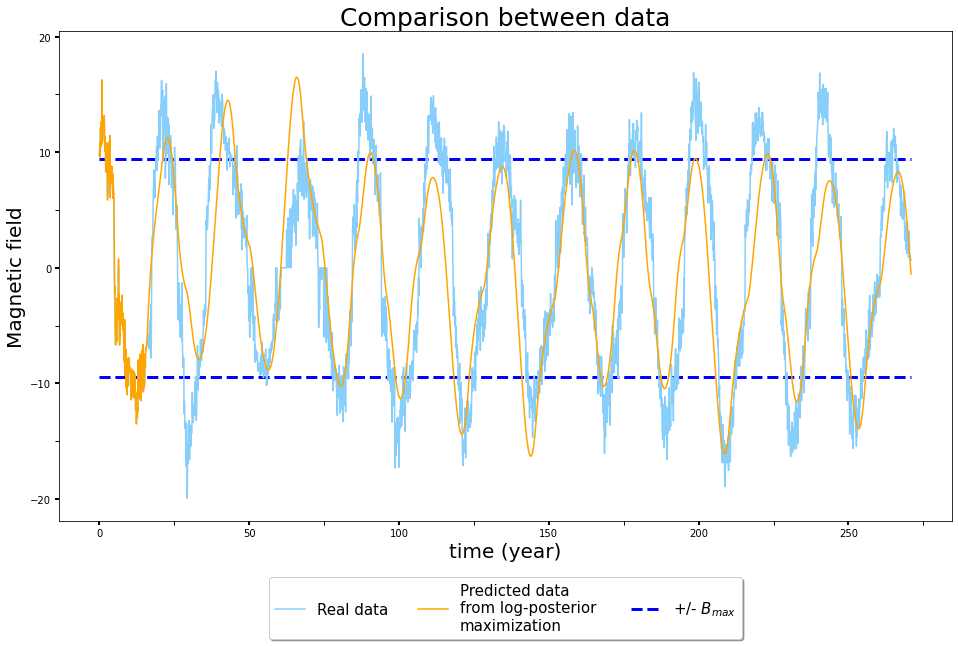

In [167]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(time, data, color="lightskyblue",linewidth=1.5, label ="Real data")
ax.plot(t, B_sim, color = "orange", linewidth=1.5, label="Predicted data \nfrom log-posterior \nmaximization")
ax.set_title("Comparison between data", fontsize=25)
ax.set_xlabel('time (year)', fontsize = 20)
ax.set_ylabel('Magnetic field', fontsize = 20)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(which='major', length=4, width=2, color='black')
ax.tick_params(which='minor', length=4, width=1, color='black')
ax.hlines(minimum_det.x[3], 0, t[-1], colors = 'blue', linestyles = 'dashed', label="+/- $B_{max}$",linewidth=3) # thresholds at B_max and -B_max
ax.hlines(-minimum_det.x[3], 0, t[-1], colors = 'blue', linestyles = 'dashed',linewidth=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3, fontsize=15)

Even in this case the results found are not stable and change from trial to trial. One specific problem of this methodology could be the choice of the initial conditions. By slightly changing the length $k$ of the initial path, some predicted trajectories can tend to diverge at the initial cycle, compromising the computed log-posterior value. 

## Future prediction of the Solar magnetic field

Thanks to the analysis developed and the observations carried out, we now want to make predictions about the next solar cycles using the simpler not-driven model with $\mathcal{N}>1$. To do this, several runs are performed and the average is taken, as each prediction has a stochastic component and this would lead to different results each time.

In [162]:
def integrator_pred(B, dt, tau, Nd, T, t_start, T_sim = 100, sigma = 0, B_max = 10):
    # function that computes B(t) in its discretized form
    
    T = int(T)
    for i in range(t_start, len(B)):
        B[i] = 2 * (1-(dt/tau)) * B[i-1] - (1-(dt/tau))**2 * B[i-2]\
               - (dt/tau)**2 * Nd * B[i-(T+2)] * f(B[i-(T+2)],B_max)\
               + (dt/tau)**(3/2) * sigma * B_max * np.random.randn()
    
    return B

In [163]:
def SDDE_pred(dt, flatsamples, T_sim = 100, B_i = 9.9, rs = 463617): 
    # function that creates the arrays and plot the integrated B(t)
    
    np.random.seed(rs) # set random seed for reproducible results
    t = np.arange(0, T_sim, dt)
    N = len(t)
    nsamp = flatsamples.shape[0]
    B = np.zeros((nsamp, N))
    flatsamples[:,2] = (flatsamples[:,2]/dt).astype('int')
    t_start = len(B_i)
    t_1750 = 1750
    
    B[:,:t_start] = B_i # initial conditions
    
    for i in range(nsamp):
        tau, Nd, T, sigma, B_max = flatsamples[i]
        B[i] = integrator_pred(B[i], dt, tau, Nd, T, t_start, T_sim, sigma, B_max) # integrating the differential equation
    
    B_av = np.mean(B, axis = 0)
    
    fig, ax = plt.subplots()
    ax.plot(t_1750+t[:t_start], B[0,:t_start], color = "lightskyblue", linewidth=1, label = "Real data")
    ax.plot(t_1750+t[t_start:], B_av[t_start:], color = "red", alpha = 1, linewidth = 1, label = "Average magnetic field")
    
    for i in range(nsamp):
        ax.plot(t_1750+t[t_start:], B[i,t_start:], color = "red", alpha = 0.055, linewidth = 0.1)
        
    #ax.hlines(B_max, 0, T_sim, colors = 'blue', linestyles = 'dashed', label="+/- $B_{max}$",linewidth=3) # thresholds at B_max and -B_max
    #ax.hlines(-B_max, 0, T_sim, colors = 'blue', linestyles = 'dashed',linewidth=3)
    
    ax.set_title("Future prediction of Solar magnetic field", fontsize=25)
    ax.set_xlabel('time (year)', fontsize = 20)
    ax.set_ylabel('Magnetic field', fontsize = 20)
    
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    
    ax.tick_params(which='major', length=4, width=2, color='black')
    ax.tick_params(which='minor', length=4, width=1, color='black')
    
    ax.set_xlim(t_1750+250, t_1750+t[-1])
    ax.legend(loc="lower right",fontsize=15)
    
    return t, B

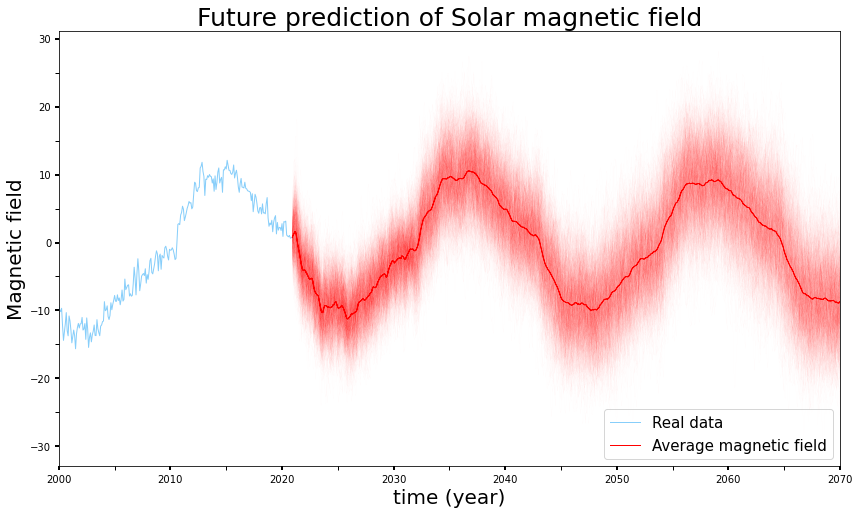

In [166]:
fs = np.copy(flat_samples_1) # the one of Nd > 1 
dt = 1/12
fut_pred = SDDE_pred(dt = dt, flatsamples = fs[np.random.choice(np.arange(fs.shape[0]), size=800, replace = False),:], T_sim = (len(data)+590)*dt, B_i = data) # fix the size to the number of trajectories you want

It was chosen to make a prediction for only two solar cycles because, as seen previously, after about two cycles the predictions become unreliable, in terms of periodicity, amplitude and noise.
It is also noted that, with only two cycles, the effect of stochasticity in the variation of the amplitude is not appreciated, which remains similar to that of the observed data.

## Conclusions

From our experiments it is observed that the Bayesian inference technique is successful on the artificial dataset and predicts the correct values for the parameters. However, results on real data are more difficult to interpret, as the values previously found in [Carl Albert (2021)](https://iopscience.iop.org/article/10.3847/2041-8213/ac0fd6) are pretty different and belong to a different "mode" of oscillation. Our attempt at adding a weak periodic driver improves only slightly the fit on the data, relying on an oscillation period in line with the Gleissberg cycle. 

Starting from this analysis, further research is needed in order to validate both the application of the Bayesian inference technique to the model and the possible effects of weak external drivers like the planets.